In [1]:
import os
import utils
import connectome_create
# viz_method = one of ['itkwidgets', 'vtk']
viz_method = 'vtk'

# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import scipy
import cmocean

%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
# import nglui.statebuilder as ngstbld

# # this is the EM specific package for querying the EM data
from caveclient import CAVEclient

from sklearn.decomposition import PCA
from numpy.random import default_rng

# from meshparty import trimesh_io, trimesh_vtk
# from meshparty import skeletonize, skeleton_io, skeleton
# import cloudvolume

%load_ext autoreload
%autoreload 2

query timestamp: 2024-04-25 11:00:00-07:00 (1714068000.0)


In [2]:
cos_cmap = cmocean.cm.gray_r
# cos_cmap = plt.get_cmap('Greys')
cos_cmap = sns.color_palette('gray_r', as_cmap=True)


In [ ]:
client = CAVEclient()

# Load wing matrix

In [3]:
# dropping the PSn_u neuron
wing_premn_to_mn_df = pd.read_pickle('./dfs_saved/preMN_to_MN_wing_v604.pkl')
# wing_premn_to_mn_df = pd.read_pickle('./dfs_saved/preMN_to_MN_wing_0104.pkl')
wing_premn_to_mn_df = pd.read_pickle('./dfs_saved/preMN_to_MN_wing_0106.pkl')

print(wing_premn_to_mn_df.shape)

if any('PSn_u' in column for column in wing_premn_to_mn_df.columns):
    # wing_premn_to_mn_df = wing_premn_to_mn_df.loc[(All,All,All,'local',All)]
    wing_premn_to_mn_df = wing_premn_to_mn_df.drop(['PSn_u'], axis=1)
    wing_premn_to_mn_df = wing_premn_to_mn_df.loc[wing_premn_to_mn_df.sum(axis=1).to_numpy()>0,:]
    print(wing_premn_to_mn_df.shape)

(1779, 29)


In [4]:
wing_premn_to_mn_df

DLM_1  \
pre_pt_root_id     preferred_module cell_type cell_class putative_NT          
648518346470309374 DLM_2            uk        descending unk             79   
648518346459520004 DLM_2            uk        descending unk             20   
648518346490882081 DLM_2            uk        descending unk             20   
648518346492458683 DLM_2            uk        descending unk             21   
648518346504153324 DLM_2            uk        descending unk             25   
...                                                                     ...   
648518346514263774 b3_u             hlx16     local      unk              0   
648518346515510602 b3_u             6A        local      GABA             0   
648518346517402148 b3_u             6A        local      GABA             0   
648518346517422884 b3_u             12A       local      ACh              0   
648518346531262490 b3_u             6A        local      GABA             0   

                                                                      DLM_2  \
pre_pt_root_id     preferred_module cell_type cell_class putative_NT          
648518346470309374 DLM_2            uk        descending unk            117   
648518346459520004 DLM_2            uk        descending unk             41   
648518346490882081 DLM_2            uk        descending unk             47   
648518346492458683 DLM_2            uk        descending unk             45   
648518346504153324 DLM_2            uk        descending unk             39   
...                                                                     ...   
648518346514263774 b3_u             hlx16     local      unk              0   
648518346515510602 b3_u             6A        local      GABA             0   
648518346517402148 b3_u             6A        local      GABA             0   
648518346517422884 b3_u             12A       local      ACh              0   
648518346531262490 b3_u             6A        local      GABA             0   

                                                                      DLM_3  \
pre_pt_root_id     preferred_module cell_type cell_class putative_NT          
648518346470309374 DLM_2            uk        descending unk            101   
648518346459520004 DLM_2            uk        descending unk             22   
648518346490882081 DLM_2            uk        descending unk             25   
648518346492458683 DLM_2            uk        descending unk             27   
648518346504153324 DLM_2            uk        descending unk             22   
...                                                                     ...   
648518346514263774 b3_u             hlx16     local      unk              0   
648518346515510602 b3_u             6A        local      GABA             0   
648518346517402148 b3_u             6A        local      GABA             0   
648518346517422884 b3_u             12A       local      ACh              0   
648518346531262490 b3_u             6A        local      GABA             0   

                                                                      DLM_4  \
pre_pt_root_id     preferred_module cell_type cell_class putative_NT          
648518346470309374 DLM_2            uk        descending unk             88   
648518346459520004 DLM_2            uk        descending unk             30   
648518346490882081 DLM_2            uk        descending unk             23   
648518346492458683 DLM_2            uk        descending unk             22   
648518346504153324 DLM_2            uk        descending unk             30   
...                                                                     ...   
648518346514263774 b3_u             hlx16     local      unk              0   
648518346515510602 b3_u             6A        local      GABA             0   
648518346517402148 b3_u             6A        local      GABA             0   
648518346517422884 b3_u             12A       local      ACh              0   
648518346531262490 b3_u             6A

In [4]:
idx_df = wing_premn_to_mn_df.index.to_frame()
col_df = wing_premn_to_mn_df.columns.to_frame()

In [5]:
col_df

0
DLM_1      DLM_1
DLM_2      DLM_2
DLM_3      DLM_3
DLM_4      DLM_4
DLM_5      DLM_5
DVM_1a    DVM_1a
DVM_1b    DVM_1b
DVM_1c    DVM_1c
DVM_2a    DVM_2a
DVM_2b    DVM_2b
DVM_3a    DVM_3a
DVM_3b    DVM_3b
PS1          PS1
PS2          PS2
dtpmn_u  dtpmn_u
tp2          tp2
tpn          tpn
i1            i1
i2_u        i2_u
iii1        iii1
iii3        iii3
iii4a_u  iii4a_u
hg1_u      hg1_u
hg2          hg2
hg3          hg3
hg4          hg4
b1            b1
b2            b2
b3_u        b3_u

In [6]:
idx_df.preferred_module.unique()

array(['DLM_2', 'DLM_3', 'DLM_4', 'DLM_5', 'DVM_1a', 'DVM_1b', 'DVM_1c',
       'DVM_3a', 'DVM_3b', 'PS1', 'PS2', 'dtpmn_u', 'tp2', 'tpn', 'i1',
       'i2_u', 'iii1', 'iii4a_u', 'hg1_u', 'hg2', 'hg3', 'hg4', 'b1',
       'b2', 'b3_u', 'iii3', 'DLM_1'], dtype=object)

In [7]:
idx_df.cell_class.unique()

['descending', 'sensory', 'ascending', 'local_intersegmental', 'local']
Categories (5, object): ['descending' < 'sensory' < 'ascending' < 'local_intersegmental' < 'local']

In [8]:
col_df = col_df.rename(columns={0:'MN'})
col_df['mod_num'] = [
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    2,
    2,
    2,
    2,
    3,
    4,
    4,
    3,
    3,
    6,
    6,
    7,
    6,
    6,
    5,
    5,
    4,
]
col_df['mod_name'] = ''
mod_map = {0:'DLM_syn',1:'DVM_syn',2:'tension_syn',3:'steerA_syn',4:'steerB_syn',5:'steerC_syn',6:'steerD_syn',7:'steerhg2_syn'}
for k in mod_map.keys():
    col_df.loc[col_df['mod_num']==k,'mod_name'] = mod_map[k]

col_df

wing_premn_to_mn_df.columns = pd.MultiIndex.from_frame(col_df)
col_df

MN  mod_num      mod_name
DLM_1      DLM_1        0       DLM_syn
DLM_2      DLM_2        0       DLM_syn
DLM_3      DLM_3        0       DLM_syn
DLM_4      DLM_4        0       DLM_syn
DLM_5      DLM_5        0       DLM_syn
DVM_1a    DVM_1a        1       DVM_syn
DVM_1b    DVM_1b        1       DVM_syn
DVM_1c    DVM_1c        1       DVM_syn
DVM_2a    DVM_2a        1       DVM_syn
DVM_2b    DVM_2b        1       DVM_syn
DVM_3a    DVM_3a        1       DVM_syn
DVM_3b    DVM_3b        1       DVM_syn
PS1          PS1        2   tension_syn
PS2          PS2        2   tension_syn
dtpmn_u  dtpmn_u        2   tension_syn
tp2          tp2        2   tension_syn
tpn          tpn        3    steerA_syn
i1            i1        4    steerB_syn
i2_u        i2_u        4    steerB_syn
iii1        iii1        3    steerA_syn
iii3        iii3        3    steerA_syn
iii4a_u  iii4a_u        6    steerD_syn
hg1_u      hg1_u        6    steerD_syn
hg2          hg2        7  steerhg2_syn
hg3          hg3        6    steerD_syn
hg4          hg4        6    steerD_syn
b1            b1        5    steerC_syn
b2            b2        5    steerC_syn
b3_u        b3_u        4    steerB_syn

In [9]:
# col_anat_df = col_df
# anat_list = ['DLM_1',
#  'DLM_2',
#  'DLM_3',
#  'DLM_4',
#  'DLM_5',
#  'DVM_1a',
#  'DVM_1b',
#  'DVM_1c',
#  'DVM_2a',
#  'DVM_2b',
#  'DVM_3a',
#  'DVM_3b',
#  'PS1',
#  'PS2',
#  'dtpmn_u',
#  'tp2',
#  'tpn',
#  'iii1',
#  'iii3',
#  'i2_u',
#  'i1',
#  'b3_u',
#  'b2',
#  'b1',
#  'hg2',
#  'hg1_u',
#  'hg3',
#  'hg4',
#  'iii4a_u']
# col_anat_df = col_anat_df.loc[]

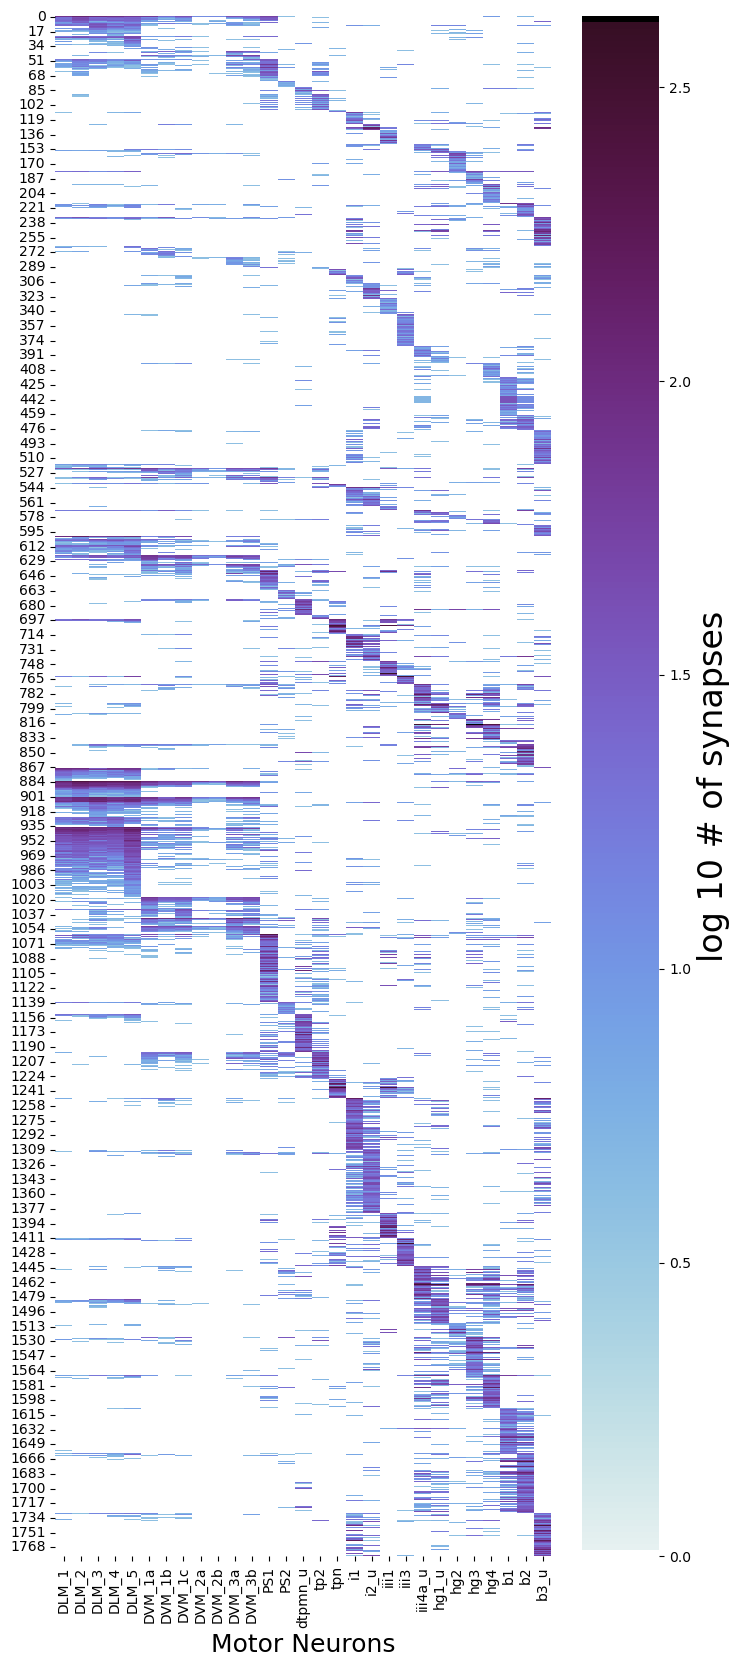

In [10]:
lbls = col_df.MN

fig = plt.figure(1, figsize = [8,20])
import cmocean
cmap_alt = cmocean.cm.dense
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(wing_premn_to_mn_df.to_numpy()+1), xticklabels=lbls, cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()

# Hierarchical clustering

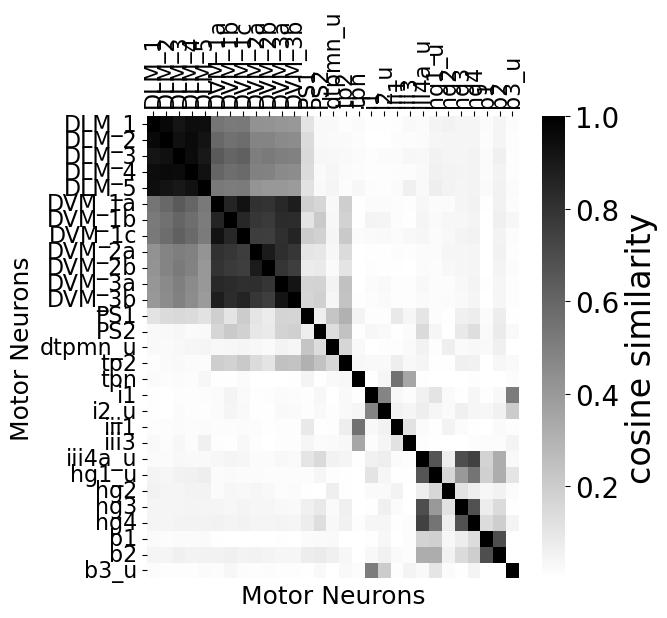

In [13]:
lbls = col_df.MN

sim_mat = cosine_similarity(wing_premn_to_mn_df.to_numpy().transpose())
fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(sim_mat, xticklabels=lbls, yticklabels=lbls,cmap=cos_cmap) # plt.get_cmap('Greys'))
ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'cosine similarity', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
plt.ylabel('Motor Neurons', fontsize =18)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.show()
fig.savefig('./figpanels/cossim_wing_anatomical_sns.svg',format='svg')

In [14]:
np.savetxt('./figpanels/cossim_anatomical_data.csv', sim_mat, delimiter=',')

c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\scipy\cluster\hierarchy.py:3429: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ivl.append(labels[int(i - n)])


['DLM_1', 'DLM_5', 'DLM_3', 'DLM_2', 'DLM_4', 'DVM_2a', 'DVM_2b', 'DVM_3a', 'DVM_3b', 'DVM_1b', 'DVM_1a', 'DVM_1c', 'b1', 'b2', 'hg1_u', 'hg3', 'iii4a_u', 'hg4', 'i2_u', 'i1', 'b3_u', 'iii3', 'tpn', 'iii1', 'hg2', 'PS2', 'dtpmn_u', 'PS1', 'tp2']


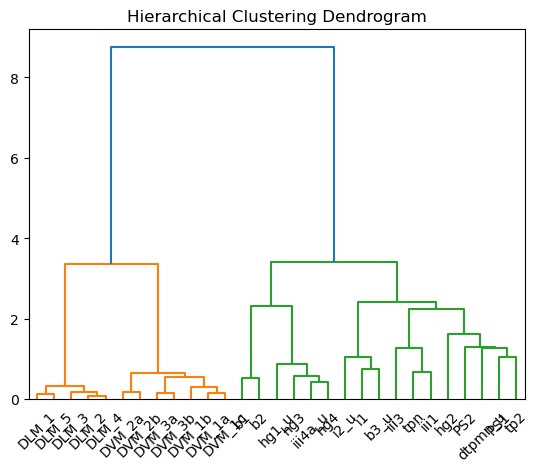

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import cluster 
from scipy.cluster.hierarchy import dendrogram
# sim_mat = cosine_similarity(wing_premn_to_mn_df.to_numpy().transpose())

# setting distance_threshold=0 ensures we compute the full tree.
model = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
# clustered_order = utils.plot_dendrogram(model, truncate_mode="level", p=12) # p truncate mode

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [model.children_, model.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
# dendrogram(linkage_matrix)
dend_dict = dendrogram(linkage_matrix,labels=col_df.MN)

# sorted order of indices found through clustering
clustered_order = dend_dict['ivl']
# plt.close()
fig.savefig('./figpanels/cluster_dengrogram_wing.svg',format='svg')

# clustered_order = np.array(clustered_order).astype(int) # convert strings into integers
print(clustered_order)


In [16]:
print(clustered_order)
clustered_reordered = [
    'DLM_1',
    'DLM_2',
    'DLM_3',
    'DLM_4',
    'DLM_5',
    'DVM_1a',
    'DVM_1b',
    'DVM_1c',
    'DVM_2a',
    'DVM_2b',
    'DVM_3a',
    'DVM_3b',
    'PS2',
    'dtpmn_u',
    'PS1',
    'tp2',
    'iii3',
    'tpn',
    'iii1',
    'i2_u',
    'i1',
    'b3_u',
    'b1',
    'b2',
    'hg2',
    'hg1_u',
    'hg3',
    'iii4a_u',
    'hg4'
]
print(clustered_reordered)

['DLM_1', 'DLM_5', 'DLM_3', 'DLM_2', 'DLM_4', 'DVM_2a', 'DVM_2b', 'DVM_3a', 'DVM_3b', 'DVM_1b', 'DVM_1a', 'DVM_1c', 'b1', 'b2', 'hg1_u', 'hg3', 'iii4a_u', 'hg4', 'i2_u', 'i1', 'b3_u', 'iii3', 'tpn', 'iii1', 'hg2', 'PS2', 'dtpmn_u', 'PS1', 'tp2']
['DLM_1', 'DLM_2', 'DLM_3', 'DLM_4', 'DLM_5', 'DVM_1a', 'DVM_1b', 'DVM_1c', 'DVM_2a', 'DVM_2b', 'DVM_3a', 'DVM_3b', 'PS2', 'dtpmn_u', 'PS1', 'tp2', 'iii3', 'tpn', 'iii1', 'i2_u', 'i1', 'b3_u', 'b1', 'b2', 'hg2', 'hg1_u', 'hg3', 'iii4a_u', 'hg4']


## Reorder wing matrix by cluster order 

In [17]:
reordered_wing = wing_premn_to_mn_df.copy()

col_idx = pd.Index(col_df.MN)
reordered_wing.columns = col_idx
reordered_wing = reordered_wing.loc[:,clustered_order]

col_midx_df = col_df.loc[clustered_order]
reordered_wing.columns = pd.MultiIndex.from_frame(col_midx_df)
reordered_wing.head()


re_reordered_wing = wing_premn_to_mn_df.copy()

col_idx = pd.Index(col_df.MN)
re_reordered_wing.columns = col_idx
re_reordered_wing = re_reordered_wing.loc[:,clustered_reordered]

col_midx_df = col_df.loc[clustered_reordered]
re_reordered_wing.columns = pd.MultiIndex.from_frame(col_midx_df)
re_reordered_wing.head()

MN                                                                     DLM_1  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk              79   
648518346459520004 DLM_2            uk        descending unk              20   
648518346490882081 DLM_2            uk        descending unk              20   
648518346492458683 DLM_2            uk        descending unk              21   
648518346504153324 DLM_2            uk        descending unk              25   

MN                                                                     DLM_2  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk             117   
648518346459520004 DLM_2            uk        descending unk              41   
648518346490882081 DLM_2            uk        descending unk              47   
648518346492458683 DLM_2            uk        descending unk              45   
648518346504153324 DLM_2            uk        descending unk              39   

MN                                                                     DLM_3  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk             101   
648518346459520004 DLM_2            uk        descending unk              22   
648518346490882081 DLM_2            uk        descending unk              25   
648518346492458683 DLM_2            uk        descending unk              27   
648518346504153324 DLM_2            uk        descending unk              22   

MN                                                                     DLM_4  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk              88   
648518346459520004 DLM_2            uk        descending unk              30   
648518346490882081 DLM_2            uk        descending unk              23   
648518346492458683 DLM_2            uk        descending unk              22   
648518346504153324 DLM_2            uk        descending unk              30   

MN                                                                     DLM_5  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk              69   
648518346459520004 DLM_2            uk        descending unk              25   
648518346490882081 DLM_2            uk        descending unk              28   
648518346492458683 DLM_2            uk        descending unk              25   
648518346504153324 DLM_2            uk        descending unk              27   

MN                                                                    DVM_1a  \
mod_num                                                                    1   
mod_name                                                             DVM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk              6

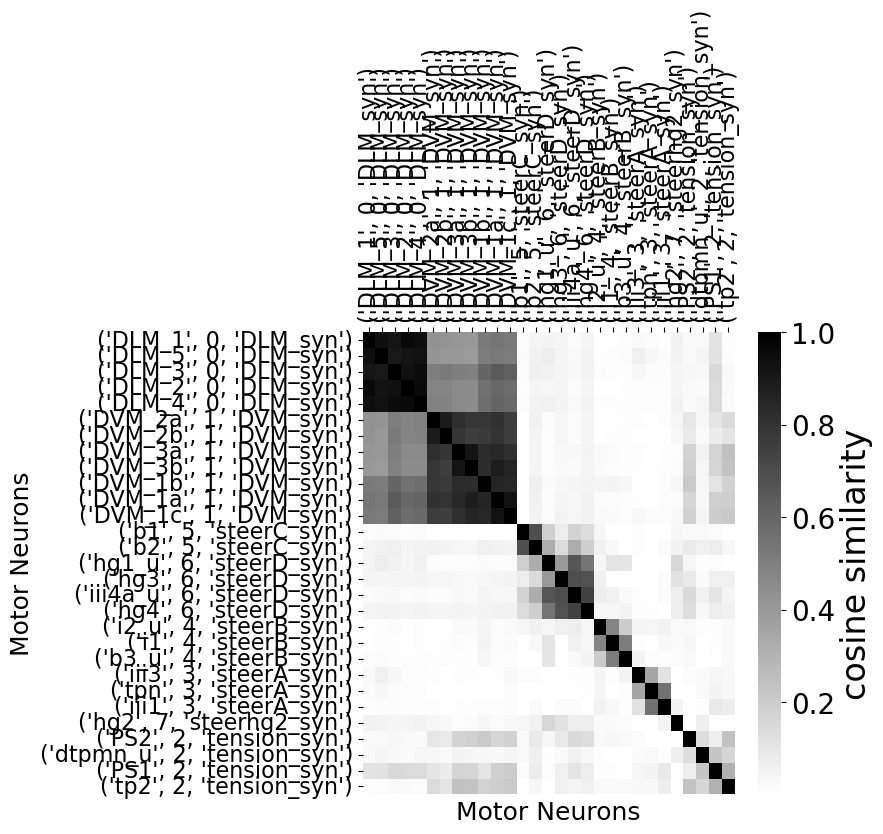

In [18]:
lbls = reordered_wing.columns.to_list()

sim_mat = cosine_similarity(reordered_wing.to_numpy().transpose())
fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(sim_mat, xticklabels=lbls, yticklabels=lbls,cmap=cos_cmap)
ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'cosine similarity', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
plt.ylabel('Motor Neurons', fontsize =18)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.show()
fig.savefig('./figpanels/cossim_wing_hierarchical_clustering_sns.svg',format='svg')

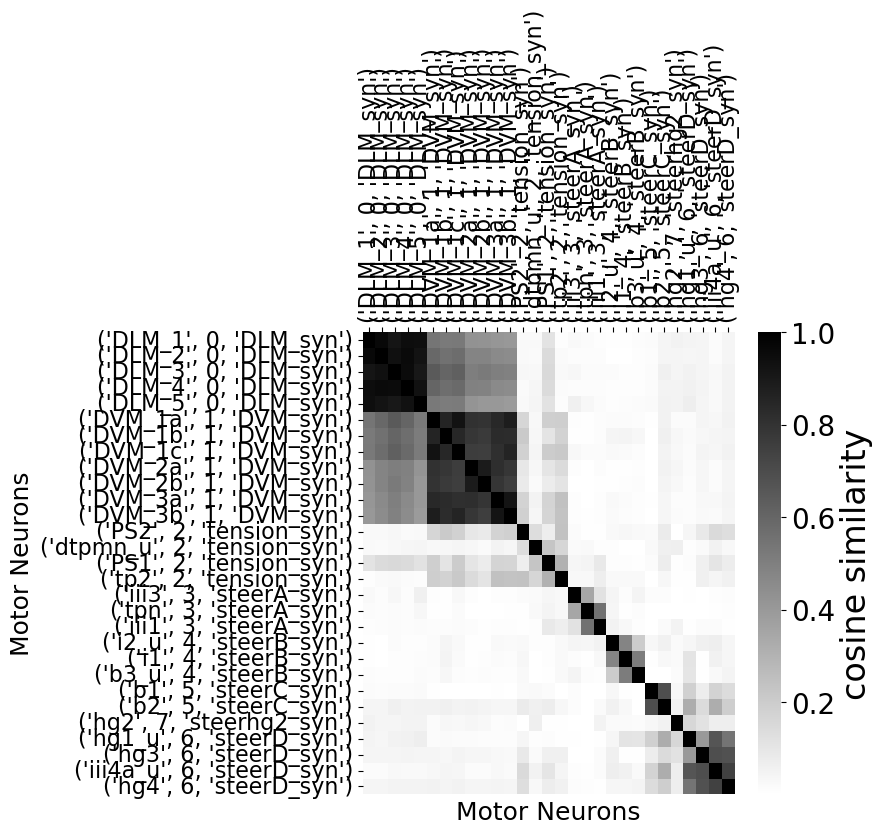

In [19]:
lbls = re_reordered_wing.columns.to_list()

sim_mat = cosine_similarity(re_reordered_wing.to_numpy().transpose())
fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(sim_mat, xticklabels=lbls, yticklabels=lbls,cmap=cos_cmap)
ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'cosine similarity', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
plt.ylabel('Motor Neurons', fontsize =18)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.show()

fig.savefig('./figpanels/cossim_wing_reordered_hierarchical_clustering_sns.svg',format='svg')

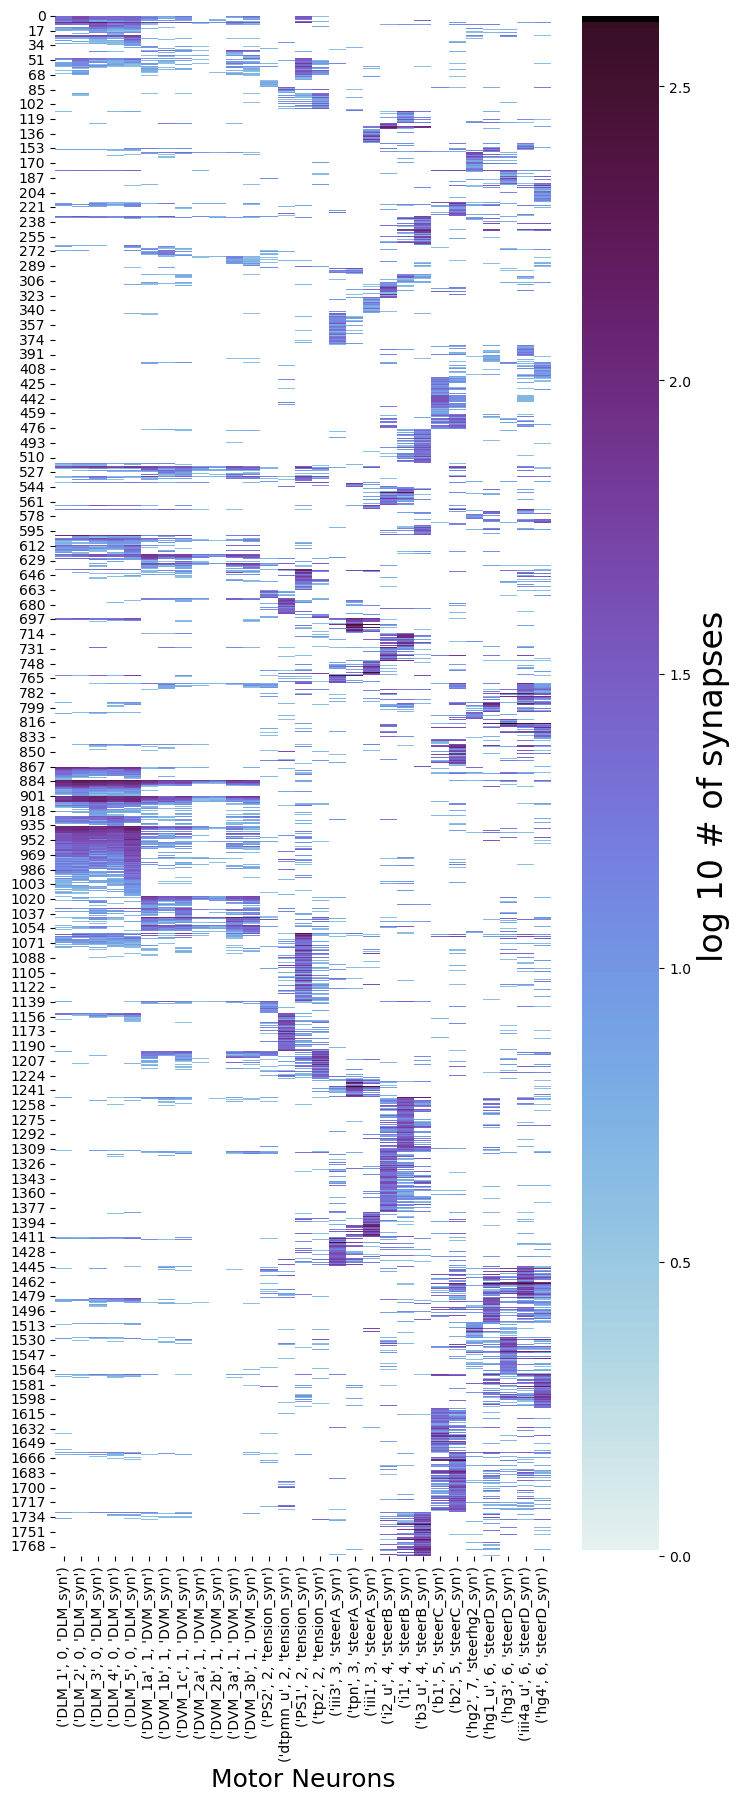

In [20]:
lbls = re_reordered_wing.columns.to_list()


fig = plt.figure(1, figsize = [8,20])
import cmocean
cmap_alt = cmocean.cm.dense
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(re_reordered_wing.to_numpy()+1), xticklabels=lbls, cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()

fig.savefig('./figpanels/cossim_hierarchical_clustering_wing_re_ordered.svg',format='svg')

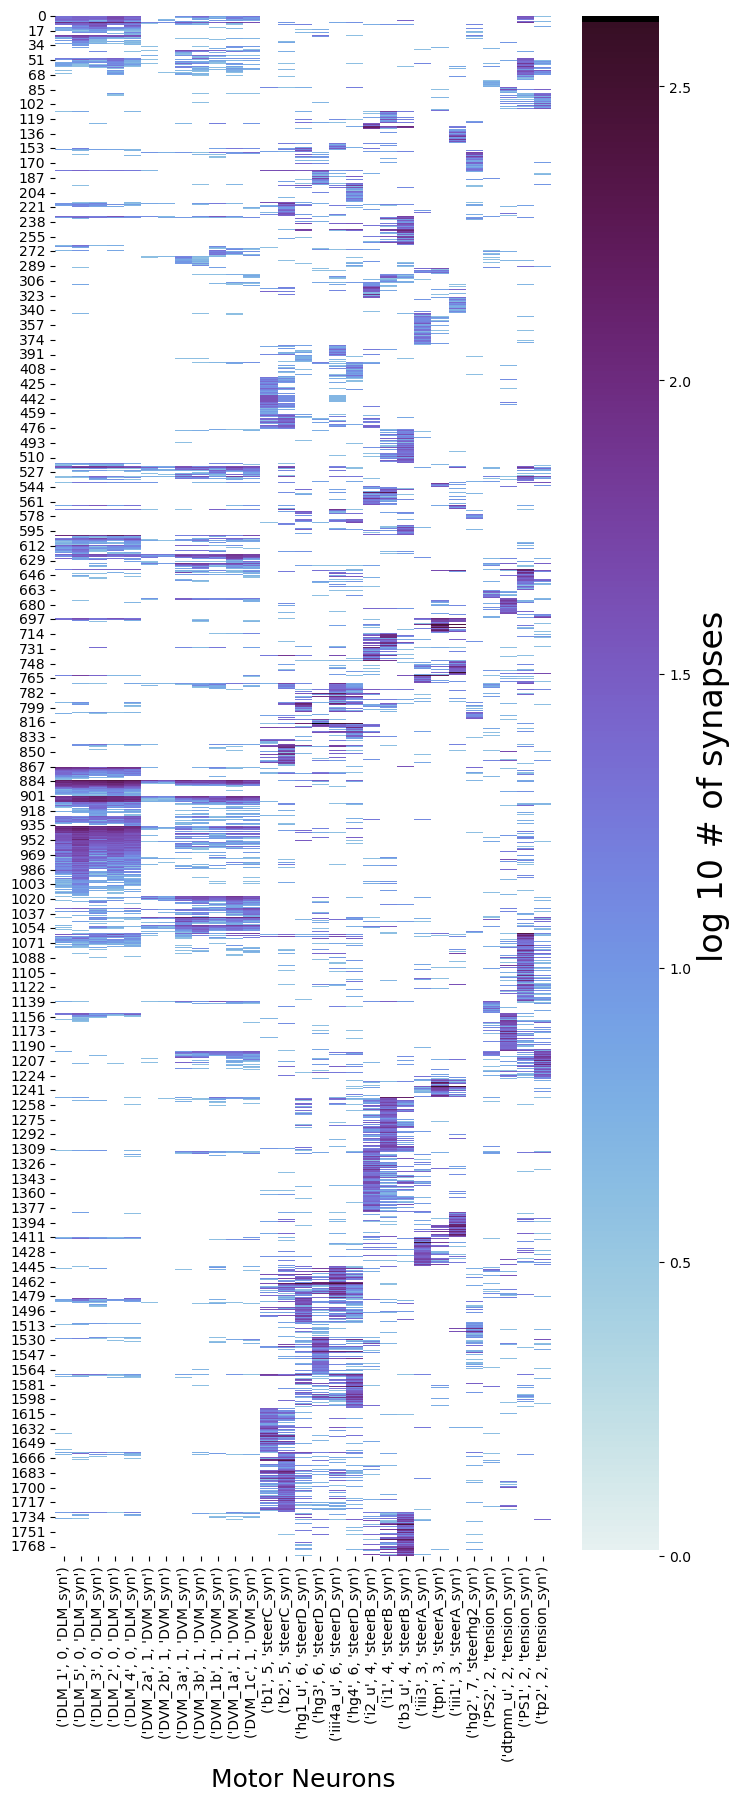

In [21]:
lbls = reordered_wing.columns.to_list()


fig = plt.figure(1, figsize = [8,20])
import cmocean
cmap_alt = cmocean.cm.dense
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(reordered_wing.to_numpy()+1), xticklabels=lbls, cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()

fig.savefig('./figpanels/cossim_hierarchical_clustering_wing_sns.svg',format='svg')

In [22]:
reordered_wing

MN                                                                     DLM_1  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk              79   
648518346459520004 DLM_2            uk        descending unk              20   
648518346490882081 DLM_2            uk        descending unk              20   
648518346492458683 DLM_2            uk        descending unk              21   
648518346504153324 DLM_2            uk        descending unk              25   
...                                                                      ...   
648518346514263774 b3_u             hlx16     local      unk               0   
648518346515510602 b3_u             6A        local      GABA              0   
648518346517402148 b3_u             6A        local      GABA              0   
648518346517422884 b3_u             12A       local      ACh               0   
648518346531262490 b3_u             6A        local      GABA              0   

MN                                                                     DLM_5  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk              69   
648518346459520004 DLM_2            uk        descending unk              25   
648518346490882081 DLM_2            uk        descending unk              28   
648518346492458683 DLM_2            uk        descending unk              25   
648518346504153324 DLM_2            uk        descending unk              27   
...                                                                      ...   
648518346514263774 b3_u             hlx16     local      unk               0   
648518346515510602 b3_u             6A        local      GABA              0   
648518346517402148 b3_u             6A        local      GABA              0   
648518346517422884 b3_u             12A       local      ACh               0   
648518346531262490 b3_u             6A        local      GABA              0   

MN                                                                     DLM_3  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk             101   
648518346459520004 DLM_2            uk        descending unk              22   
648518346490882081 DLM_2            uk        descending unk              25   
648518346492458683 DLM_2            uk        descending unk              27   
648518346504153324 DLM_2            uk        descending unk              22   
...                                                                      ...   
648518346514263774 b3_u             hlx16     local      unk               0   
648518346515510602 b3_u             6A        local      GABA              0   
648518346517402148 b3_u             6A        local      GABA              0   
648518346517422884 b3_u             12A       local      ACh               0   
648518346531262490 b3_u             6A        local      GABA              0   

MN                                                                     DLM_2  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk             117 

## Add level to column index for reorderedwing matrix

In [23]:
d = col_midx_df.to_dict()
mod_dict = d['mod_name']
reordered_cluster_names = reordered_wing.columns.get_level_values('mod_name').unique()
reordered_cluster_names

Index(['DLM_syn', 'DVM_syn', 'steerC_syn', 'steerD_syn', 'steerB_syn',
       'steerA_syn', 'steerhg2_syn', 'tension_syn'],
      dtype='object', name='mod_name')

In [24]:
row_idx = reordered_wing.index
row_idx_df = row_idx.to_frame().reset_index(drop=True)
row_idx_df['preferred_mn'] = row_idx_df['preferred_module']

for idx, row in row_idx_df.iterrows():
    row_idx_df.loc[idx,'preferred_module'] = mod_dict[row['preferred_mn']]

# Sort the 'preferred_module' column based on the reordered clusters
row_idx_df['preferred_module'] = row_idx_df['preferred_module'].astype(pd.CategoricalDtype(categories=reordered_cluster_names, ordered=True))
row_idx_df['cell_class'] = row_idx_df['cell_class'].astype(pd.CategoricalDtype(categories=['ascending', 'descending', 'sensory', 'local_intersegmental', 'local'], ordered=True))

row_idx = pd.MultiIndex.from_frame(row_idx_df)

In [25]:
row_idx_df.preferred_module.isna().sum()

0

In [26]:
reordered_wing.index = row_idx

reordered_wing = reordered_wing.sort_index(axis=0,level=[1],sort_remaining=False)
reordered_wing = reordered_wing.sort_index(axis=0,level=[3],sort_remaining=False)
reordered_wing

MN                                                                                  DLM_1  \
mod_num                                                                                 0   
mod_name                                                                          DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT preferred_mn           
648518346475807714 DLM_syn          uk        ascending  unk         DLM_2              8   
648518346489573207 DLM_syn          uk        ascending  unk         DLM_2              3   
648518346478901712 DLM_syn          uk        ascending  unk         DLM_2              4   
648518346504777587 DLM_syn          uk        ascending  unk         DLM_3             37   
648518346478664788 DLM_syn          uk        ascending  unk         DLM_3              4   
...                                                                                   ...   
648518346500883868 tension_syn      11B       local      GABA        tp2                0   
648518346501086486 tension_syn      17A       local      ACh         tp2                0   
648518346502422086 tension_syn      7B        local      ACh         tp2                0   
648518346504358124 tension_syn      17A       local      ACh         tp2                0   
648518346515177031 tension_syn      11B       local      GABA        tp2                0   

MN                                                                                  DLM_5  \
mod_num                                                                                 0   
mod_name                                                                          DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT preferred_mn           
648518346475807714 DLM_syn          uk        ascending  unk         DLM_2              9   
648518346489573207 DLM_syn          uk        ascending  unk         DLM_2              5   
648518346478901712 DLM_syn          uk        ascending  unk         DLM_2              0   
648518346504777587 DLM_syn          uk        ascending  unk         DLM_3             57   
648518346478664788 DLM_syn          uk        ascending  unk         DLM_3              3   
...                                                                                   ...   
648518346500883868 tension_syn      11B       local      GABA        tp2                0   
648518346501086486 tension_syn      17A       local      ACh         tp2                0   
648518346502422086 tension_syn      7B        local      ACh         tp2                0   
648518346504358124 tension_syn      17A       local      ACh         tp2                0   
648518346515177031 tension_syn      11B       local      GABA        tp2                0   

MN                                                                                  DLM_3  \
mod_num                                                                                 0   
mod_name                                                                          DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT preferred_mn           
648518346475807714 DLM_syn          uk        ascending  unk         DLM_2             14   
648518346489573207 DLM_syn          uk        ascending  unk         DLM_2              5   
648518346478901712 DLM_syn          uk        ascending  unk         DLM_2              4   
648518346504777587 DLM_syn          uk        ascending  unk         DLM_3             70   
648518346478664788 DLM_syn          uk        ascending  unk         DLM_3             13   
...                                                                                   ...   
648518346500883868 tension_syn      11B       local      GABA        tp2                0   
648518346501086486 tension_syn      17A       local      ACh         tp2                0   
648518346502422086 tension_syn      7B        local      ACh         tp2                0   

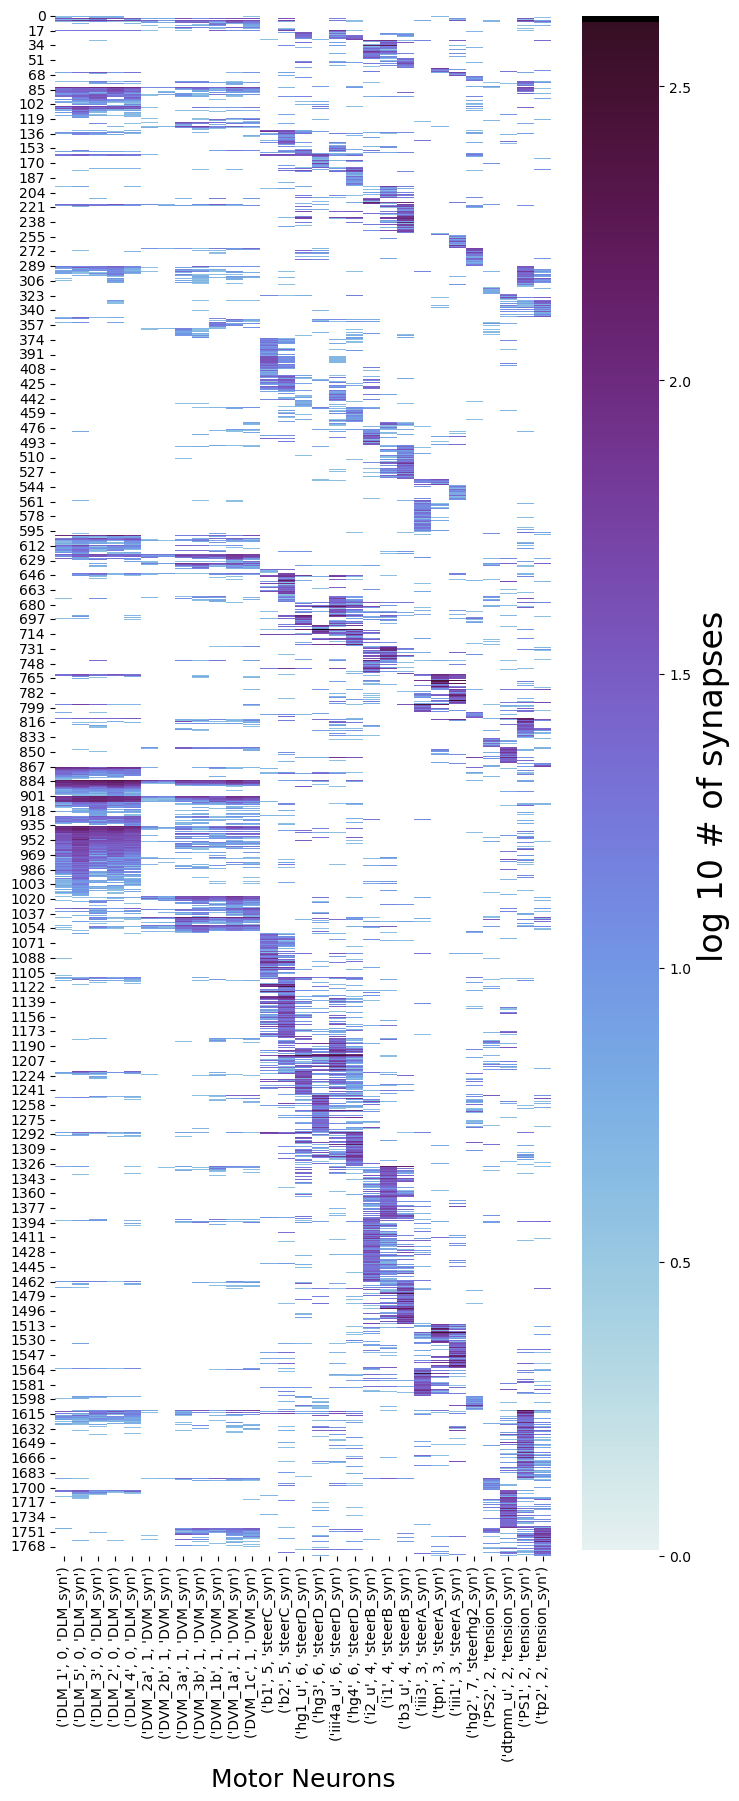

In [27]:
lbls = reordered_wing.columns.to_list()


fig = plt.figure(1, figsize = [8,20])
import cmocean
cmap_alt = cmocean.cm.dense
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(reordered_wing.to_numpy()+1), xticklabels=lbls, cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()

In [35]:
mod_pref_total_df = reordered_wing.T.groupby(level='mod_name',observed=True).sum().T
mod_pref_total_df = mod_pref_total_df.groupby(level='preferred_module',observed=True).sum()
mod_pref_total_df.loc[mod_pref_total_df.columns]

pd.Series(np.diag(mod_pref_total_df.loc[mod_pref_total_df.columns]), index=[mod_pref_total_df.index, mod_pref_total_df.columns]).sum()/mod_pref_total_df.sum().sum()

0.7570255784936479

# Plot AUC and distributions for Extended Data Figure 4

In [103]:
def plot_inout_cum(x_inpool_unsorted,x_outpool_unsorted=None,color = '#000000',color_out = '#CCCCCC',ref_x=None, fn=None,fignum=4,title=None,ax=None,xlabel = None):
    fig = plt.figure(fignum, figsize=(10, 6))
    if ax is None:
        ax = plt.subplot2grid((1,1),(0,0))
        ax.set_ylim([-.1, 1.1])
        ax.set_xlim([.945, .96])
        ax.set_xlim([0, 1])

    ax.set_ylabel('Cummulative fraction')
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    y = np.array(range(len(x_inpool_unsorted))).astype(float)/len(x_inpool_unsorted)
    ax.plot(sorted(x_inpool_unsorted),y,color=color)

    if not x_outpool_unsorted is None:
        y = np.array(range(len(x_outpool_unsorted))).astype(float)/len(x_outpool_unsorted)
        ax.plot(sorted(x_outpool_unsorted),y,color=color_out)

    if not ref_x is None:
        ax.plot(ref_x*np.array([1,1]),np.array([0,1]),color='#0000FF')
    else:
        ax.plot(x_inpool_unsorted.mean()*np.array([1,1]),np.array([0,1]),color=color)
        ax.plot(x_outpool_unsorted.mean()*np.array([1,1]),np.array([0,1]),color=color_out)

    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

    return ax

In [104]:
re_reordered_wing.head()

MN                                                                     DLM_1  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk              79   
648518346459520004 DLM_2            uk        descending unk              20   
648518346490882081 DLM_2            uk        descending unk              20   
648518346492458683 DLM_2            uk        descending unk              21   
648518346504153324 DLM_2            uk        descending unk              25   

MN                                                                     DLM_2  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk             117   
648518346459520004 DLM_2            uk        descending unk              41   
648518346490882081 DLM_2            uk        descending unk              47   
648518346492458683 DLM_2            uk        descending unk              45   
648518346504153324 DLM_2            uk        descending unk              39   

MN                                                                     DLM_3  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk             101   
648518346459520004 DLM_2            uk        descending unk              22   
648518346490882081 DLM_2            uk        descending unk              25   
648518346492458683 DLM_2            uk        descending unk              27   
648518346504153324 DLM_2            uk        descending unk              22   

MN                                                                     DLM_4  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk              88   
648518346459520004 DLM_2            uk        descending unk              30   
648518346490882081 DLM_2            uk        descending unk              23   
648518346492458683 DLM_2            uk        descending unk              22   
648518346504153324 DLM_2            uk        descending unk              30   

MN                                                                     DLM_5  \
mod_num                                                                    0   
mod_name                                                             DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk              69   
648518346459520004 DLM_2            uk        descending unk              25   
648518346490882081 DLM_2            uk        descending unk              28   
648518346492458683 DLM_2            uk        descending unk              25   
648518346504153324 DLM_2            uk        descending unk              27   

MN                                                                    DVM_1a  \
mod_num                                                                    1   
mod_name                                                             DVM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT           
648518346470309374 DLM_2            uk        descending unk              6

In [105]:
re_reordered_wing.index = re_reordered_wing.index.reorder_levels(order=['cell_class','preferred_module','cell_type','putative_NT','pre_pt_root_id'])
# split the re_reordered matrix into power vs. tension steering
All = slice(None)
power = re_reordered_wing.loc[:,(All, All, ['DLM_syn','DVM_syn'])]
steering = re_reordered_wing.loc[:,(All, All, ['tension_syn','steerA_syn','steerB_syn','steerC_syn','steerhg2_syn','steerD_syn'])]

In [106]:
re_reordered_wing.index.get_level_values('cell_class').unique()

CategoricalIndex(['descending', 'sensory', 'ascending', 'local_intersegmental',
                  'local'],
                 categories=['descending', 'sensory', 'ascending', 'local_intersegmental', 'local'], ordered=True, dtype='category', name='cell_class')

all_comps
local
desc
inter
asce
sense


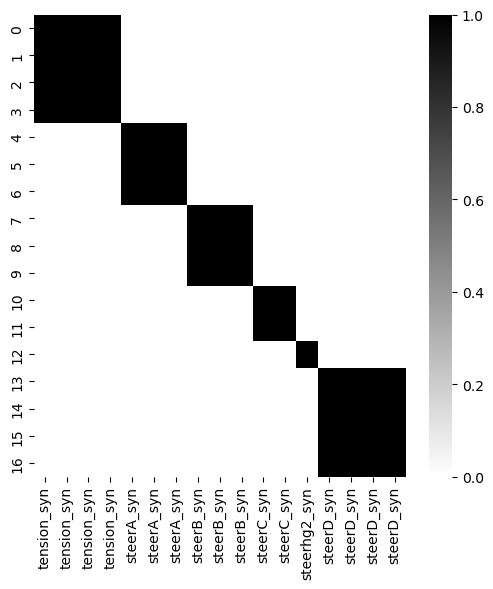

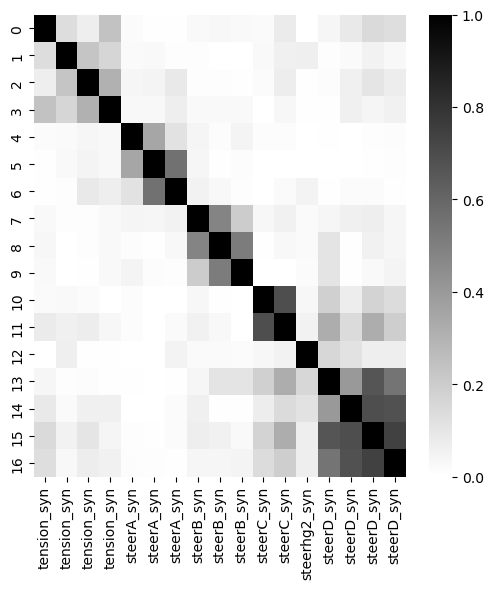

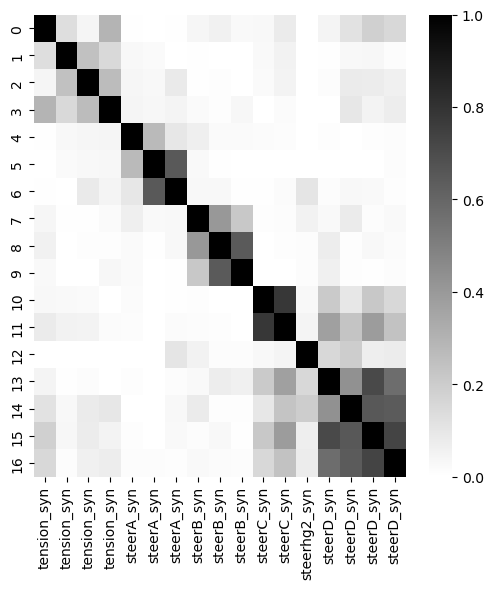

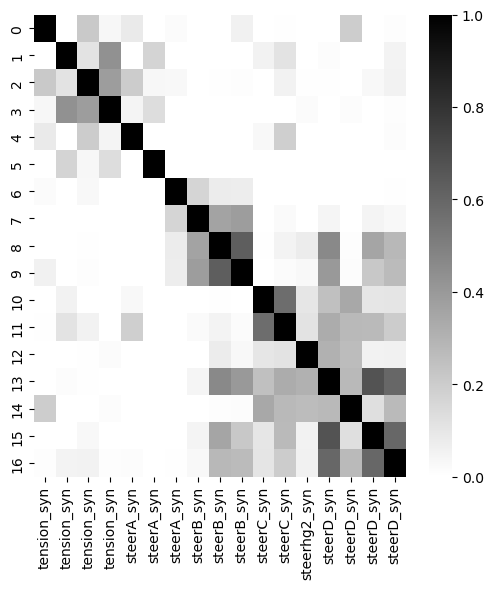

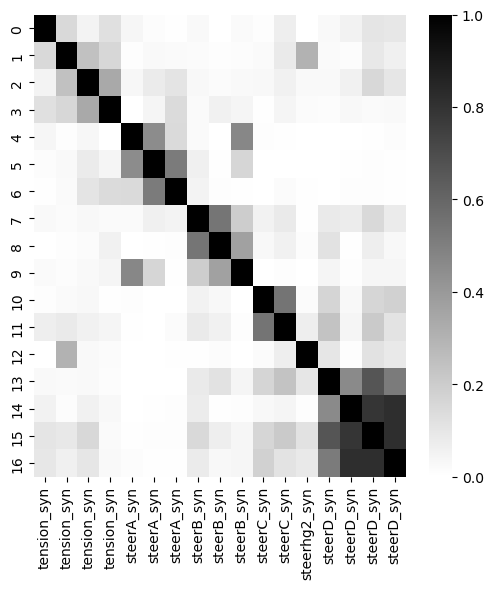

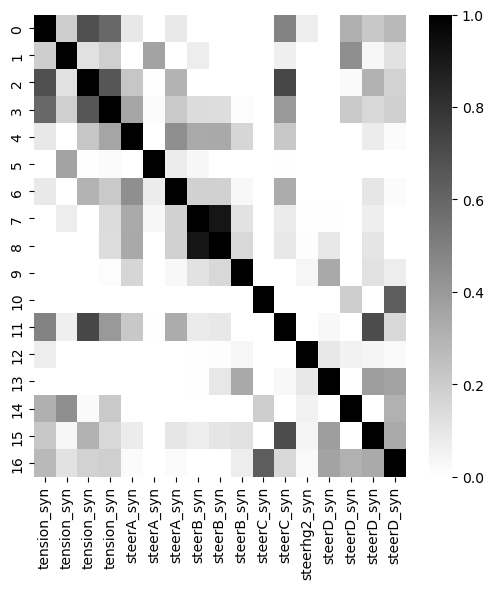

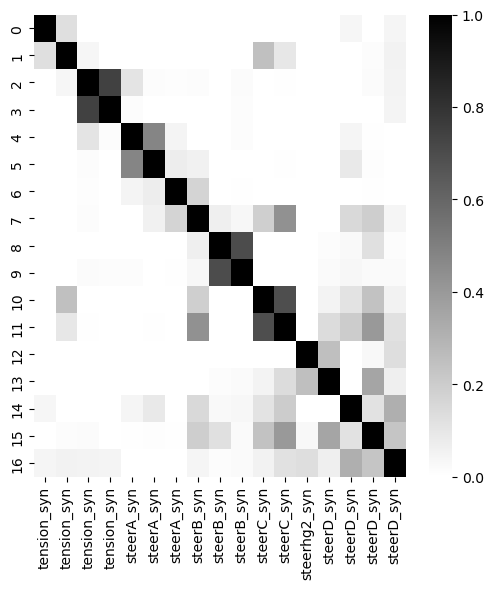

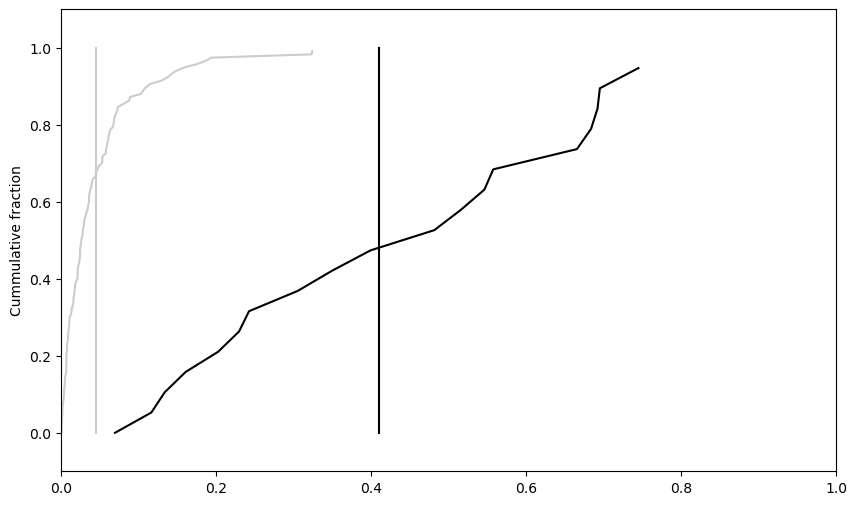

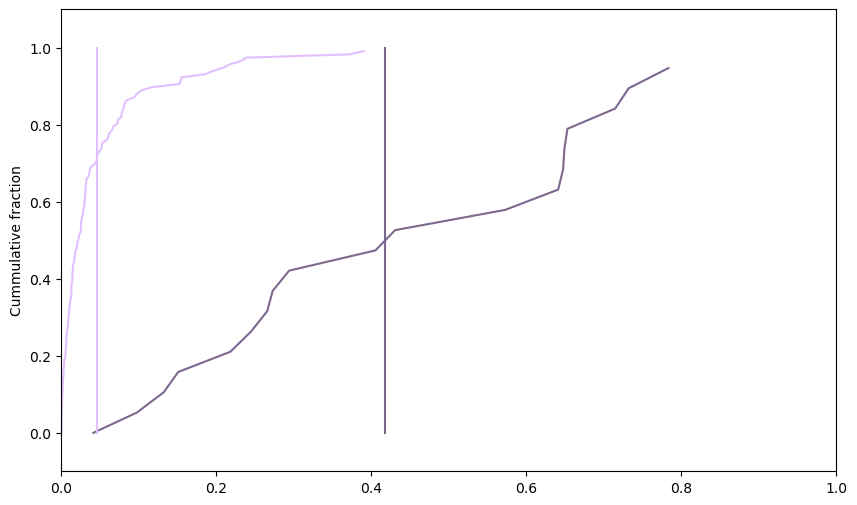

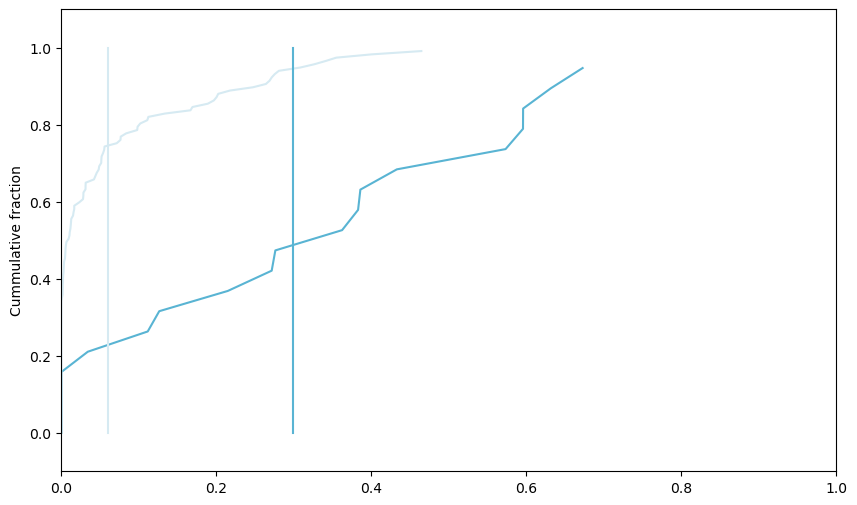

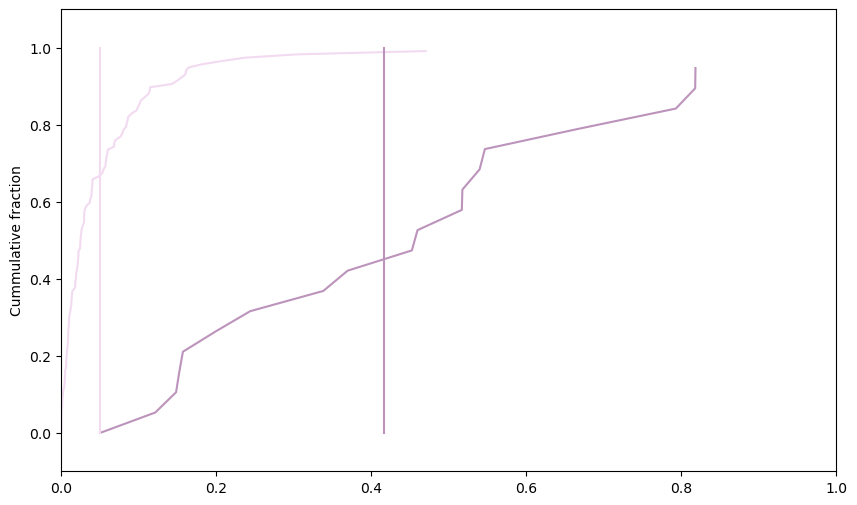

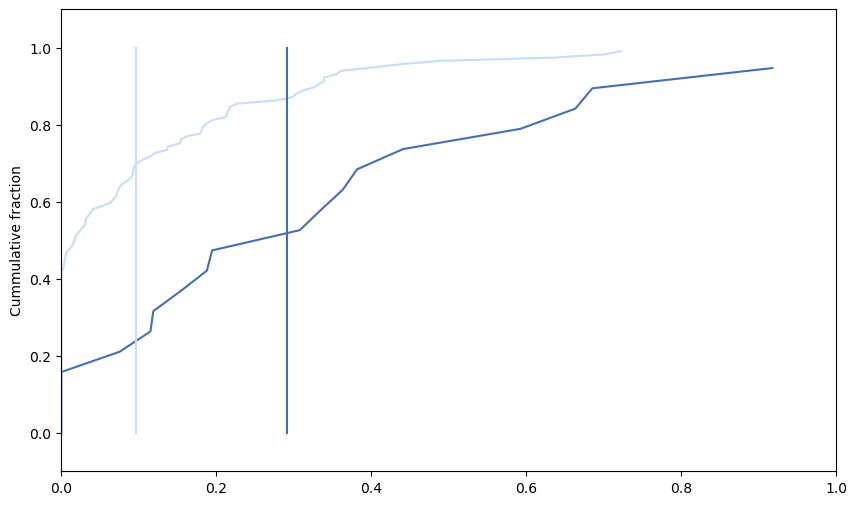

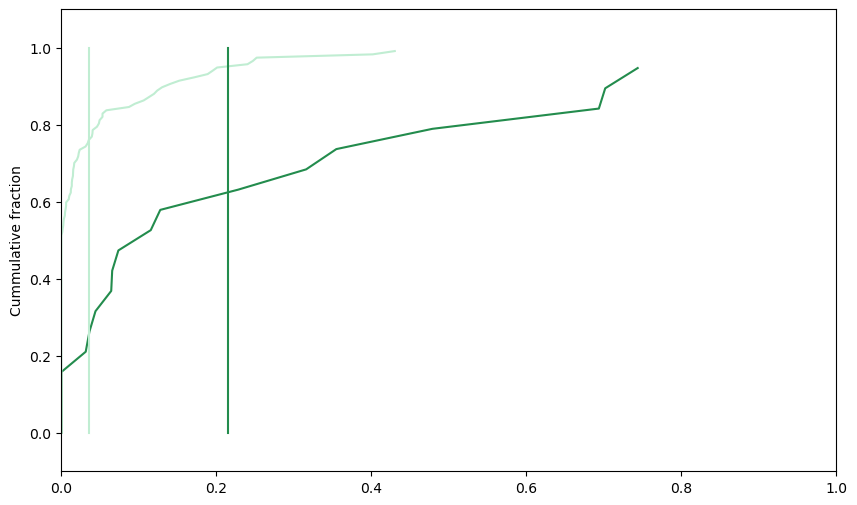

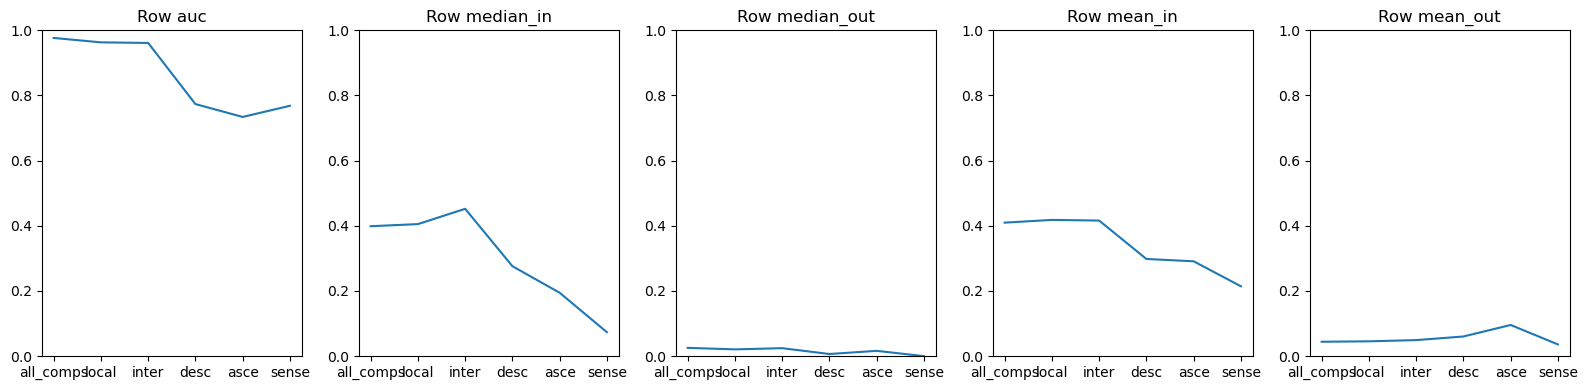

In [107]:
# power
# df = power.copy()
# df_string = 'power'
df = steering.copy()
df_string = 'steering'
mn_mi_df = df.columns.to_frame()
mn_mi_df

sim_mat_all = cosine_similarity(df.to_numpy().transpose())
sim_mat_local = cosine_similarity(df.loc['local',:].to_numpy().transpose())
sim_mat_desc = cosine_similarity(df.loc['descending',:].to_numpy().transpose())
sim_mat_inter = cosine_similarity(df.loc['local_intersegmental',:].to_numpy().transpose())
sim_mat_ascending = cosine_similarity(df.loc['ascending',:].to_numpy().transpose())
sim_mat_sensory = cosine_similarity(df.loc['sensory',:].to_numpy().transpose())

tril_mask = np.full((sim_mat_all.shape[0], sim_mat_all.shape[1]), True, dtype=bool)
motor_pool_mask = np.full((sim_mat_all.shape[0], sim_mat_all.shape[1]), False, dtype=bool)
i_index = np.full((sim_mat_all.shape[0], sim_mat_all.shape[1]), 0, dtype=int)
j_index = np.full((sim_mat_all.shape[0], sim_mat_all.shape[1]), 0, dtype=int)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].mod_name==mn_mi_df.iloc[j,:].mod_name)
        i_index[i,j] = i
        j_index[i,j] = j

fig = plt.figure(10, figsize = [6,6])
ax = sns.heatmap(motor_pool_mask, xticklabels=mn_mi_df.mod_name.to_list(),cmap=cos_cmap,vmin=0, vmax=1, )

fig = plt.figure(11, figsize = [6,6])
ax = sns.heatmap(sim_mat_all, xticklabels=mn_mi_df.mod_name.to_list(),cmap=cos_cmap,vmin=0, vmax=1)
fig.savefig('./figpanels/cos_sim_wing_all_grayscale.svg',format='svg')

fig = plt.figure(12, figsize = [6,6])
ax = sns.heatmap(sim_mat_local, xticklabels=mn_mi_df.mod_name.to_list(),cmap=cos_cmap,vmin=0, vmax=1)
fig.savefig('./figpanels/cos_sim_wing_local_grayscale.svg',format='svg')

fig = plt.figure(13, figsize = [6,6])
ax = sns.heatmap(sim_mat_desc, xticklabels=mn_mi_df.mod_name.to_list(),cmap=cos_cmap,vmin=0, vmax=1)
fig.savefig('./figpanels/cos_sim_wing_desc_grayscale.svg',format='svg')

fig = plt.figure(14, figsize = [6,6])
ax = sns.heatmap(sim_mat_inter, xticklabels=mn_mi_df.mod_name.to_list(),cmap=cos_cmap,vmin=0, vmax=1)
fig.savefig('./figpanels/cos_sim_wing_inter_grayscale.svg',format='svg')

fig = plt.figure(15, figsize = [6,6])
ax = sns.heatmap(sim_mat_ascending, xticklabels=mn_mi_df.mod_name.to_list(),cmap=cos_cmap,vmin=0, vmax=1)
fig.savefig('./figpanels/cos_sim_wing_asce_grayscale.svg',format='svg')

fig = plt.figure(16, figsize = [6,6])
ax = sns.heatmap(sim_mat_sensory, xticklabels=mn_mi_df.mod_name.to_list(),cmap=cos_cmap,vmin=0, vmax=1)
fig.savefig('./figpanels/cos_sim_wing_sensory_grayscale.svg',format='svg')

# fig = plt.figure(2, figsize = [6,6])
# ax = sns.heatmap(np.tril(motor_pool_mask,-1), xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=plt.get_cmap('Greys'))

tril_mask = np.tril(tril_mask,-1)

pool_arr = mn_mi_df.mod_name.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))
pool_arr.reshape(-1)
sim_dict = {
    'all_comps':sim_mat_all.reshape(-1),
    'local':sim_mat_local.reshape(-1),
    'desc':sim_mat_desc.reshape(-1),
    'inter':sim_mat_inter.reshape(-1),
    'asce':sim_mat_ascending.reshape(-1),
    'sense':sim_mat_sensory.reshape(-1),
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }


sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df
# # get rid of upper triangle
sim_compare_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]
sim_compare_df

mwu_df = sim_compare_df.iloc[0:4,:].copy()
mwu_df = mwu_df[['all_comps','local','desc','inter','asce','sense']]
mwu_df['idx'] = ['statistic','pvalue','comps','auc']
mwu_df = mwu_df.set_index('idx')
mwu_df

clr_dict = {'all_comps':'#000000',
            'local':'#7d688d',
            'desc':'#59b4d3',
            'inter':'#bc93bb',
            'asce':'#476fad',
            'sense':'#238c4d',}
clr2_dict = {'all_comps':'#cccccc',
            'local':'#e2c0ff',
            'desc':'#d6eaf2',
            'inter':'#f2daf1',
            'asce':'#cadcf9',
            'sense':'#c0edd2',}

ax = None
fig_cnt = 0
for col in mwu_df.columns:
# for col in ['all_comps','local']:
    print(col)
    y_in = sim_compare_df.loc[sim_compare_df['same_pool'],col]
    y_out = sim_compare_df.loc[~sim_compare_df['same_pool'],col]
    fig_cnt = fig_cnt+1
    ax = plot_inout_cum(y_in,
                x_outpool_unsorted=y_out, 
                color=clr_dict[col],
                color_out=clr2_dict[col],
                fignum=fig_cnt,
                fn = 'invout_cdf_{}_{}'.format(df_string,col))
    
    mwu_out = scipy.stats.mannwhitneyu(y_in,y_out)
    mwu_df.loc['statistic',col] = mwu_out.statistic
    mwu_df.loc['pvalue',col] = mwu_out.pvalue
    mwu_df.loc['comps',col] = (len(y_in)*len(y_out))
    mwu_df.loc['auc',col] = mwu_out.statistic / (len(y_in)*len(y_out))
    mwu_df.loc['median_in',col] = y_in.median()
    mwu_df.loc['median_out',col] = y_out.median()
    mwu_df.loc['mean_in',col] = y_in.mean()
    mwu_df.loc['mean_out',col] = y_out.mean()

mwu_df_plt = mwu_df.loc[['auc','median_in','median_out','mean_in','mean_out'],['all_comps','local','inter','desc','asce','sense']]
# Set up the subplots
fig, axs = plt.subplots(nrows=1, ncols=mwu_df_plt.shape[0], figsize=(2*mwu_df.shape[0],4))

# Plot each row in a separate subplot
for i, (row_name, data_row) in enumerate(mwu_df_plt.iterrows()):
    axs[i].plot(data_row.values)
    axs[i].set_xticks(range(len(data_row)))
    axs[i].set_xticklabels(data_row.index)
    axs[i].set_title(f'Row {row_name}')
    axs[i].set_ylim([0,1])

# Adjust layout for better visibility
plt.tight_layout()

# Show the plot
plt.show()

fig.savefig('./figpanels/cos_similarity_per_cell_class_{}.svg'.format(df_string),format='svg')

In [108]:
sim_mat_ascending.reshape(-1)

array([1.        , 0.19450936, 0.6850213 , 0.59230693, 0.09169259,
       0.        , 0.08740035, 0.00249251, 0.        , 0.        ,
       0.        , 0.48662745, 0.07184212, 0.        , 0.3109516 ,
       0.21754097, 0.27724929, 0.19450936, 1.        , 0.11857208,
       0.18767084, 0.        , 0.36098158, 0.        , 0.07097183,
       0.        , 0.        , 0.        , 0.06353049, 0.        ,
       0.        , 0.43786241, 0.03135958, 0.11475197, 0.6850213 ,
       0.11857208, 1.        , 0.6633455 , 0.22579534, 0.00402824,
       0.2980932 , 0.00324946, 0.        , 0.        , 0.        ,
       0.72150652, 0.        , 0.        , 0.02272066, 0.30280577,
       0.17933069, 0.59230693, 0.18767084, 0.6633455 , 1.        ,
       0.35491635, 0.01893966, 0.21266777, 0.13738945, 0.13660198,
       0.01415869, 0.        , 0.40061854, 0.        , 0.        ,
       0.21365242, 0.15317918, 0.18751504, 0.09169259, 0.        ,
       0.22579534, 0.35491635, 1.        , 0.        , 0.44071

# UMAP

In [109]:
# Normalize
pre_to_mn_L2_norm = reordered_wing.copy()
pre_to_mn_L1_norm = reordered_wing.copy()
for c in range(pre_to_mn_L2_norm.shape[1]):
    pre_to_mn_L2_norm.iloc[:,c] = pre_to_mn_L2_norm.iloc[:,c]/np.sqrt((pre_to_mn_L2_norm.iloc[:,c]**2).sum()) # L2 norm
    pre_to_mn_L2_norm.iloc[:,c] = pre_to_mn_L2_norm.iloc[:,c]/pre_to_mn_L2_norm.iloc[:,c].sum()

col_idx_df = reordered_wing.columns.to_frame()

(29, 2)


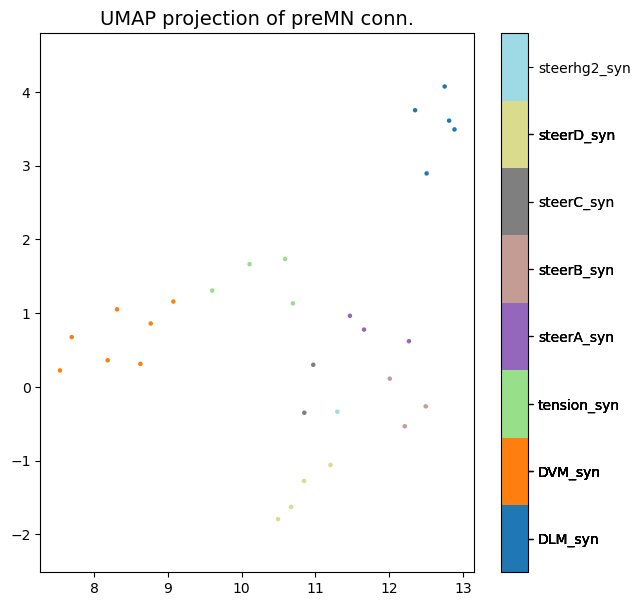

In [110]:
import umap
reducer = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=.2, n_components=2, n_epochs=None,
     n_neighbors=5, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

reducer.fit(pre_to_mn_L2_norm.T)
embedding = reducer.transform(pre_to_mn_L2_norm.T)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
print(embedding.shape)


fig, ax = plt.subplots(figsize=(7,7))
sp = ax.scatter(embedding[:, 0], embedding[:, 1], c = col_idx_df.mod_num.T, cmap='tab20', s=5)
colorbar = plt.colorbar(sp,boundaries=np.arange(0,9,1)-0.5)
colorbar.set_ticks(col_idx_df.mod_num.T)
colorbar.set_ticklabels(col_idx_df.mod_name.T)
ax.set_aspect('equal', 'datalim')
plt.title('UMAP projection of preMN conn.', fontsize=14);

col_idx_df[['embedding_1','embedding_2']] = embedding
# col_df = col_df.set_index(['preferred_pool','rank','segID'],drop=False)

# fig.savefig('./figpanels/UMAP_pre_to_mn.svg',format='svg')

# Order the synapse counts within modules
Start with just the local neurons

In [111]:
idx_df

pre_pt_root_id  \
pre_pt_root_id     preferred_module cell_type cell_class putative_NT                       
648518346470309374 DLM_2            uk        descending unk          648518346470309374   
648518346459520004 DLM_2            uk        descending unk          648518346459520004   
648518346490882081 DLM_2            uk        descending unk          648518346490882081   
648518346492458683 DLM_2            uk        descending unk          648518346492458683   
648518346504153324 DLM_2            uk        descending unk          648518346504153324   
...                                                                                  ...   
648518346514263774 b3_u             hlx16     local      unk          648518346514263774   
648518346515510602 b3_u             6A        local      GABA         648518346515510602   
648518346517402148 b3_u             6A        local      GABA         648518346517402148   
648518346517422884 b3_u             12A       local      ACh          648518346517422884   
648518346531262490 b3_u             6A        local      GABA         648518346531262490   

                                                                     preferred_module  \
pre_pt_root_id     preferred_module cell_type cell_class putative_NT                    
648518346470309374 DLM_2            uk        descending unk                    DLM_2   
648518346459520004 DLM_2            uk        descending unk                    DLM_2   
648518346490882081 DLM_2            uk        descending unk                    DLM_2   
648518346492458683 DLM_2            uk        descending unk                    DLM_2   
648518346504153324 DLM_2            uk        descending unk                    DLM_2   
...                                                                               ...   
648518346514263774 b3_u             hlx16     local      unk                     b3_u   
648518346515510602 b3_u             6A        local      GABA                    b3_u   
648518346517402148 b3_u             6A        local      GABA                    b3_u   
648518346517422884 b3_u             12A       local      ACh                     b3_u   
648518346531262490 b3_u             6A        local      GABA                    b3_u   

                                                                     cell_type  \
pre_pt_root_id     preferred_module cell_type cell_class putative_NT             
648518346470309374 DLM_2            uk        descending unk                uk   
648518346459520004 DLM_2            uk        descending unk                uk   
648518346490882081 DLM_2            uk        descending unk                uk   
648518346492458683 DLM_2            uk        descending unk                uk   
648518346504153324 DLM_2            uk        descending unk                uk   
...                                                                        ...   
648518346514263774 b3_u             hlx16     local      unk             hlx16   
648518346515510602 b3_u             6A        local      GABA               6A   
648518346517402148 b3_u             6A        local      GABA               6A   
648518346517422884 b3_u             12A       local      ACh               12A   
648518346531262490 b3_u             6A        local      GABA               6A   

                                                                      cell_class  \
pre_pt_root_id     preferred_module cell_type cell_class putative_NT               
648518346470309374 DLM_2            uk        descending unk          descending   
648518346459520004 DLM_2            uk        descending unk          descending   
648518346490882081 DLM_2            uk        descending unk          descending   
648518346492458683 DLM_2            uk        descending unk          descending   
648518346504153324 DLM_2            uk        descending unk          descending   
...                                                             

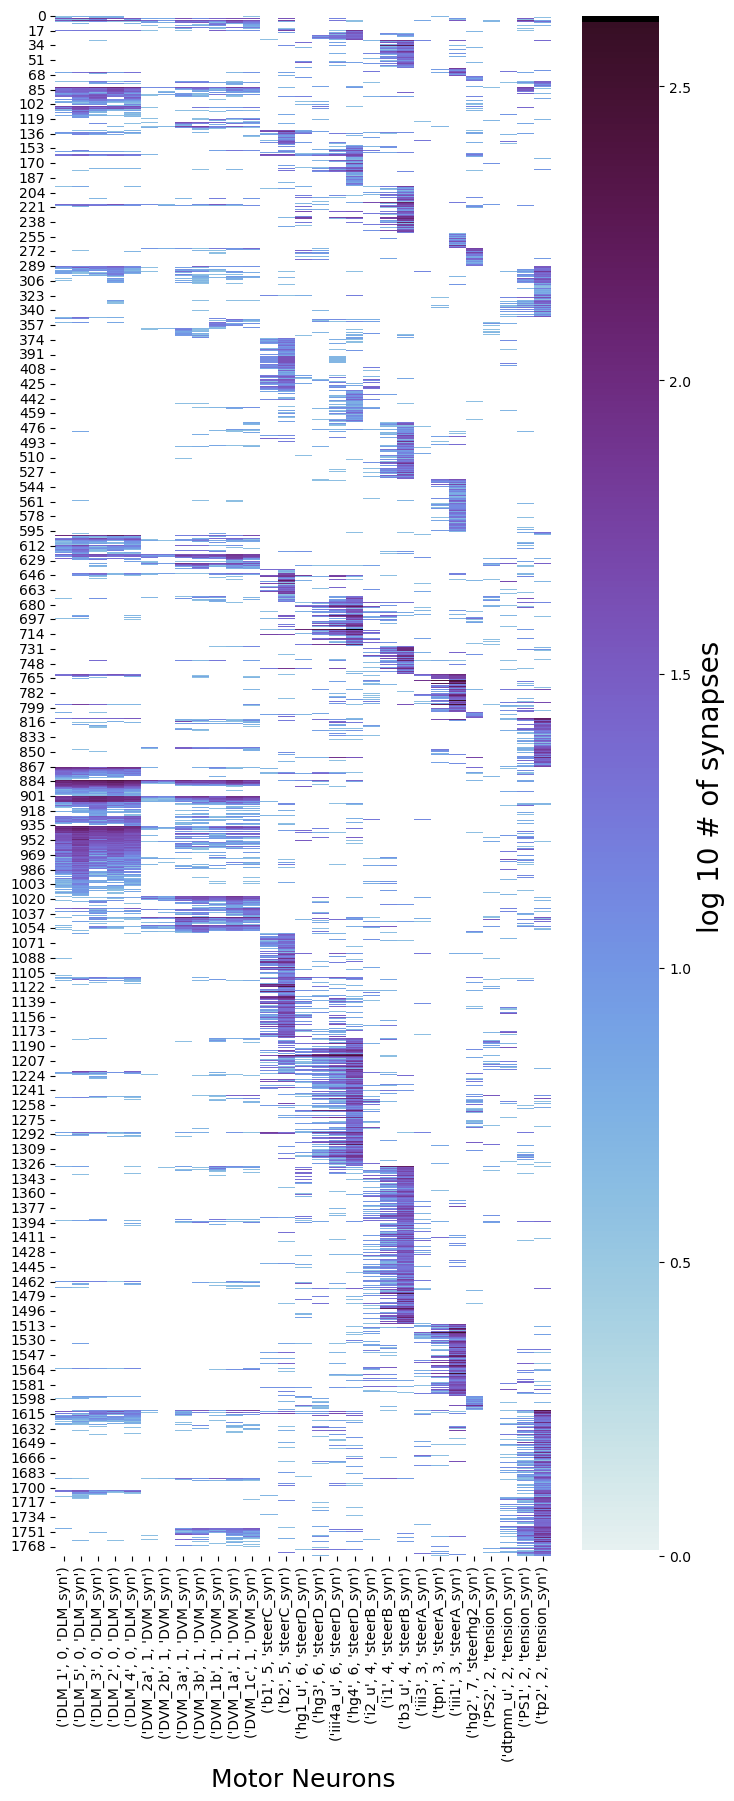

In [112]:
All = slice(None)
mod_keys = reordered_wing.columns.get_level_values('mod_name').unique()
cell_class = reordered_wing.index.get_level_values('cell_class').unique()
rowsorted_wing = reordered_wing.copy()
for c in cell_class:
    for mk in mod_keys:
        idx_slice = (All,mk,All,c,All)
        col_slice = (All,All,mk)
        if mk=='DLM_syn' or mk=='DVM_syn':
            continue

        try:
            sq_slice = reordered_wing.loc[idx_slice,col_slice].to_numpy()
        except KeyError:
            continue
        ro_slice = np.sort(sq_slice, axis=1)
        rowsorted_wing.loc[idx_slice,col_slice] = ro_slice
lbls = rowsorted_wing.columns.to_list()


fig = plt.figure(1, figsize = [8,20])
import cmocean
cmap_alt = cmocean.cm.dense
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(rowsorted_wing.to_numpy()+1), xticklabels=lbls, cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
cbar.set_label(label = 'log 10 # of synapses', size=20)
plt.xlabel('Motor Neurons', fontsize =18)
plt.show()

## Now run UMAP and cosine similarity on that.

(29, 2)


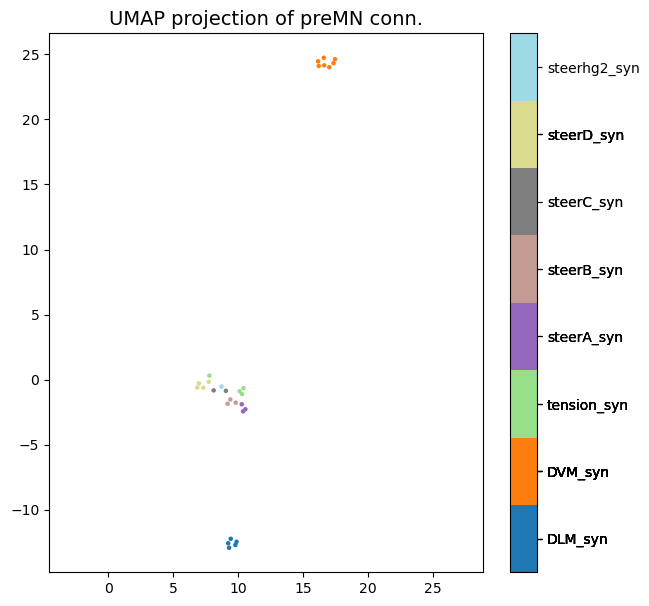

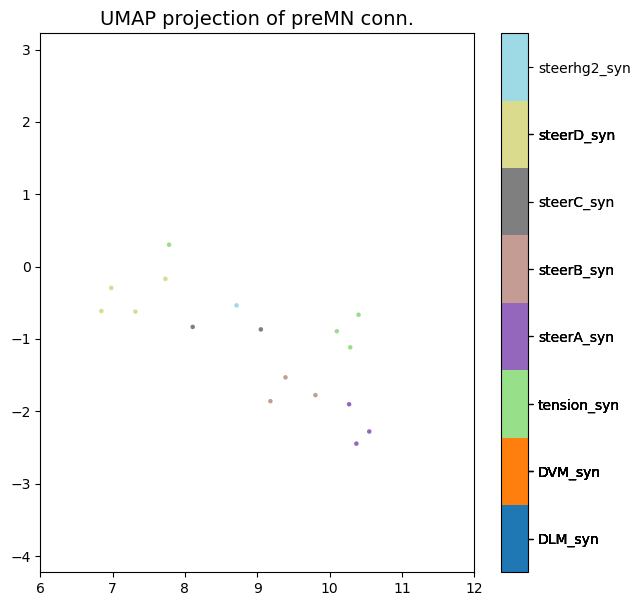

In [113]:
import umap

# Normalize
# local = rowsorted_wing.loc[(All,All,All,'local',All)]
local = rowsorted_wing
pre_to_mn_L2_norm = local.copy()
pre_to_mn_L1_norm = local.copy()
for c in range(pre_to_mn_L2_norm.shape[1]):
    pre_to_mn_L2_norm.iloc[:,c] = pre_to_mn_L2_norm.iloc[:,c]/np.sqrt((pre_to_mn_L2_norm.iloc[:,c]**2).sum()) # L2 norm
    pre_to_mn_L2_norm.iloc[:,c] = pre_to_mn_L2_norm.iloc[:,c]/pre_to_mn_L2_norm.iloc[:,c].sum()

reducer = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=.2, n_components=2, n_epochs=None,
     n_neighbors=5, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

reducer.fit(pre_to_mn_L2_norm.T)
embedding = reducer.transform(pre_to_mn_L2_norm.T)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
print(embedding.shape)


fig, ax = plt.subplots(figsize=(7,7))
sp = ax.scatter(embedding[:, 0], embedding[:, 1], c = col_idx_df.mod_num.T, cmap='tab20', s=5)
colorbar = plt.colorbar(sp,boundaries=np.arange(0,9,1)-0.5)
colorbar.set_ticks(col_idx_df.mod_num.T)
colorbar.set_ticklabels(col_idx_df.mod_name.T)
ax.set_aspect('equal', 'datalim')
plt.title('UMAP projection of preMN conn.', fontsize=14);

col_idx_df[['embedding_1','embedding_2']] = embedding
# col_df = col_df.set_index(['preferred_pool','rank','segID'],drop=False)

# fig.savefig('./figpanels/UMAP_pre_to_mn.svg',format='svg')

fig, ax = plt.subplots(figsize=(7,7))
sp = ax.scatter(embedding[:, 0], embedding[:, 1], c = col_idx_df.mod_num.T, cmap='tab20', s=5)
colorbar = plt.colorbar(sp,boundaries=np.arange(0,9,1)-0.5)
colorbar.set_ticks(col_idx_df.mod_num.T)
colorbar.set_ticklabels(col_idx_df.mod_name.T)
ax.set_aspect('equal', 'datalim')
ax.set_xlim([6,12])
ax.set_ylim([-4,3])
plt.title('UMAP projection of preMN conn.', fontsize=14);

col_idx_df[['embedding_1','embedding_2']] = embedding
# col_df = col_df.set_index(['preferred_pool','rank','segID'],drop=False)

# fig.savefig('./figpanels/UMAP_pre_to_mn.svg',format='svg')

## Cosine similarity

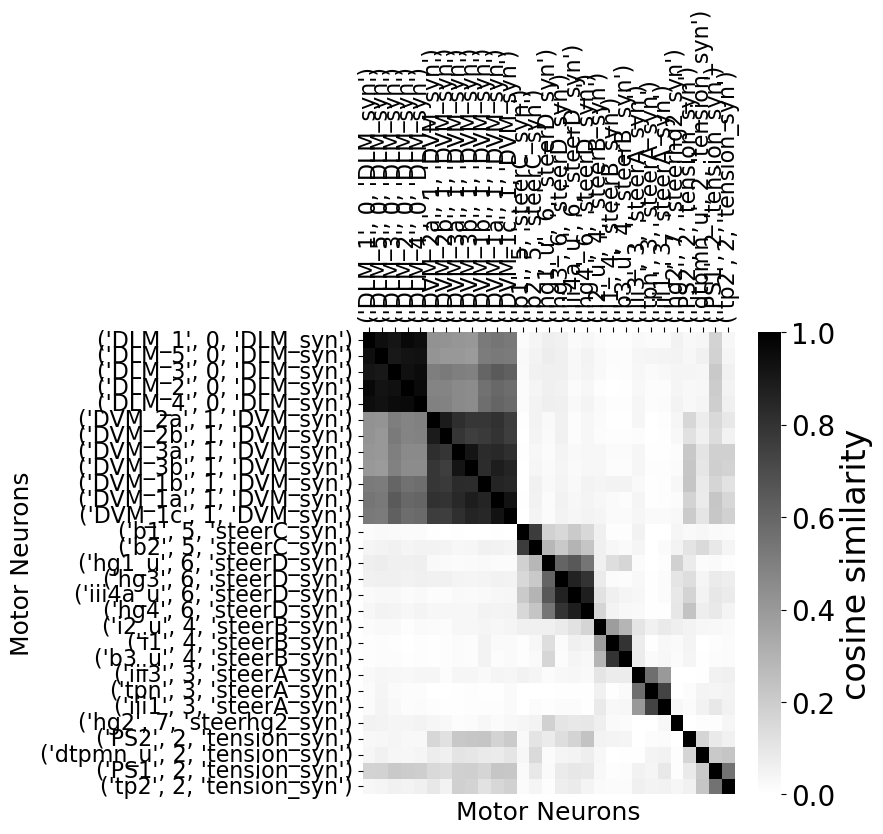

In [114]:
lbls = rowsorted_wing.columns.to_list()

sim_mat = cosine_similarity(rowsorted_wing.to_numpy().transpose())
fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(sim_mat, xticklabels=lbls, yticklabels=lbls,cmap=cos_cmap)
ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'cosine similarity', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
plt.ylabel('Motor Neurons', fontsize =18)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.show()

## Compare cosine similarity distributions within and across modules   

0.9697752808988764

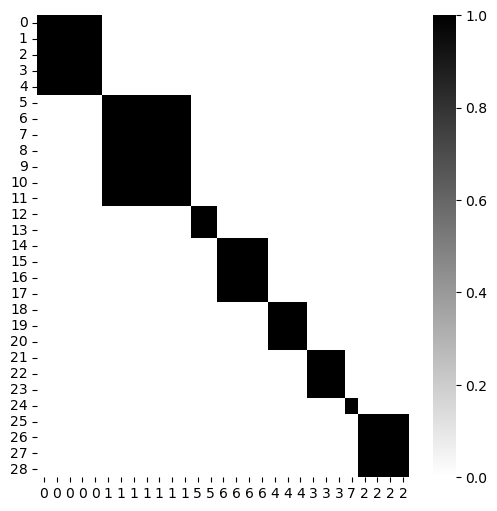

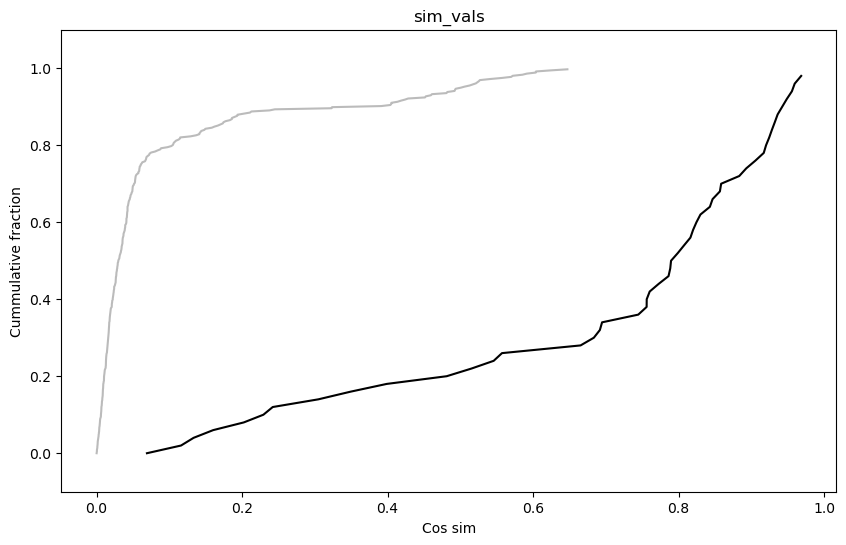

In [115]:
mn_mi_df = reordered_wing.columns.to_frame() # rowsorted_wing
mn_mi_df

sim_mat = cosine_similarity(reordered_wing.to_numpy().transpose())

tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
motor_pool_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), False, dtype=bool)
i_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
j_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].mod_num==mn_mi_df.iloc[j,:].mod_num)
        i_index[i,j] = i
        j_index[i,j] = j

fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(motor_pool_mask, xticklabels=mn_mi_df.mod_num.to_list(),cmap=cos_cmap)
# clean_hmax(ax)
# fig = plt.figure(2, figsize = [6,6])
# ax = sns.heatmap(np.tril(motor_pool_mask,-1), xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=cos_cmap)


tril_mask = np.tril(tril_mask,-1)

pool_arr = mn_mi_df.mod_num.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))

sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }

sim_compare_df_full = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df_full['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_df = sim_compare_df_full.loc[sim_compare_df_full.lower_tri.to_numpy()]

idx = 'sim_vals'

# def plot_shuf_cum(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None):
fig = plt.figure(2, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
# ax.set_xlim([.945, .96])
# ax.set_xlim([0, 1])
ax.set_ylabel('Cummulative fraction')
ax.set_xlabel('Cos sim')
ax.set_title(idx)

x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_outofpool))).astype(float)/len(x_outofpool)
ax.plot(sorted(x_outofpool),y,color='#BBBBBB')

x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_inpool))).astype(float)/len(x_inpool)
ax.plot(sorted(x_inpool),y,color='#000000')

fig.savefig('./figpanels/cdf_sim_ta_assigned_pools_coxa_ab.svg',format='svg')

ks_val = scipy.stats.kstest(x_inpool,x_outofpool)
mwu_out = scipy.stats.mannwhitneyu(x_inpool,x_outofpool)
mwu_val = (mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))

mwu_val

## Distributions for rowsorted_wing

0.9726404494382023

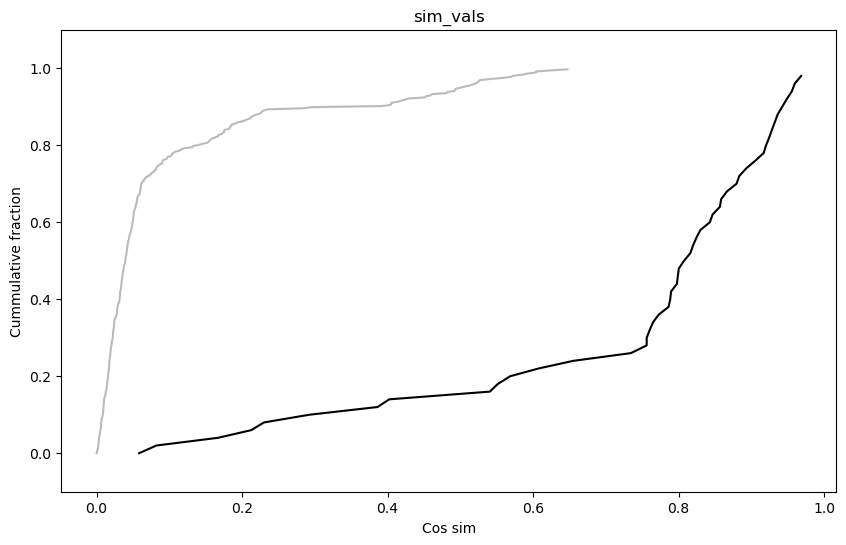

In [116]:
sim_mat = cosine_similarity(rowsorted_wing.to_numpy().transpose())
sim_compare_df_full['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_df = sim_compare_df_full.loc[sim_compare_df_full.lower_tri.to_numpy()]

idx = 'sim_vals'

# def plot_shuf_cum(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None):
fig = plt.figure(2, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
# ax.set_xlim([.945, .96])
# ax.set_xlim([0, 1])
ax.set_ylabel('Cummulative fraction')
ax.set_xlabel('Cos sim')
ax.set_title(idx)

x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_outofpool))).astype(float)/len(x_outofpool)
ax.plot(sorted(x_outofpool),y,color='#BBBBBB')

x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_inpool))).astype(float)/len(x_inpool)
ax.plot(sorted(x_inpool),y,color='#000000')

fig.savefig('./figpanels/cdf_sim_ta_assigned_pools_coxa_ab.svg',format='svg')

ks_val = scipy.stats.kstest(x_inpool,x_outofpool)
mwu_out = scipy.stats.mannwhitneyu(x_inpool,x_outofpool)
mwu_val = (mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))

mwu_val

## No indirects

0.9766081871345029

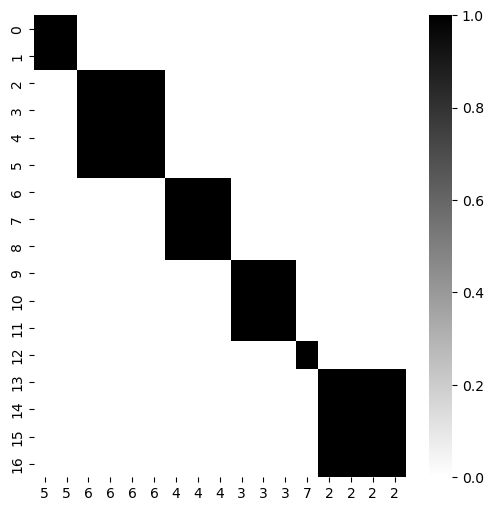

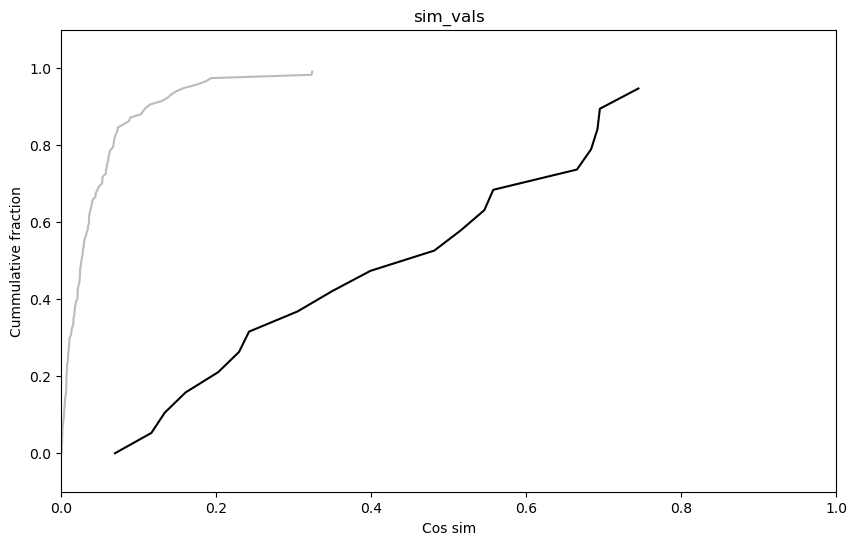

In [117]:
syn_filter = ['DLM_syn', 'DVM_syn', 'tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerhg2_syn', 'steerD_syn']
syn_filter = ['tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerhg2_syn', 'steerD_syn']
directs_only = reordered_wing.loc[:,reordered_wing.columns.get_level_values('mod_name').isin(syn_filter)]
mn_mi_df = directs_only.columns.to_frame() # rowsorted_wing
mn_mi_df

sim_mat = cosine_similarity(directs_only.to_numpy().transpose())

tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
motor_pool_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), False, dtype=bool)
i_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
j_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].mod_num==mn_mi_df.iloc[j,:].mod_num)
        i_index[i,j] = i
        j_index[i,j] = j

fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(motor_pool_mask, xticklabels=mn_mi_df.mod_num.to_list(),cmap=cos_cmap)
# clean_hmax(ax)
# fig = plt.figure(2, figsize = [6,6])
# ax = sns.heatmap(np.tril(motor_pool_mask,-1), xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=cos_cmap)


tril_mask = np.tril(tril_mask,-1)

pool_arr = mn_mi_df.mod_num.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))

sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }

sim_compare_df_full = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df_full['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_df = sim_compare_df_full.loc[sim_compare_df_full.lower_tri.to_numpy()]

idx = 'sim_vals'

# def plot_shuf_cum(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None):
fig = plt.figure(2, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
# ax.set_xlim([.945, .96])
ax.set_xlim([0, 1])
ax.set_ylabel('Cummulative fraction')
ax.set_xlabel('Cos sim')
ax.set_title(idx)

x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_outofpool))).astype(float)/len(x_outofpool)
ax.plot(sorted(x_outofpool),y,color='#BBBBBB')

x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_inpool))).astype(float)/len(x_inpool)
ax.plot(sorted(x_inpool),y,color='#000000')

fig.savefig('./figpanels/cdf_sim_directs_wing.svg',format='svg')

ks_val = scipy.stats.kstest(x_inpool,x_outofpool)
mwu_out = scipy.stats.mannwhitneyu(x_inpool,x_outofpool)
mwu_val = (mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))

mwu_val_max = mwu_val
mwu_val_max

## Compare to row_sorted

0.9613135402609086

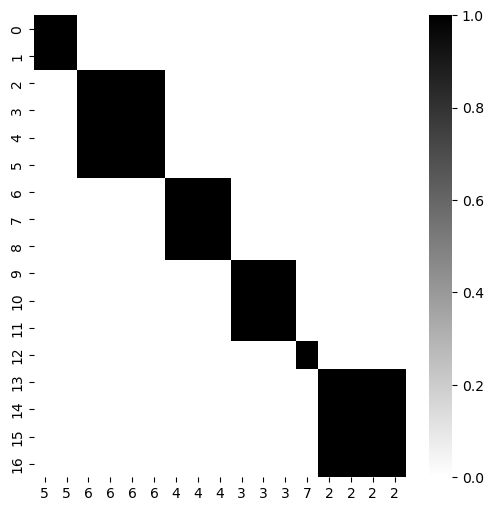

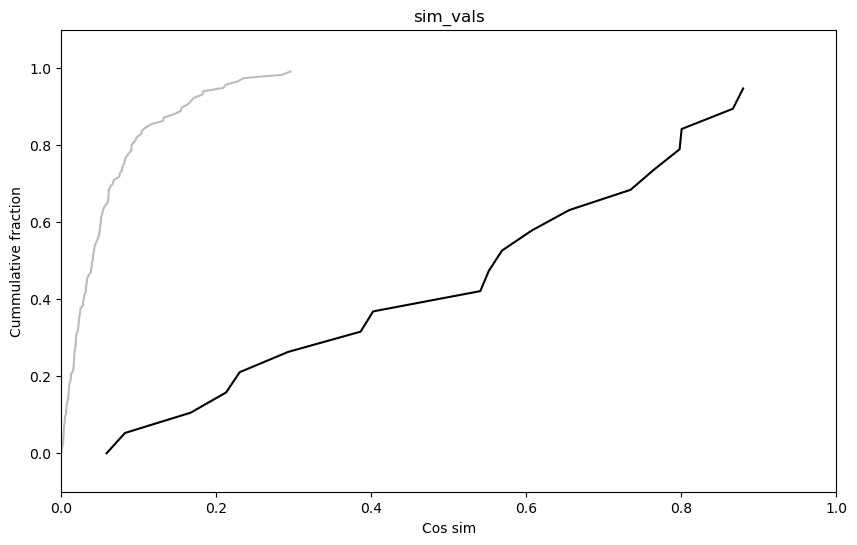

In [118]:
syn_filter = ['DLM_syn', 'DVM_syn', 'tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerhg2_syn', 'steerD_syn']
syn_filter = ['tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerhg2_syn', 'steerD_syn']
directs_only = rowsorted_wing.loc[:,rowsorted_wing.columns.get_level_values('mod_name').isin(syn_filter)]
mn_mi_df = directs_only.columns.to_frame() # rowsorted_wing
mn_mi_df

sim_mat = cosine_similarity(directs_only.to_numpy().transpose())

tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
motor_pool_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), False, dtype=bool)
i_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
j_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].mod_num==mn_mi_df.iloc[j,:].mod_num)
        i_index[i,j] = i
        j_index[i,j] = j

fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(motor_pool_mask, xticklabels=mn_mi_df.mod_num.to_list(),cmap=cos_cmap)
# clean_hmax(ax)
# fig = plt.figure(2, figsize = [6,6])
# ax = sns.heatmap(np.tril(motor_pool_mask,-1), xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=cos_cmap)


tril_mask = np.tril(tril_mask,-1)

pool_arr = mn_mi_df.mod_num.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))

sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }

sim_compare_df_full = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df_full['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_df = sim_compare_df_full.loc[sim_compare_df_full.lower_tri.to_numpy()]

idx = 'sim_vals'

# def plot_shuf_cum(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None):
fig = plt.figure(2, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
# ax.set_xlim([.945, .96])
ax.set_xlim([0, 1])
ax.set_ylabel('Cummulative fraction')
ax.set_xlabel('Cos sim')
ax.set_title(idx)

x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_outofpool))).astype(float)/len(x_outofpool)
ax.plot(sorted(x_outofpool),y,color='#BBBBBB')

x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],idx]

y = np.array(range(len(x_inpool))).astype(float)/len(x_inpool)
ax.plot(sorted(x_inpool),y,color='#000000')

fig.savefig('./figpanels/cdf_sim_directs_wing.svg',format='svg')

ks_val = scipy.stats.kstest(x_inpool,x_outofpool)
mwu_out = scipy.stats.mannwhitneyu(x_inpool,x_outofpool)
mwu_val = (mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))

mwu_val_max = mwu_val
mwu_val_max

Compared to the actual values, sorting the rows doen't do a whole lot, actually. It stretches out the distribution a bit, so that most values are a little higher.

# Remove each MN from its module and recompute mvu_val

In [119]:
# mwu_val = []

# for sid in mn_mi_df.MN:
#     mn_mi_df_holdout = mn_mi_df.copy()
#     mn_mi_df_holdout.loc[mn_mi_df_holdout.MN==sid,'mod_name'] = 'hold_out'

#     motor_pool_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), False, dtype=bool)
#     for i in range(motor_pool_mask.shape[0]):
#         for j in range(motor_pool_mask.shape[1]):
#             motor_pool_mask[i,j] =(mn_mi_df_holdout.iloc[i,:].mod_name==mn_mi_df_holdout.iloc[j,:].mod_name)

#     tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
#     tril_mask = np.tril(tril_mask,-1)
#     pool_arr = mn_mi_df_holdout.mod_name.to_numpy()
#     pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))
#     sim_dict = {
#         'pool':pool_arr.reshape(-1),
#         'same_pool': motor_pool_mask.reshape(-1),
#         'lower_tri':tril_mask.reshape(-1),
#         'i_index':i_index.reshape(-1),
#         'j_index':j_index.reshape(-1)
#         }

#     sim_compare_df_full = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
#     sim_compare_df_full['sim_vals'] = sim_mat.reshape(-1)
#     # # get rid of upper triangle
#     sim_compare_df = sim_compare_df_full.loc[sim_compare_df_full.lower_tri.to_numpy()]

#     idx = 'sim_vals'
#     x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],idx]
#     x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],idx]
#     mwu_out = scipy.stats.mannwhitneyu(x_inpool,x_outofpool)
#     mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))

#     print('Hold out MN {}: {} vs. {}'.format(sid,mwu_val_max,mwu_out.statistic / (len(x_inpool)*len(x_outofpool))))

# # add the mwu_val to the dataframe
# mn_mi_df_holdout['mwu_holdout_auc'] = mwu_val

# # plot the MWU AUC curves
# fig = plt.figure(3, figsize=(10, 6))
# ax = plt.subplot()
# # ax.set_ylim([.992, 0.999])
# ax.set_ylabel('MWU AUC value')
# ax.set_xlabel('MN')
# ax.set_title('Hold out each MN')

# ax.plot([0,mn_mi_df.shape[0]],[mwu_val_max,mwu_val_max],color='#000000',linestyle='dashed')
# ax.plot(range(len(mwu_val)),np.array(mwu_val),color='#BBBBBB')
# ax.set_xticks(range(len(mwu_val)))
# ax.set_xticklabels(mn_mi_df.MN.to_list(),rotation=90)
# fig.savefig('./figpanels/auc_after_holdout_wing.svg',format='svg')

# How does shuffling affect clustering?
First simply shuffle all values. How does this affect the cosine similarity?

## Bootstrap the cosine similarity metrics
There are a number of ways to make these comparisons. We can consider both which weights are shuffled, and what the metric of comparison is. 

Metrics
1. Compute the average similarity within the pool, project each neuron onto the average. What I have done so far, gives a single number.
2. Compute the pairwise similarity between each neuron. Then what? Compute mean and variance?

Shuffling
1. I could shuffle only the weights that a particular preMN makes onto the pool, i.e. just in the small square. That preserves density but mixes up propotionality.
2. I could shuffle the weights of all the connections that a hemilineage makes within the preferred pool. That preserve density, but shuffles the propotionality a bit more. 
3. I could shuffle all of the weights of a given premotor neuron, across pools. That preserves neither density nor proportionality. 
4. I could shuffle the weights of all the connection from a hemilineages onto the pools, including preMNs that don't prefer the pool. That also preserves neither density nor propotionality.
Start with local neurons onto extensors and flexors

## Plotting functions

In [120]:
All = slice(None)

def plot_sim_map(sim_mat,df,fn=None):
    fig = plt.figure(1, figsize = [6,6])

    mn_mi = df.columns.to_frame()
    lbls = [str(i)+'_'+str(j) for i,j in zip(mn_mi.loc[:,'mod_name'].to_list(),mn_mi.loc[:,'MN'].to_list())]
    ax = sns.heatmap(sim_mat, xticklabels=lbls,cmap=cos_cmap,vmin=0,vmax=1)
    ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    cbar.set_label(label = 'cosine similarity')
    plt.xlabel('MTF')
    plt.show()

    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

def plot_conn_map(conn_mat,df,fn=None):
    fig = plt.figure(2, figsize = [6,12])
    mn_mi = df.columns.to_frame()
    lbls = [str(i)+'_'+str(j) for i,j in zip(mn_mi.loc[:,'mod_name'].to_list(),mn_mi.loc[:,'MN'].to_list())]
    ax = sns.heatmap(conn_mat, xticklabels=lbls, cmap=utils.white_dense())
    # ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

    cbar.set_label(label = '# syn')
    plt.xlabel('Motor Neurons')
    plt.show()
    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

def plot_hem_conn_map(conn_mat,df,ct,fn=None):
    fig = plt.figure(2, figsize = [6,12])
    mn_mi = df.columns.to_frame()
    ax = sns.heatmap(conn_mat, xticklabels=mn_mi.loc[:,'rank'].to_list(), cmap=utils.white_dense())
    # ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

    yticks = df.index.get_locs((All,All,All,All,ct,All))
    ax.set_yticks(yticks)
    ax.set_yticklabels([ct]*len(yticks))
    
    cbar.set_label(label = '# syn')
    plt.xlabel('Motor Neurons')
    plt.show()

    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')


def plot_mask(conn_mat,df,fn=None):
    fig = plt.figure(3, figsize = [6,12])
    mn_mi = df.columns.to_frame()
    ax = sns.heatmap(conn_mat, xticklabels=mn_mi.loc[:,'rank'].to_list(),cmap=cos_cmap,vmin=0,vmax=1)
    # ax.xaxis.set_ticks_position('top')
    cbar = ax.collections[0].colorbar
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

    cbar.set_label(label = '# syn')
    plt.xlabel('Motor Neurons')
    plt.show()
    
    if not fn is None:
        print(fn)
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

def plot_shuf_cum(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None,ax=None,xlabel = None):
    fig = plt.figure(fignum, figsize=(10, 6))
    if ax is None:
        ax = plt.subplot2grid((1,1),(0,0))
        ax.set_ylim([-.1, 1.1])
        ax.set_xlim([.945, .96])
        ax.set_xlim([0, 1])

    ax.set_ylabel('Cummulative fraction')
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    # colors = {1: '#CCCCCC', 2: '#666666',3: '#000000'}
    # for m in [1,2,3]:
    # exec('mu=mixups_{}'.format(m))
    y = np.array(range(len(x_unsorted))).astype(float)/len(x_unsorted)
    ax.plot(sorted(x_unsorted),y,color=color)
    if not ref_x is None:
        ax.plot(ref_x*np.array([1,1]),np.array([0,1]),color='#0000FF')

        pct_below_actual = (x_unsorted<ref_x).sum() / len(x_unsorted)
        p=1-pct_below_actual
        ax.text(.94,.5,'p = {:.5f}'.format(p))

    if not fn is None:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

    return ax

from scipy.interpolate import interp1d
def plot_normalized_pdf(data, ax=None, color = '#000000',ref_x=None, fn=None,fignum=4,title=None,xlabel = None,plotcdf = False):

    # Sort the input data
    sorted_data = np.sort(data)

    # pad
    left = sorted_data.min()-0
    left_pts = np.linspace(0,sorted_data.min(), int(100*left))
    right = 1-sorted_data.max()
    right_pts = np.linspace(sorted_data.max(),1, int(100*right))

    # pad with more points
    # Calculate the cumulative distribution function (CDF)
    padded_sorted_data = np.concatenate([left_pts, sorted_data, right_pts])
    cdf = np.concatenate([np.zeros(len(left_pts)), np.arange(1, len(sorted_data) + 1) / len(sorted_data), np.ones(len(right_pts))])

    sorted_data_u, unique_indices = np.unique(padded_sorted_data, return_index=True)
    cdf_u = cdf[unique_indices]

    if left_pts.size>0 and right_pts.size>0:
        x_intp = np.linspace(left/2,sorted_data.max()+right/2,200)
    elif left_pts.size==0:
        x_intp = np.linspace(sorted_data_u.min(),sorted_data.max()+right/2,200)

    cdf_intp = interp1d(sorted_data_u, cdf_u, kind='linear')(x_intp)


    cdf_dict = {'x_intp':x_intp,'cdf_intp':cdf_intp}
    smooth_df = pd.DataFrame.from_dict(cdf_dict)
    smooth_df
    smooth_df['moving_average'] = smooth_df['cdf_intp'].rolling(window=7).mean()
    smooth_df['skootched'] = 0.
    smooth_df['skootched'].iloc[0:-4] = smooth_df['moving_average'].iloc[3:-1]
    smooth_df['skootched'].iloc[0:4] = 0.
    smooth_df['skootched'].iloc[-4:] = 1.
    smooth_df['pdf'] = 0.
    smooth_df['pdf'].iloc[0:-1] = np.diff(smooth_df['skootched'].to_numpy())


    pdf_df = smooth_df.loc[:,['x_intp','pdf']]
    pdf_df
    pdf_df = pdf_df.loc[(pdf_df['x_intp']<sorted_data.max()) & (pdf_df['x_intp']>sorted_data.min())]

    fig = plt.figure(fignum, figsize=(10, 6))
    if ax is None:
        ax = plt.subplot2grid((1,1),(0,0))
        ax.set_ylim([0, 1])
        ax.set_xlim([0, 1])

    ax.plot(pdf_df['x_intp'], pdf_df['pdf'], label='pdf', color=color)

    if plotcdf:
        ax.plot(smooth_df.x_intp, smooth_df.skootched, label='smoothed',color='#CCCCCC')
        ax.plot(sorted_data, np.arange(1, len(sorted_data) + 1) / len(sorted_data), label='cdf',color='#4444FF')

    if ref_x :
        ax.plot(ref_x*np.array([1,1]),np.array([0,1]),color='#0000FF')

        pct_below_actual = (data<ref_x).sum() / len(data)
        p=1-pct_below_actual
        ax.text(.1,.5,'p = {:.5f}'.format(p))
        
    ax.plot(data.mean()*np.array([1,1]),np.array([0,1]),color='#ff7300')
    if fn:
        fig.savefig('./figpanels/{}.svg'.format(fn),format='svg')

    plt.show()

## Bootstrap functions

In [121]:
def mix_up_under_mask(mat_in,mask=None,rng=None):
    if mask is None:
        mask = np.full(mat_in.shape, True)
    if rng is None:
        rng = np.random.default_rng()
    
    mat_out = mat_in.copy()
    mat_out[mask] = rng.permutation(mat_in[mask])
    return mat_out


def choice_under_mask(mat_in,mask=None,rng=None,replace=True):
    if mask is None:
        mask = np.full(mat_in.shape, True)
    if rng is None:
        rng = np.random.default_rng()
    
    mat_out = mat_in.copy()
    mat_out[mask] = rng.choice(mat_in[mask],size=mat_in[mask].size, replace=replace)
    return mat_out

def mix_up_columns_under_mask(mat_in,mask=None,rng=None,permute = True):
    if mask is None:
        mask = np.full(mat_in.shape, True)
    if rng is None:
        rng = np.random.default_rng()
    
    mat_out = mat_in.copy()
    for r in range(mask.shape[0]):
        if mask[r,0]:
            if permute:
                mat_out[r,:] = mat_out[r,rng.permutation(mask.shape[1])]
            else:
                mat_out[r,:] = mat_out[r,rng.integers(0,high=mask.shape[1],size=5)]
            
    return mat_out

def mix_up_rows_under_mask(mat_in,mask=None,rng=None,permute = True):
    if mask is None:
        mask = np.full(mat_in.shape, True)
    if rng is None:
        rng = np.random.default_rng()
    
    mat_out = mat_in.copy()
    for c in range(mask.shape[1]):
        if mask[0,c]:
            if permute:
                mat_out[:,c] = mat_out[rng.permutation(mask.shape[0]),c]
            else:
                mat_out[:,c] = mat_out[rng.integers(0,high=mask.shape[0],size=5),c]
            
    return mat_out

# Shuffle everything, keep the pools (directs only)

In [122]:
syn_filter = ['DLM_syn', 'DVM_syn', 'tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerhg2_syn', 'steerD_syn']
syn_filter = ['tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerhg2_syn', 'steerD_syn']
directs_only = reordered_wing.loc[:,reordered_wing.columns.get_level_values('mod_name').isin(syn_filter)]
mn_mi_df = directs_only.columns.to_frame() # rowsorted_wing

sim_mat = cosine_similarity(directs_only.to_numpy().transpose())

mwu_val = []

rng = np.random.default_rng()

cos_sim_mean_dict = {}
mixups_dict = {}
mixups_means_dict = {}

motor_pool_mask = np.full((len(mn_mi_df), len(mn_mi_df)), False, dtype=bool)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].mod_name==mn_mi_df.iloc[j,:].mod_name)


tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
tril_mask = np.tril(tril_mask,-1)
pool_arr = mn_mi_df.mod_name.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))
sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }

sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_lt_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]

x_outofpool = sim_compare_lt_df.loc[~sim_compare_lt_df['same_pool'],idx]
x_inpool = sim_compare_lt_df.loc[sim_compare_lt_df['same_pool'],idx]
x_inpool_median = x_inpool.median()

mwu_val =[]
x_inpool_total = []

N=1000
for r in range(N):
    mixupmat = directs_only.to_numpy().copy()   
    mixup = mix_up_under_mask(mixupmat,mask=None,rng=rng)
    sim_mat = cosine_similarity(mixup.transpose())
    
    sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
    sim_compare_lt_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]
    idx = 'sim_vals'
    x_outofpool = sim_compare_lt_df.loc[~sim_compare_lt_df['same_pool'],idx]
    x_inpool = sim_compare_lt_df.loc[sim_compare_lt_df['same_pool'],idx]
    mwu_out = scipy.stats.mannwhitneyu(x_inpool,x_outofpool)
    mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))
    x_inpool_total=x_inpool_total+x_inpool.to_list()
    


How large can the cosine similarity be, in the defined pools, if the adj mat is shuffled?

0.0484395559080703

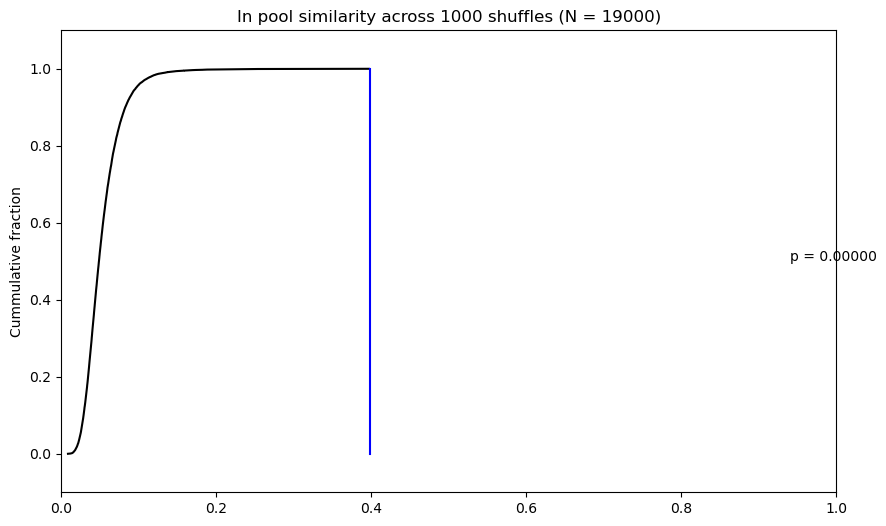

In [123]:
plot_shuf_cum(x_inpool_total,color = '#000000',ref_x=x_inpool_median, fn='cdf_inpool_sim_cr_shuffled',fignum=4,title='In pool similarity across {} shuffles (N = {})'.format(N,len(x_inpool_total)))
np.median(x_inpool_total)

The within pool similarity is almost always less than .1, whereas the median in pool similarity is actually 0.64

How large can the auc be when comparing within pool distributions vs. across pool distributions?

<AxesSubplot: title={'center': 'MWU AUC (N = 1000 shuffles)'}, ylabel='Cummulative fraction'>

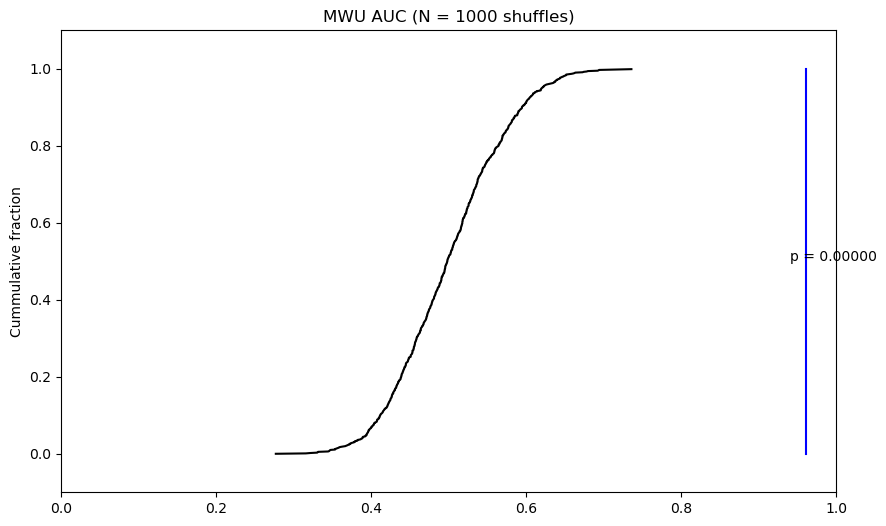

In [124]:
plot_shuf_cum(mwu_val,color = '#000000',ref_x=mwu_val_max, fn='cdf_sim_auc_cr_shuffled',fignum=4,title='MWU AUC (N = {} shuffles)'.format(N))

So, the in pool similarity is always small, and within pool vs. across pool distributions are always similar.

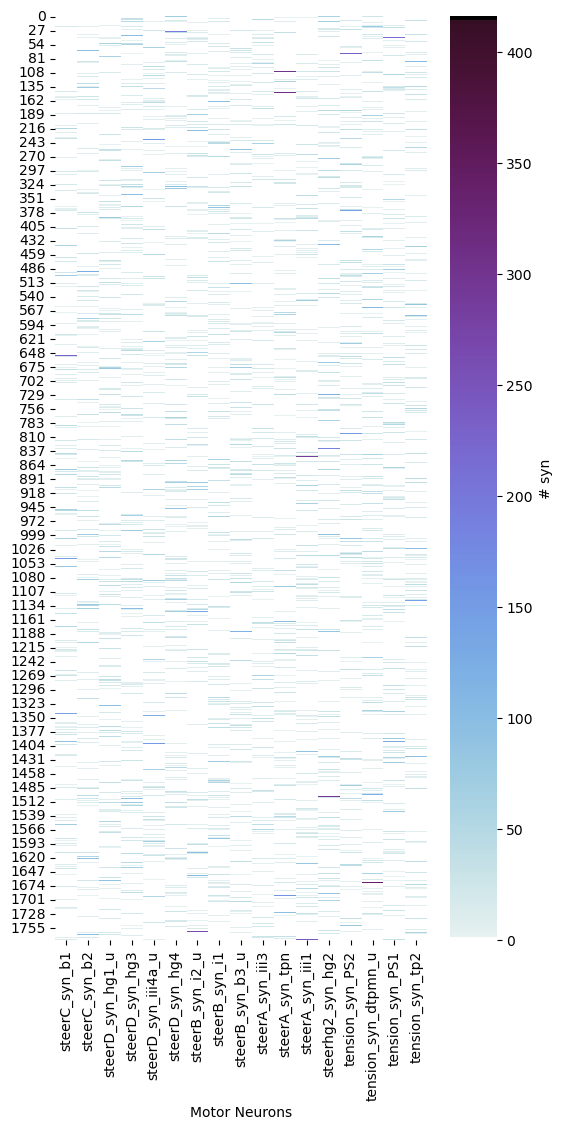

In [125]:
plot_conn_map(mixup,directs_only)

# Shuffle columns, keep the pools

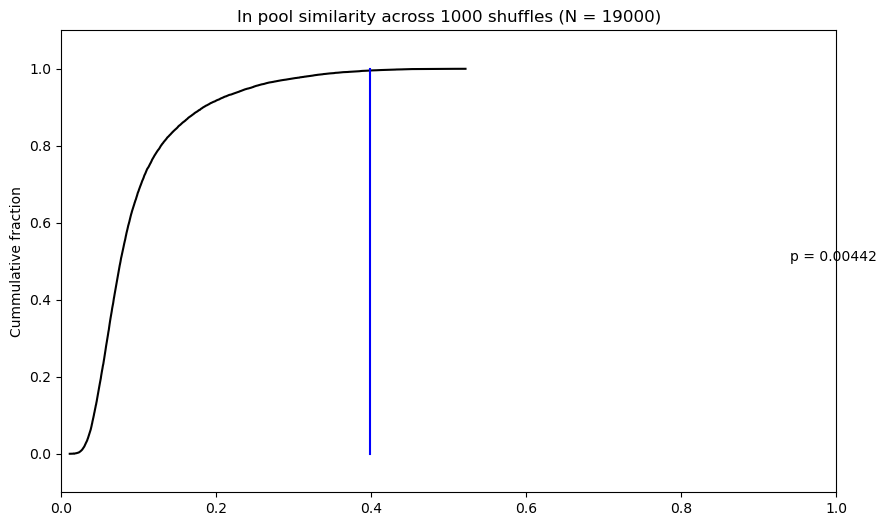

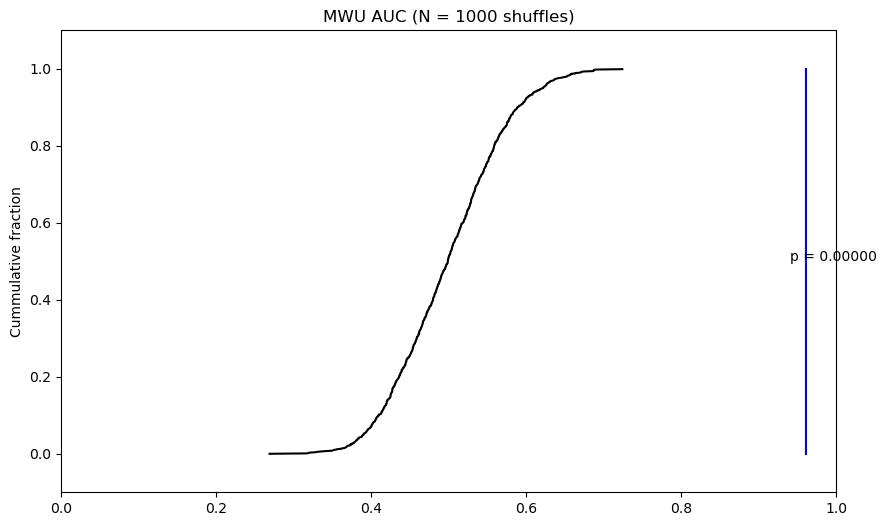

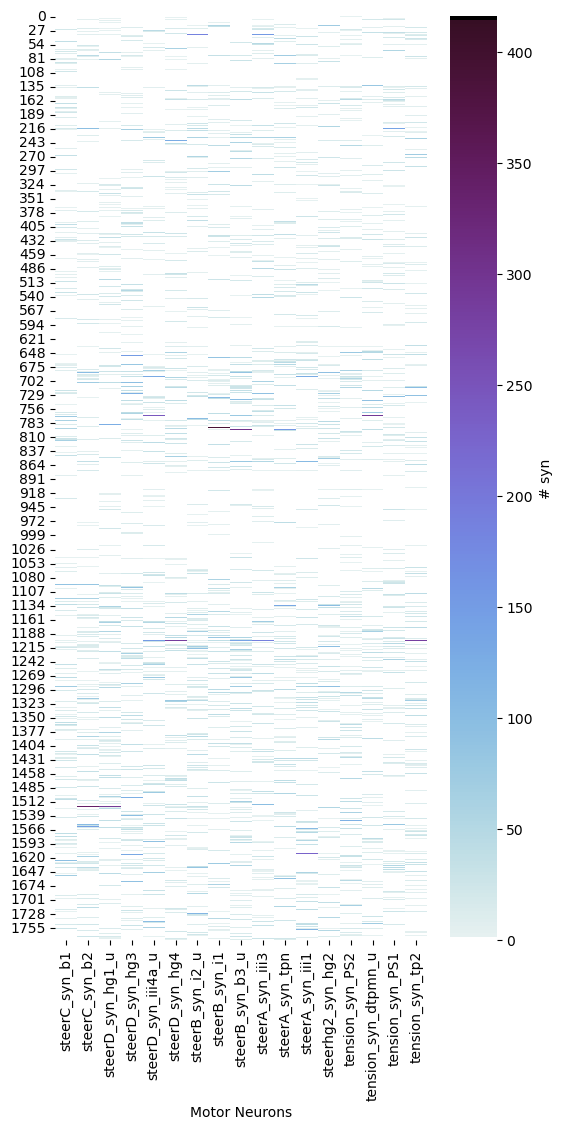

In [126]:
syn_all = ['DLM_syn', 'DVM_syn', 'tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerhg2_syn', 'steerD_syn']
syn_filter = ['tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerhg2_syn', 'steerD_syn']
directs_only = reordered_wing.loc[:,reordered_wing.columns.get_level_values('mod_name').isin(syn_filter)]
mn_mi_df = directs_only.columns.to_frame() # rowsorted_wing

sim_mat = cosine_similarity(directs_only.to_numpy().transpose())

mwu_val = []

rng = np.random.default_rng()

cos_sim_mean_dict = {}
mixups_dict = {}
mixups_means_dict = {}

motor_pool_mask = np.full((len(mn_mi_df), len(mn_mi_df)), False, dtype=bool)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].mod_name==mn_mi_df.iloc[j,:].mod_name)


tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
tril_mask = np.tril(tril_mask,-1)
pool_arr = mn_mi_df.mod_name.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))
sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }

sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')
sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
# # get rid of upper triangle
sim_compare_lt_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]

x_outofpool = sim_compare_lt_df.loc[~sim_compare_lt_df['same_pool'],idx]
x_inpool = sim_compare_lt_df.loc[sim_compare_lt_df['same_pool'],idx]
x_inpool_median = x_inpool.median()

mwu_val =[]
x_inpool_total = []

N=1000
for r in range(N):
    mixupmat = directs_only.to_numpy().copy()   
    mixup = mix_up_columns_under_mask(mixupmat,mask=None,rng=rng)
    sim_mat = cosine_similarity(mixup.transpose())
    
    sim_compare_df['sim_vals'] = sim_mat.reshape(-1)
    sim_compare_lt_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]
    idx = 'sim_vals'
    x_outofpool = sim_compare_lt_df.loc[~sim_compare_lt_df['same_pool'],idx]
    x_inpool = sim_compare_lt_df.loc[sim_compare_lt_df['same_pool'],idx]
    mwu_out = scipy.stats.mannwhitneyu(x_inpool,x_outofpool)
    mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))
    x_inpool_total=x_inpool_total+x_inpool.to_list()
    
plot_shuf_cum(x_inpool_total,color = '#000000',ref_x=x_inpool_median, fn='cdf_inpool_sim_cr_shuffled',fignum=3,title='In pool similarity across {} shuffles (N = {})'.format(N,len(x_inpool_total)))
np.median(x_inpool_total)
plot_shuf_cum(mwu_val,color = '#000000',ref_x=mwu_val_max, fn='cdf_sim_auc_cr_shuffled',fignum=4,title='MWU AUC (N = {} shuffles)'.format(N))
plot_conn_map(mixup,directs_only)

How large can the cosine similarity be, in the defined pools, if the adj mat is shuffled?

The within pool similarity is almost always less than .1, whereas the median in pool similarity is actually 0.64

How large can the auc be when comparing within pool distributions vs. across pool distributions?

So, the in pool similarity is always small, and within pool vs. across pool distributions are always similar.

# Pool preference for preMNs under column shuffle

0.9042553191489362
mean: 0.825167236044373 +- 0.1946080540236549
median: 0.9042553191489362 +- 0.33333333333333337
0
100
200
300
400
500
600
700
800
900


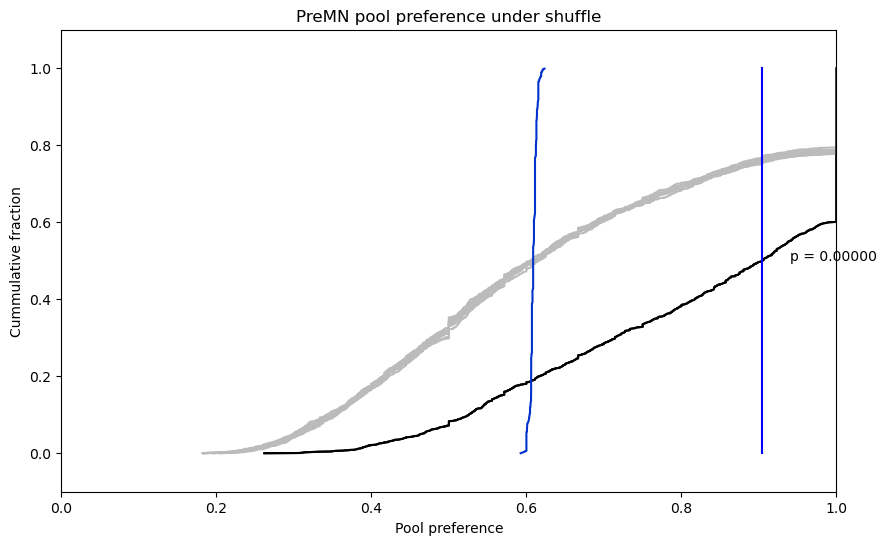

<Figure size 1000x600 with 0 Axes>

In [127]:
syn_all = ['DLM_syn', 'DVM_syn', 'tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerhg2_syn', 'steerD_syn']
syn_filter = ['tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerhg2_syn', 'steerD_syn']
# directs_only = reordered_wing.loc[:,reordered_wing.columns.get_level_values('mod_name').isin(syn_filter)]
mn_mi_df = reordered_wing.columns.to_frame() # rowsorted_wing

rng = np.random.default_rng()

mod_mat = np.full((reordered_wing.shape[0],len(syn_all)),fill_value=0,dtype=np.int64)
out_df = pd.DataFrame(mod_mat[:,0:2],columns=['pool','pref'])

out_df['mod'] = ''
denom = reordered_wing.sum(axis=1).reset_index(drop=True).to_numpy()
out_df['sum'] = denom

modname_idx_dict = {}
for md in syn_all:
        md_idx = mn_mi_df.mod_name==md
        modname_idx_dict[md] = md_idx.to_numpy()

mixupmat = reordered_wing.to_numpy()
modname_mat = np.tile(syn_all, (reordered_wing.shape[0], 1))
r_idx = np.arange(len(denom))

def calc_pool_pref_from_mat(mixupmat, mod_mat ,out_df):
    
    c = -1
    for md in syn_all:
        c=c+1
        md_idx = modname_idx_dict[md]
        mod_mat[:,c] = mixupmat[:,md_idx].sum(axis=1)

    idx = np.argmax(mod_mat,axis=1)
    # return  pool_keys[idx], pool_mat[:,idx] / denom
    out_df['mod'] = modname_mat[r_idx,idx]
    out_df['pref'] = np.divide(mod_mat[r_idx,idx], denom)
    return out_df

out_df = calc_pool_pref_from_mat(mixupmat, mod_mat ,out_df)

x = out_df['pref'].to_numpy()
ax = plot_shuf_cum(x,color = '#000000',ref_x=None, fn=None,fignum=4,title=None)
mod_pref_median = np.median(x)
print(mod_pref_median)
frac_100pct_unshuff = np.sum(out_df['pref']==1)/out_df.shape[0]
iqr = np.percentile(x, 75) - np.percentile(x, 25)
print('mean: {} +- {}'.format(np.mean(x),np.std(x)))
print('median: {} +- {}'.format(np.median(x),iqr))

N=1000
# Redo this, incorrect
mixed_prefs = []
mixed_pref_median = []
frac_100pct = []
for r in range(N):
    mixupmat = reordered_wing.to_numpy().copy()
    mixup = mix_up_columns_under_mask(mixupmat,mask=None,rng=rng)
    out_df = calc_pool_pref_from_mat(mixup, mod_mat ,out_df)
    # mixed_prefs = mixed_prefs + out_df['pref'].to_list()
    mixed_pref_median.append(out_df['pref'].median())
    frac_100pct.append(np.sum(out_df['pref']==1)/out_df.shape[0])
    if np.mod(r,100)==0:
        print(r)
        plot_shuf_cum(out_df['pref'].to_numpy(),color = '#BBBBBB',ref_x=None, fn=None,fignum=3,title=None,ax=ax)

plot_shuf_cum(x,color = '#000000',ref_x=None, fn=None,fignum=3,title=None,ax=ax)
ax = plot_shuf_cum(mixed_pref_median,color = '#0033CC',ref_x=mod_pref_median, fn=None,fignum=3,title='PreMN pool preference under shuffle',ax=ax,xlabel='Pool preference')

ax.get_figure().savefig('./figpanels/pool_pref_wing_under_shuffling.svg')

In [128]:
print(np.min(mixed_pref_median))
print(np.max(mixed_pref_median))
print(np.min(mixed_pref_median) - np.max(mixed_pref_median))
print(np.mean(mixed_pref_median))

0.5925925925925926
0.6233766233766234
-0.030784030784030803
0.6089732818864072


In [129]:
frac_100pct_unshuff

0.3991006183249016

<AxesSubplot: ylabel='Cummulative fraction'>

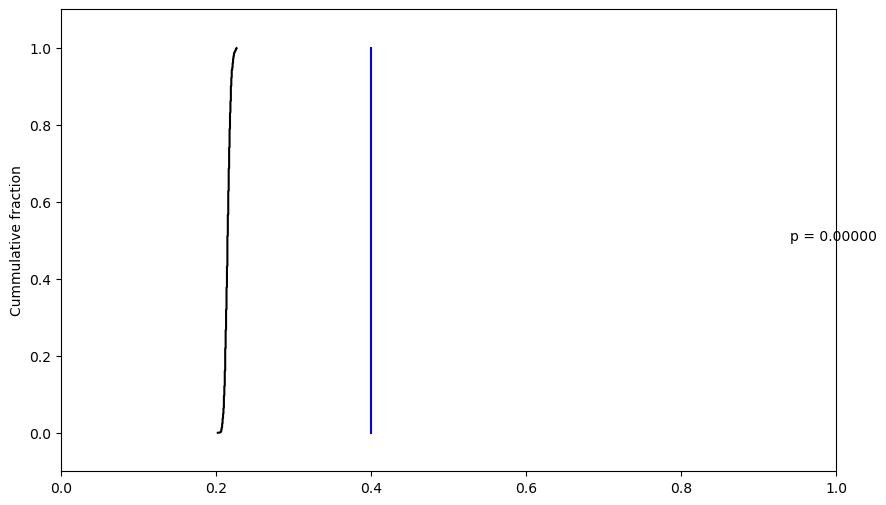

In [130]:
plot_shuf_cum(frac_100pct,color = '#000000',ref_x=frac_100pct_unshuff, fn=None,fignum=3,title=None)



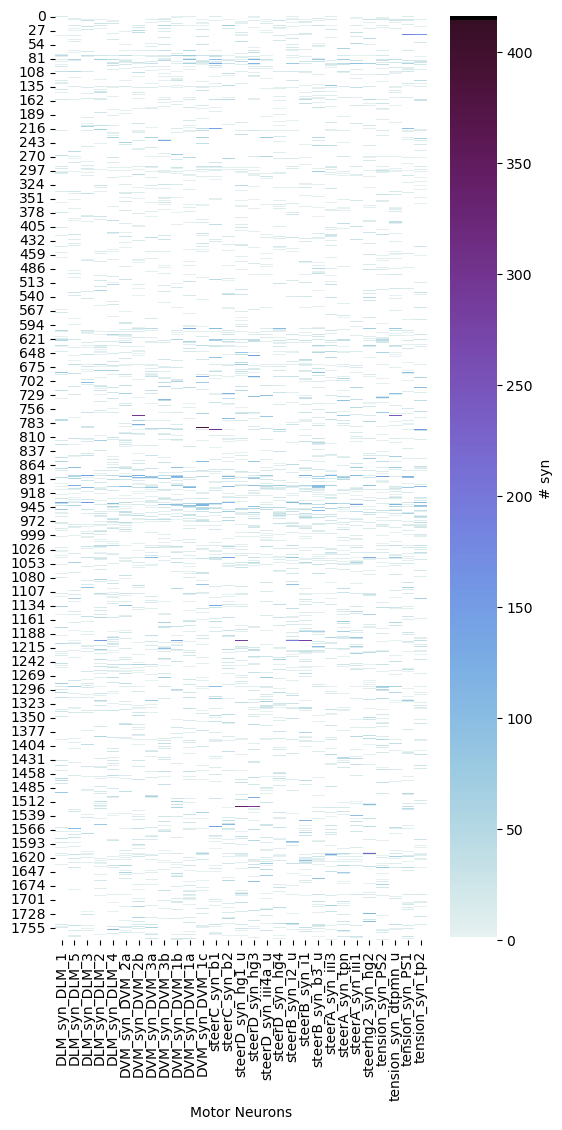

In [131]:
plot_conn_map(mixup,reordered_wing)

# Figure 3h plots: module preference

In [132]:
reordered_wing
mod_keys

Index(['DLM_syn', 'DVM_syn', 'steerC_syn', 'steerD_syn', 'steerB_syn',
       'steerA_syn', 'steerhg2_syn', 'tension_syn'],
      dtype='object', name='mod_name')

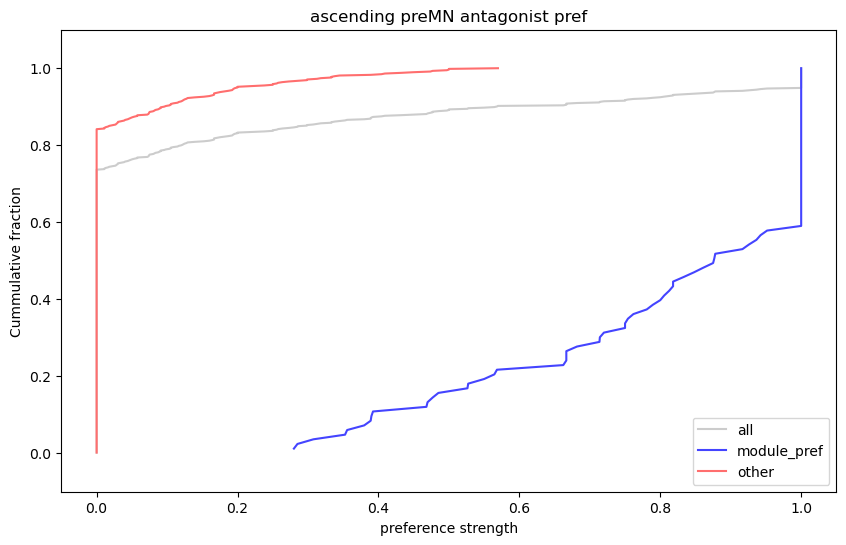

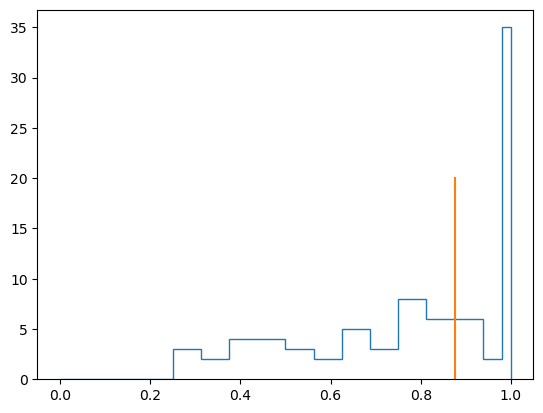

ascending total preferences = (664,)
ascending median = 0.8767123287671232
ascending fraction single = 0.42168674698795183


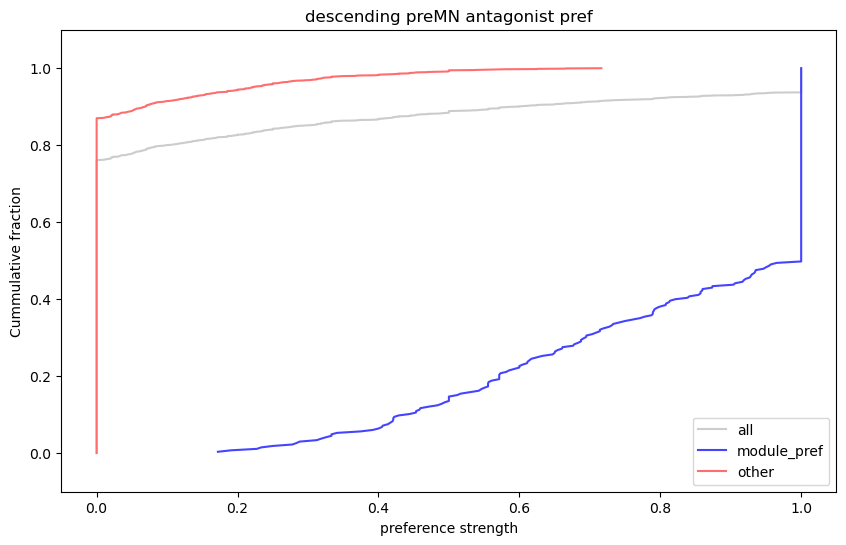

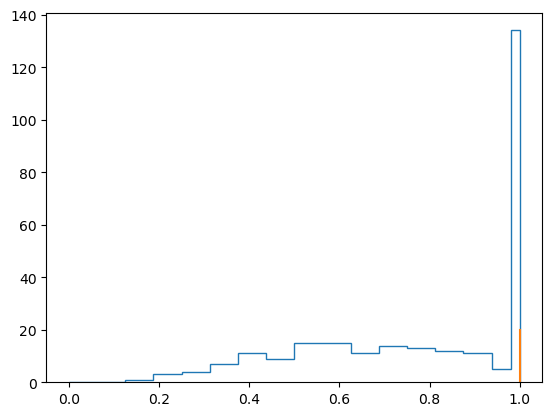

descending total preferences = (2120,)
descending median = 1.0
descending fraction single = 0.5056603773584906


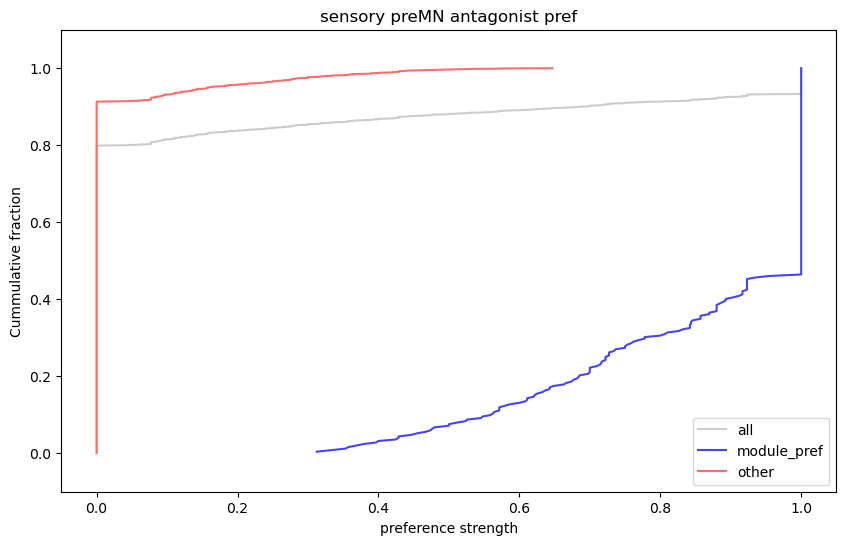

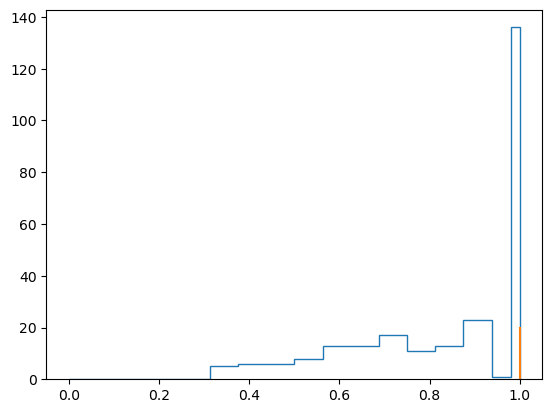

sensory total preferences = (2016,)
sensory median = 1.0
sensory fraction single = 0.5396825396825397


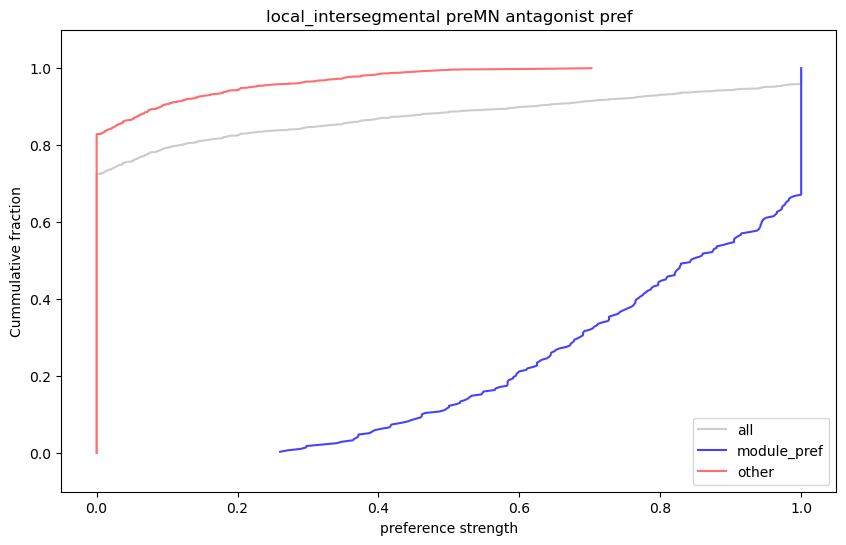

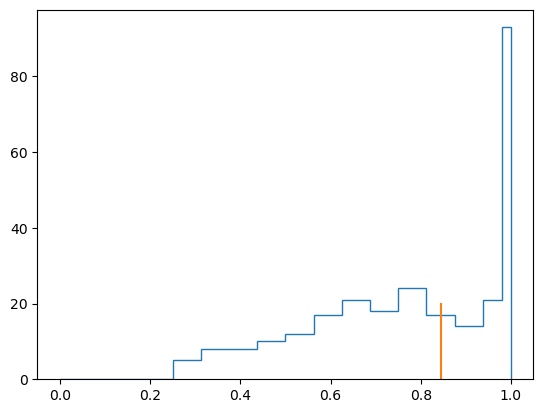

local_intersegmental total preferences = (2144,)
local_intersegmental median = 0.8439091915836101
local_intersegmental fraction single = 0.332089552238806


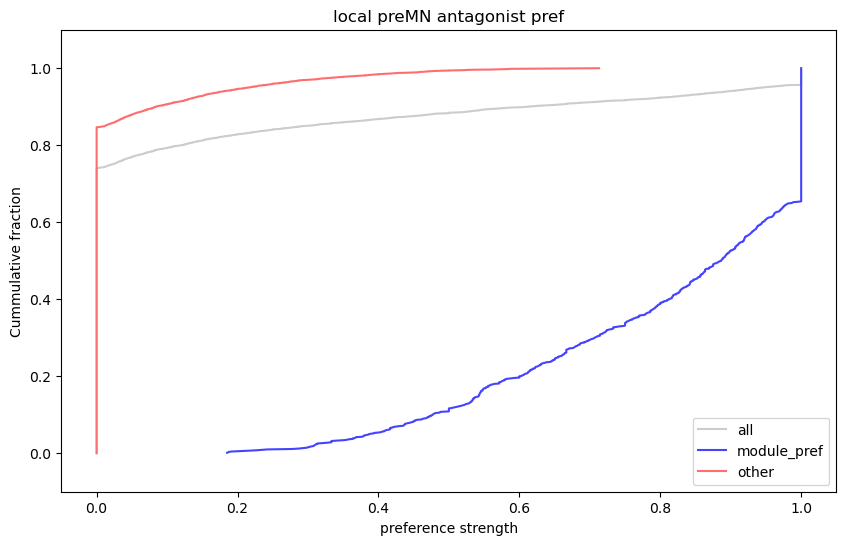

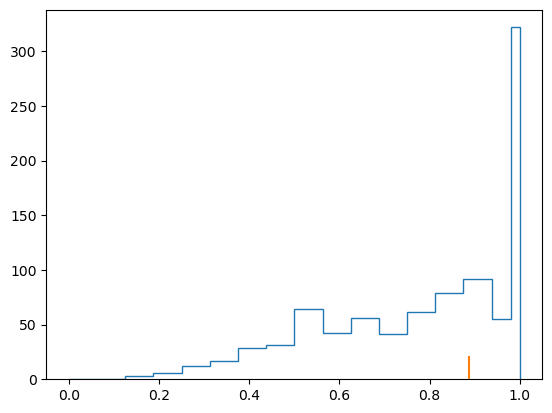

local total preferences = (7288,)
local median = 0.8865979381443299
local fraction single = 0.3468715697036224


In [133]:
cell_class = 'intersegmental'
class_pref_dict = {}
for cell_class in reordered_wing.index.get_level_values("cell_class").unique():
    df = reordered_wing.loc[(All,All,All,cell_class,All,All),:]

    pref_total_df = df.T.groupby(level='mod_name',observed=True).sum().T
    denom = pref_total_df.sum(axis=1)
    pref_strength_df = pref_total_df.div(denom,axis=0)
    # pref_strength_df = pref_strength_df.droplevel(['cell_class','NT','classification_system','cell_type','segID'])
    pref_strength_df = pref_strength_df.droplevel(['cell_class','putative_NT','preferred_mn','cell_type'])
    pref_strength_df.index = pref_strength_df.index.reorder_levels(['preferred_module','pre_pt_root_id'])

    each_distr_dict = {}
    eachother_distr_dict = {}

    all_prefs = np.ravel(pref_strength_df.values)
    for mod in mod_keys:
        try:
            each = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('mod_name') == mod))]
        except KeyError:
            continue    

        each_distr_dict[mod] = np.ravel(each.values)
        eachothers = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('mod_name') != mod))]
        eachother_distr_dict[mod] = np.ravel(eachothers.values)


    each_prefs = np.concatenate(list(each_distr_dict.values()), axis=0)
    class_pref_dict[cell_class] = each_prefs
    eachothers_prefs = np.concatenate(list(eachother_distr_dict.values()), axis=0)

    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot2grid((1,1),(0,0))
    ax.set_ylim([-.1, 1.1])
    ax.set_xlim([-.05, 1.05])

    ax.set_ylabel('Cummulative fraction')
    ax.set_xlabel('preference strength')
    ax.set_title('{} preMN antagonist pref'.format(cell_class))

    y_all = (np.array(range(len(all_prefs))).astype(float)+1)/len(all_prefs)
    y_each = (np.array(range(len(each_prefs))).astype(float)+1)/len(each_prefs)
    y_eachothers = (np.array(range(len(eachothers_prefs))).astype(float)+1)/len(eachothers_prefs)

    ax.plot(sorted(all_prefs),y_all,color='#CCCCCC',label='all')
    ax.plot(sorted(each_prefs),y_each,color='#4444FF',label='module_pref')
    ax.plot(sorted(eachothers_prefs),y_eachothers,color='#ff6e6e',label='other')

    ax.legend()
    plt.show()
    fig.savefig('./figpanels/pre_cdfs_wing_etc_{}.svg'.format(cell_class),format='svg')

    # print(all_prefs.mean())
    # print(others_prefs.mean())
    # print(antagonist_prefs.mean())

    fig,ax = plt.subplots()
    e = np.sort(np.append(np.array(range(16+1))/16,.98))
    h,e = np.histogram(each_prefs, bins=e, range=None, density=False, weights=None)
    ax.stairs(h, e, label='each_prefs')
    ax.plot(np.median(each_prefs)* np.array([1, 1,]),[0.,20])
    plt.show()
    fig.savefig('./figpanels/pref_hist_wing_{}.svg'.format(cell_class))
    print('{} total preferences = {}'.format(cell_class,all_prefs.shape))
    print('{} median = {}'.format(cell_class,np.median(each_prefs)))
    print('{} fraction single = {}'.format(cell_class,float(np.sum(each_prefs==1))/len(each_prefs)))

## Total synapses vs pre strength

In [134]:
    # df = reordered_wing.loc[(All,All,All,cell_class,All,All),:]

    # pref_total_df = df.T.groupby(level='mod_name',observed=True).sum().T
    # denom = pref_total_df.sum(axis=1)
    # pref_strength_df = pref_total_df.div(denom,axis=0)
    # # pref_strength_df = pref_strength_df.droplevel(['cell_class','NT','classification_system','cell_type','segID'])
    # pref_strength_df = pref_strength_df.droplevel(['cell_class','putative_NT','preferred_mn','cell_type'])
    # pref_strength_df.index = pref_strength_df.index.reorder_levels(['preferred_module','pre_pt_root_id'])

r = -0.4792573134226071, p = 4.567856916855854e-06


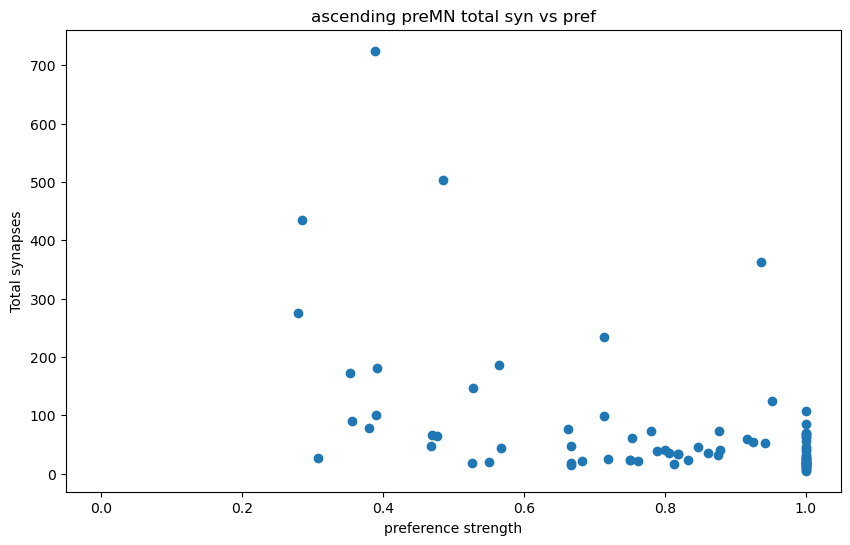

(263,)
r = -0.43555692792064526, p = 1.3334088671366943e-13


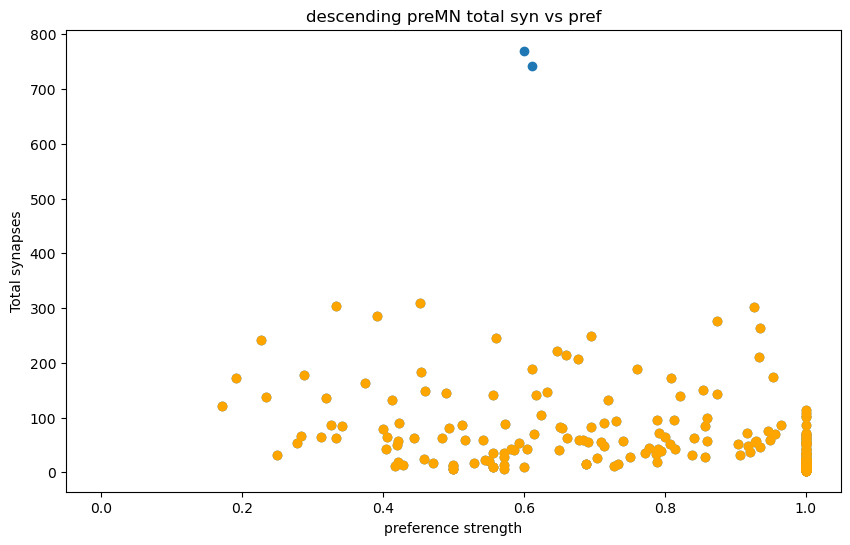

r = -0.30472236971172506, p = 8.17927796605234e-07


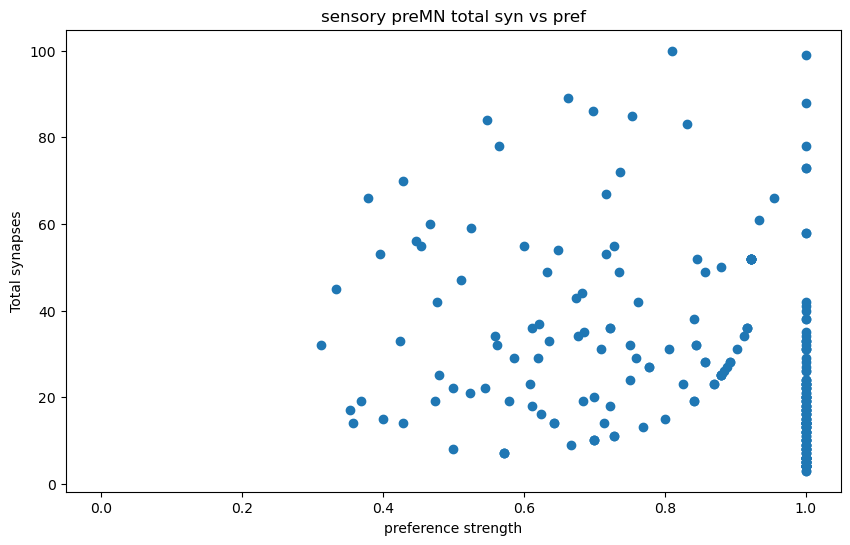

r = -0.1640822684209981, p = 0.007105579824820461


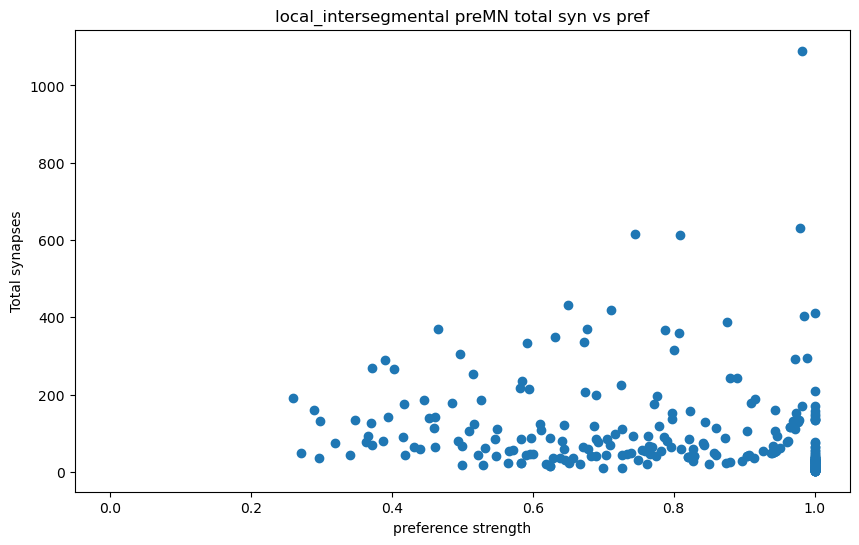

r = -0.1164798579364131, p = 0.0004269225916095287


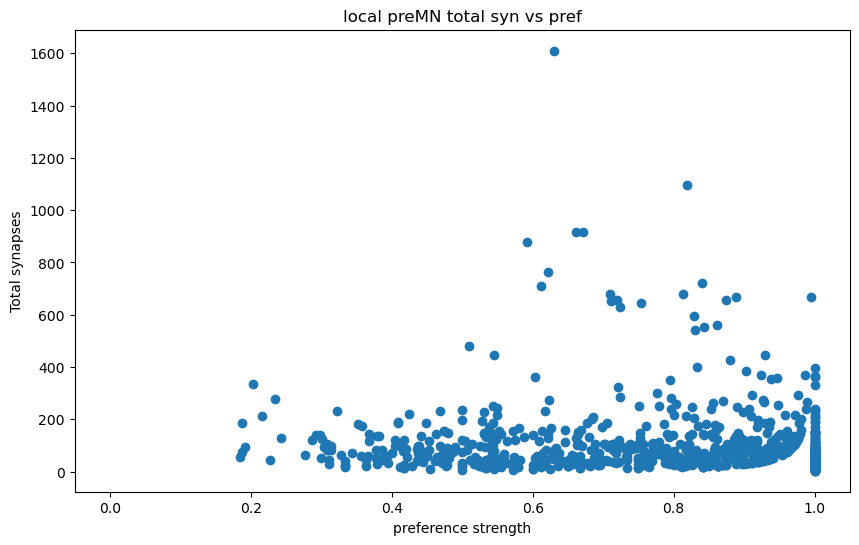

In [135]:
from scipy.stats import pearsonr

pref_total_df = reordered_wing.T.groupby(level='mod_name',observed=True).sum().T
denom = pref_total_df.sum(axis=1)
pref_strength_df = pref_total_df.div(denom,axis=0)
# pref_strength_df = pref_strength_df.droplevel(['cell_class','NT','classification_system','cell_type','segID'])
pref_strength_df['total'] = pref_total_df.sum(axis=1)
pref_strength_df['mod_pref'] = 0.

pref_str_segid_df = pref_strength_df.copy()
pref_str_segid_df = pref_str_segid_df.droplevel(['cell_class','putative_NT','preferred_mn','cell_type','preferred_module'])
pref_strength_df = pref_strength_df.droplevel(['cell_class','putative_NT','preferred_mn','cell_type'])
pref_strength_df.index = pref_strength_df.index.reorder_levels(['preferred_module','pre_pt_root_id'])

for mod in mod_keys: 
    each = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('mod_name') == mod))]
    pref_str_segid_df.loc[each.index,'mod_pref'] = each.loc[each.index,mod]

pref_str_segid_df.index = pref_total_df.index

for cell_class in reordered_wing.index.get_level_values("cell_class").unique():

    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot2grid((1,1),(0,0))
    ax.set_xlim([-.05, 1.05])

    ax.set_ylabel('Total synapses')
    ax.set_xlabel('preference strength')
    ax.set_title('{} preMN total syn vs pref'.format(cell_class))

    x = pref_str_segid_df.loc[(All,All,All,cell_class,All,All),'mod_pref']
    y = pref_str_segid_df.loc[(All,All,All,cell_class,All,All),'total']

    ax.scatter(x,y,label='all')
    if cell_class=='descending':
        x = x[y<600]
        y = y[y<600]
        ax.scatter(x,y,label='select',color='orange')
        print(x.shape)
    correlation_coefficient, p_value = pearsonr(x, y)
    print('r = {}, p = {}'.format(correlation_coefficient,p_value))
    plt.show()
    fig.savefig('./figpanels/pref_total_syn_num_{}.svg'.format(cell_class),format='svg')


c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


r = -0.18600090461181054, p = 2.599271449273965e-15


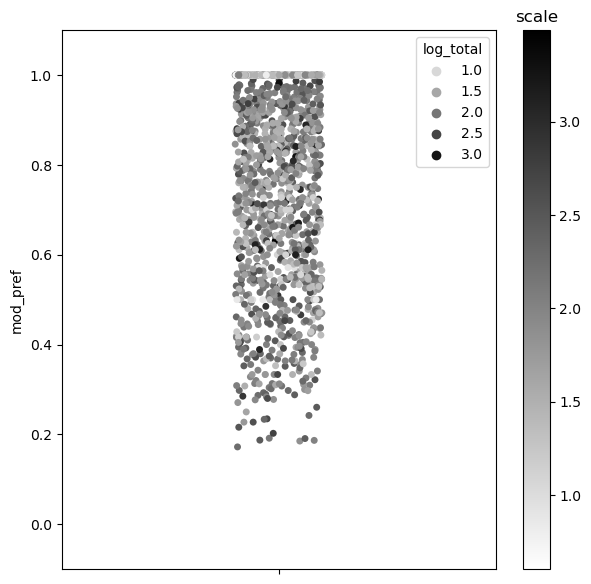

In [136]:
from matplotlib.cm import ScalarMappable

f, ax = plt.subplots(figsize=(7, 7))
pref_str_segid_df['log_total'] = np.log10(pref_str_segid_df['total']+1)
# stripplot  = sns.stripplot(data=pref_str_segid_df.reset_index('cell_class').iloc[::-1],x='cell_class',y='mod_pref',hue='log_total',palette=cos_cmap, ax=ax)
stripplot  = sns.stripplot(data=pref_str_segid_df.reset_index('cell_class').iloc[::-1],y='mod_pref',hue='log_total',palette=cos_cmap, ax=ax)
norm = plt.Normalize(pref_str_segid_df.log_total.values.min(), 3.4900)# pref_str_segid_df.log_total.values.max())

sm =  ScalarMappable(norm=norm,cmap=cos_cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_title("scale")

ax.set_ylim([-.1, 1.1])
f.savefig('./figpanels/mod_pref_by_total_synapses_wing.svg',format='svg')

correlation_coefficient, p_value = pearsonr(pref_str_segid_df['mod_pref'],pref_str_segid_df['total'])
print('r = {}, p = {}'.format(correlation_coefficient,p_value))

## Total synapses per mod

In [137]:
lbls = [i for i in pref_strength_df.columns.values]

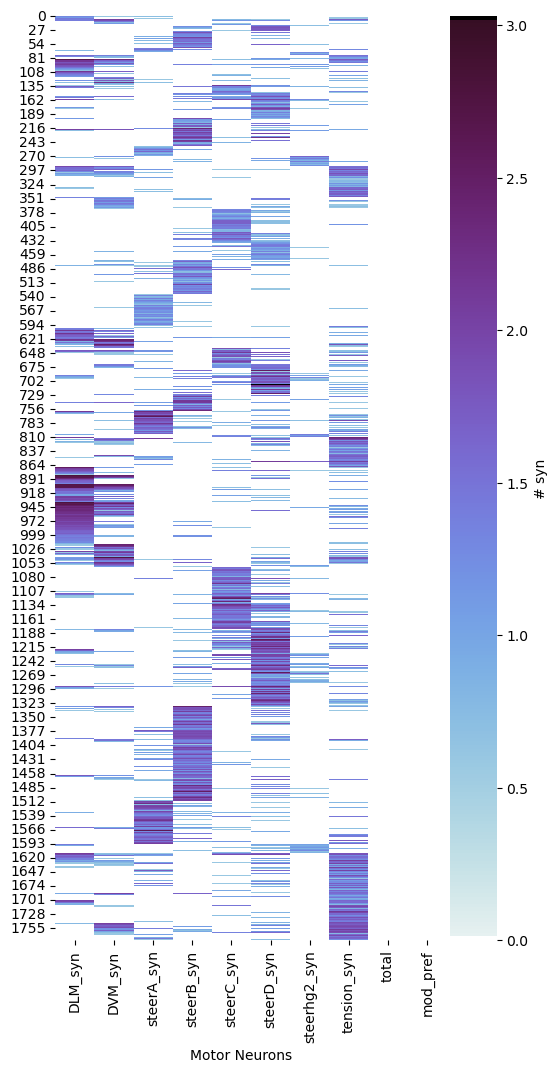

In [138]:
# pref_total_df = reordered_wing.T.groupby(level='mod_name',observed=True).sum().T

fig = plt.figure(figsize = [6,12])
ax = sns.heatmap(np.log10(pref_total_df.values+1), xticklabels=lbls, cmap=utils.white_dense())
# ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

cbar.set_label(label = '# syn')
plt.xlabel('Motor Neurons')
plt.show()

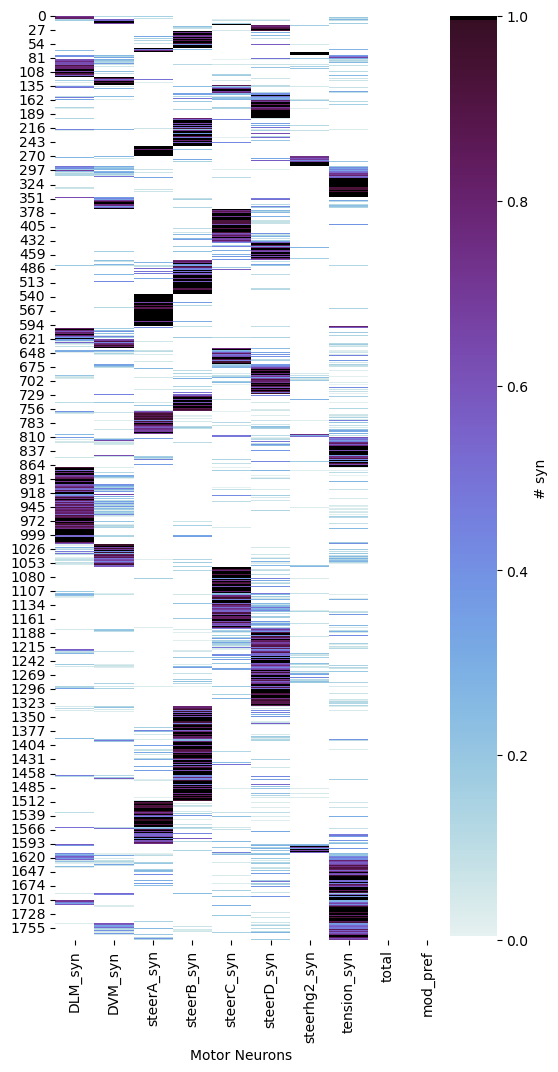

In [139]:
pref_total_df = reordered_wing.T.groupby(level='mod_name',observed=True).sum().T
denom = pref_total_df.sum(axis=1)
pref_strength_df = pref_total_df.div(denom,axis=0)

fig = plt.figure(figsize = [6,12])
ax = sns.heatmap(pref_strength_df.values, xticklabels=lbls, cmap=utils.white_dense())
# ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

cbar.set_label(label = '# syn')
plt.xlabel('Motor Neurons')
plt.show()

# Distribution of similarity under pool shuffle
Finally, a key question: How likely are the cosine similarity under shuffling within pools?

In [140]:
mk in syn_filter

True

(1779, 28)
(1758, 28)
DLM_syn


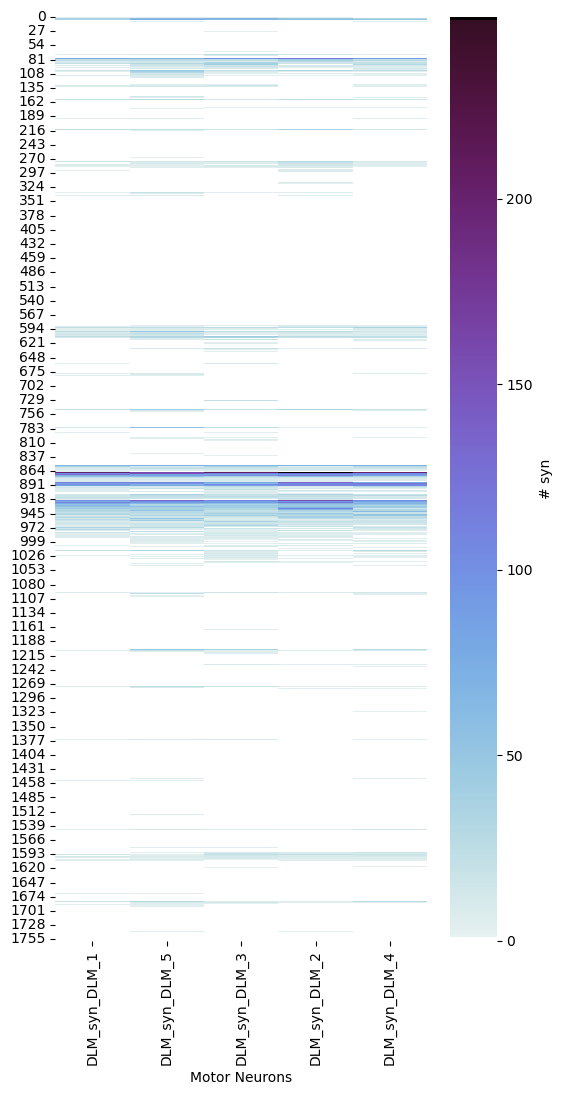

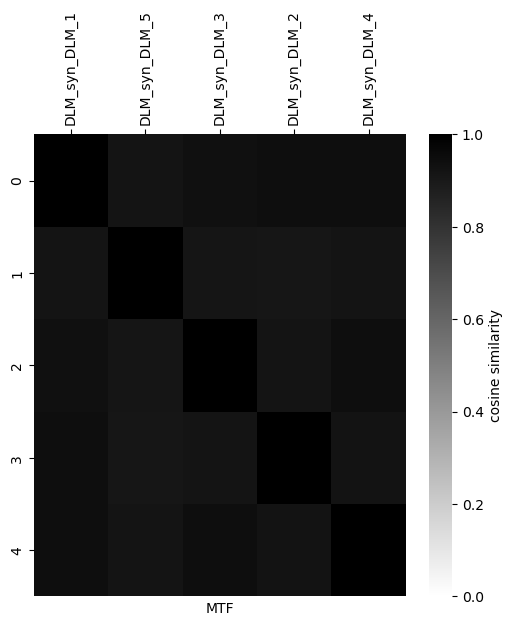

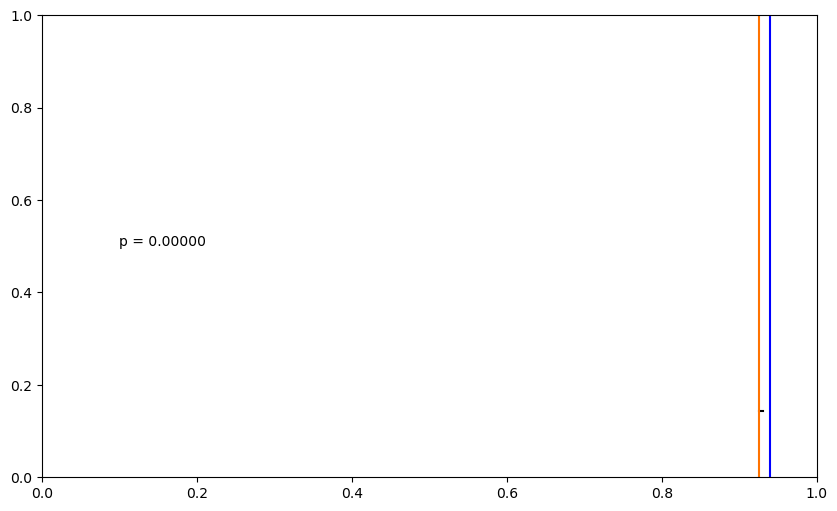

DVM_syn


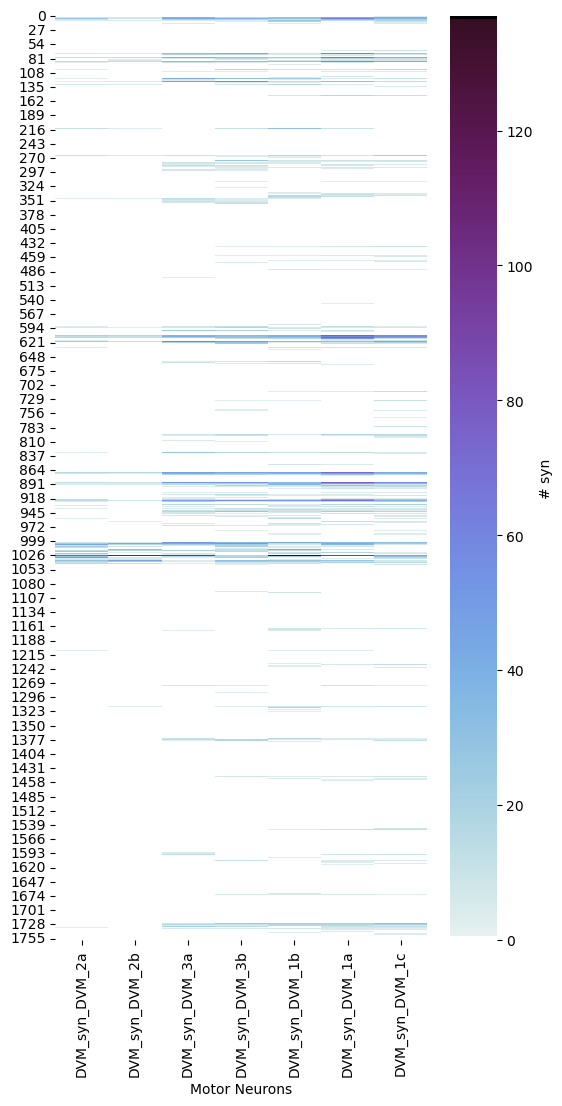

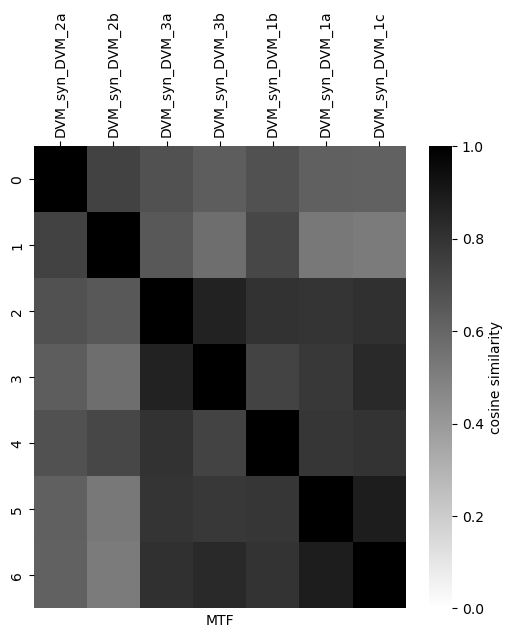

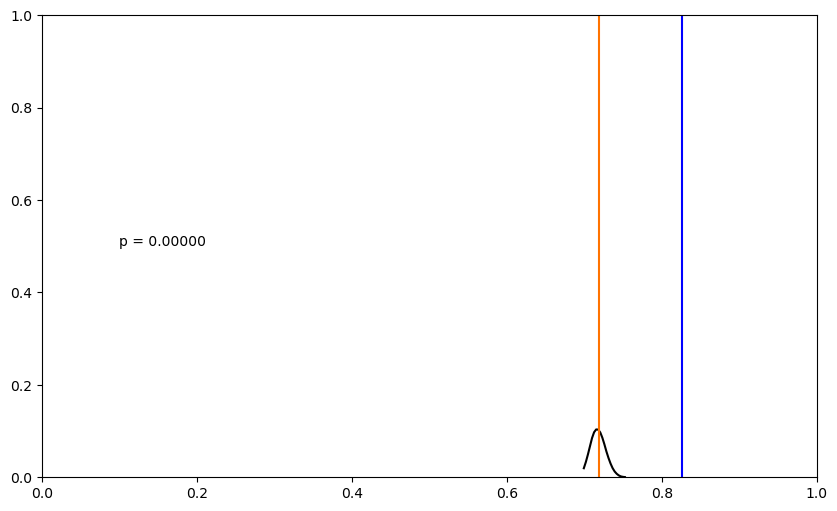

steerC_syn


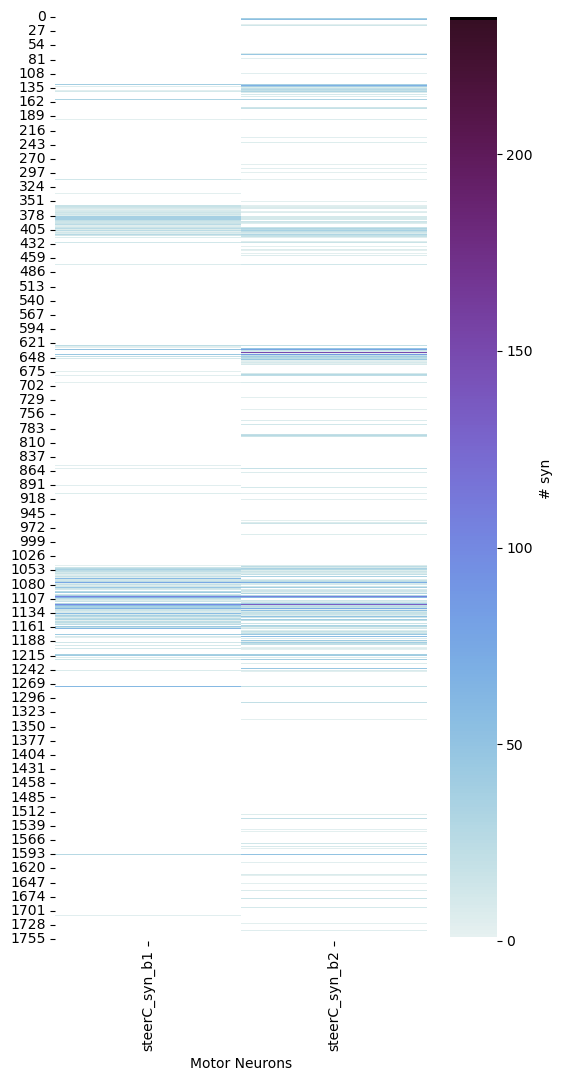

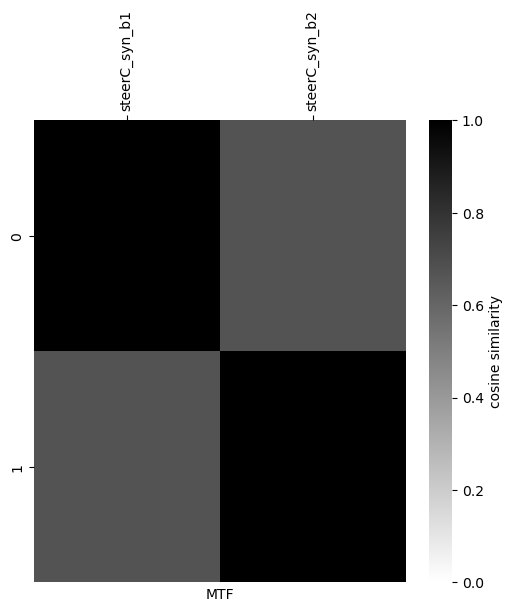

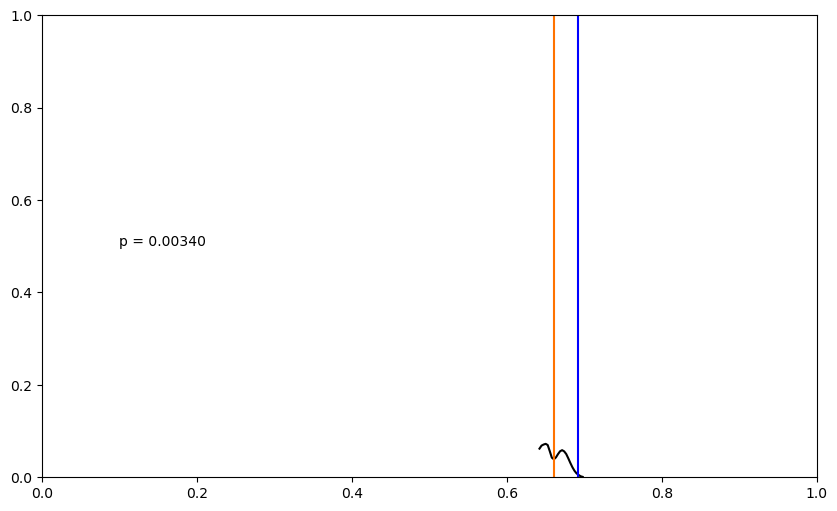

steerD_syn


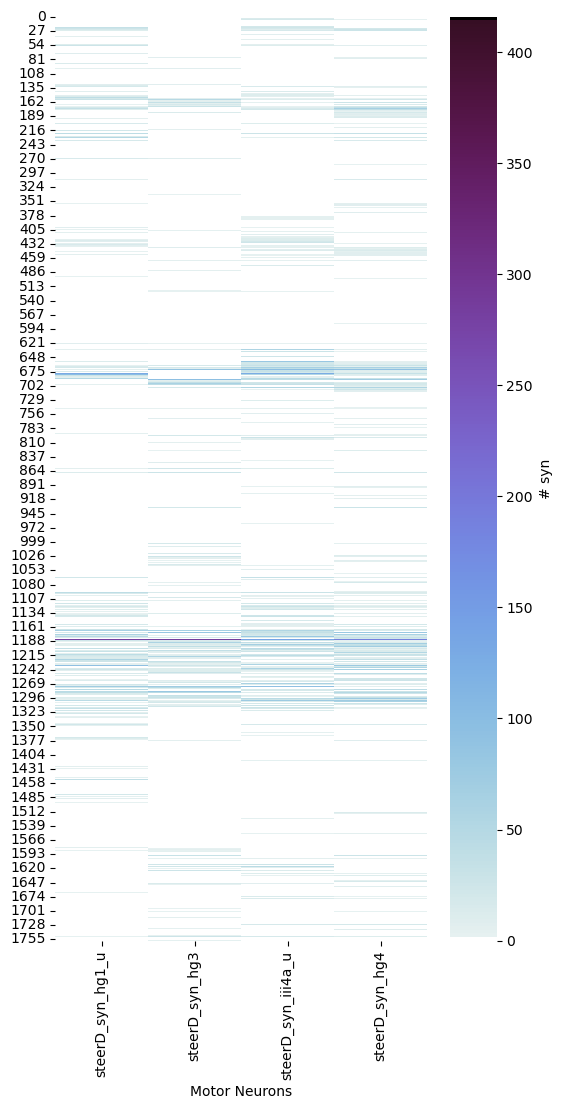

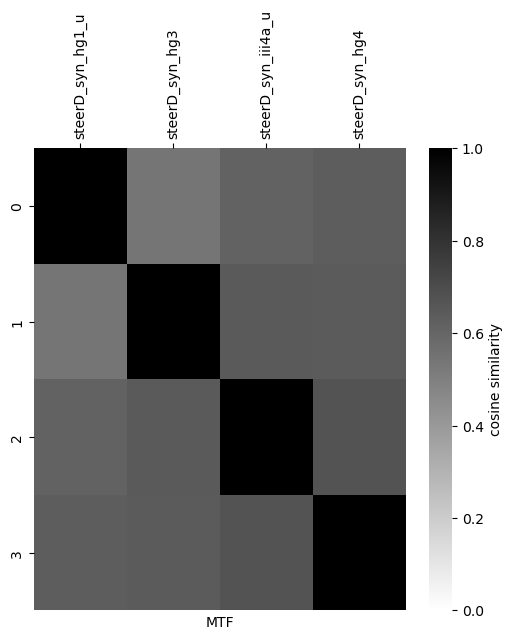

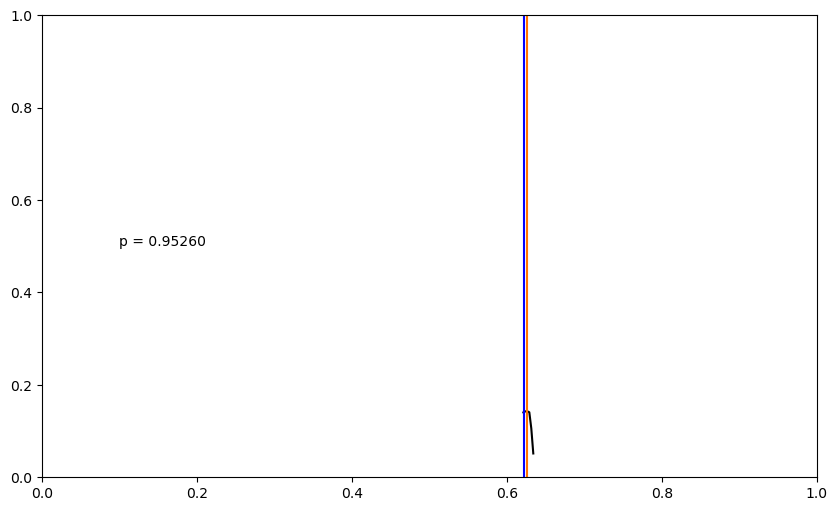

steerB_syn


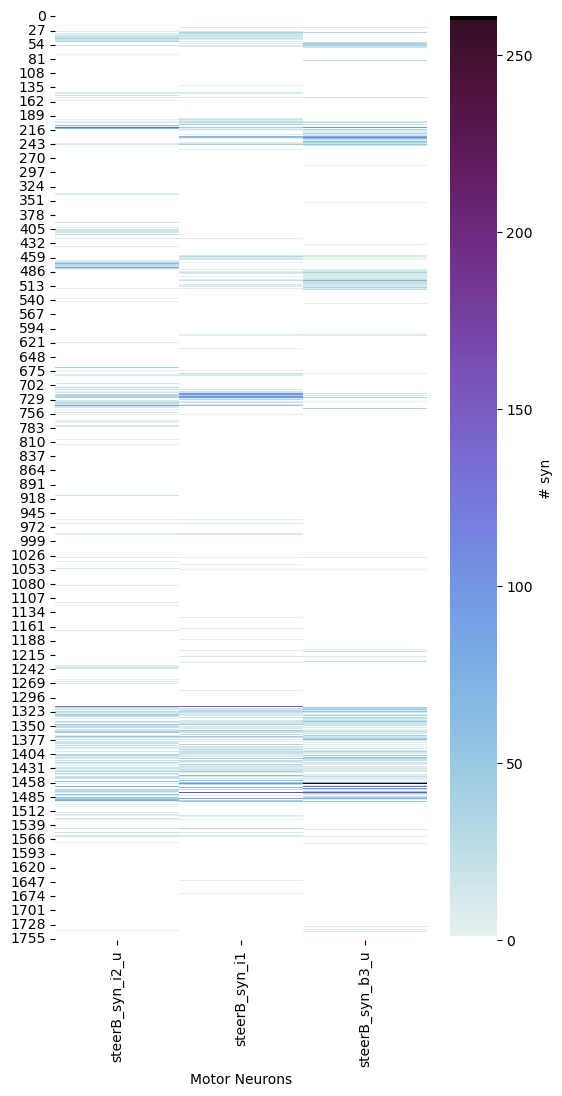

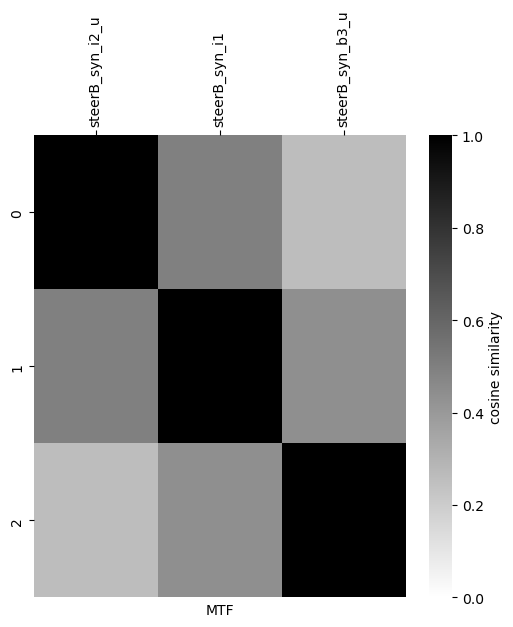

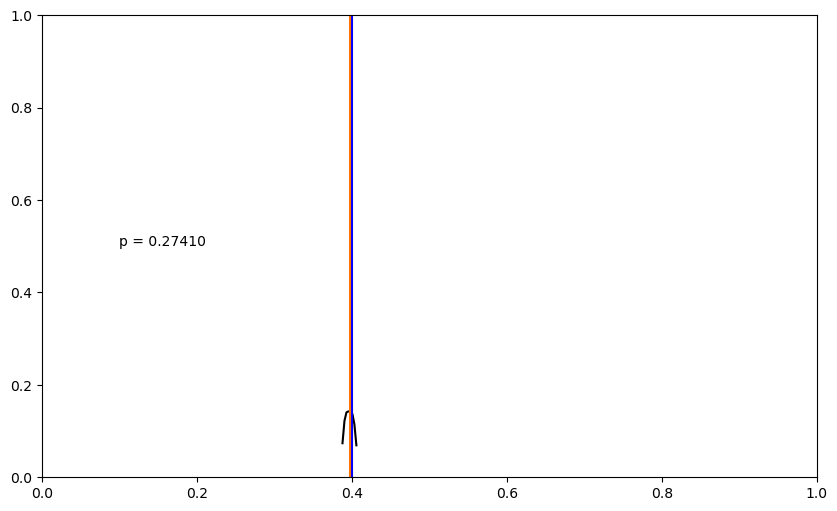

steerA_syn


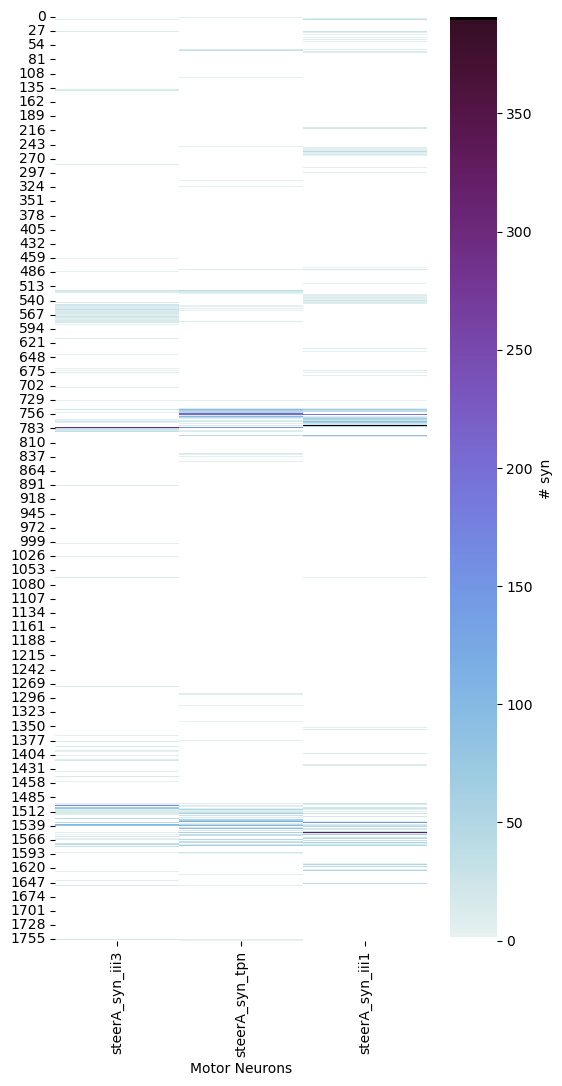

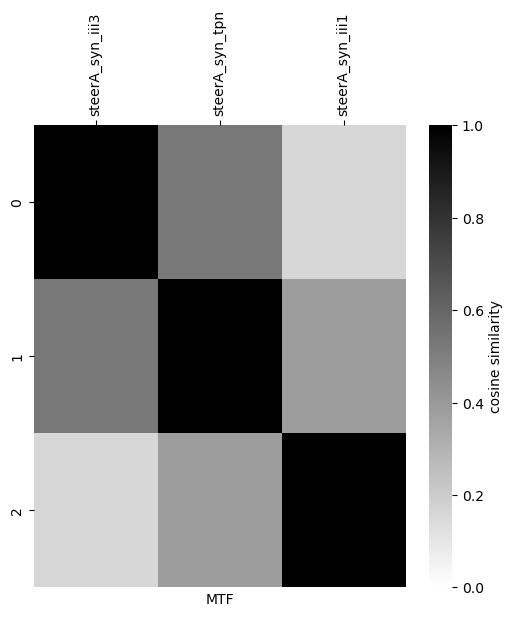

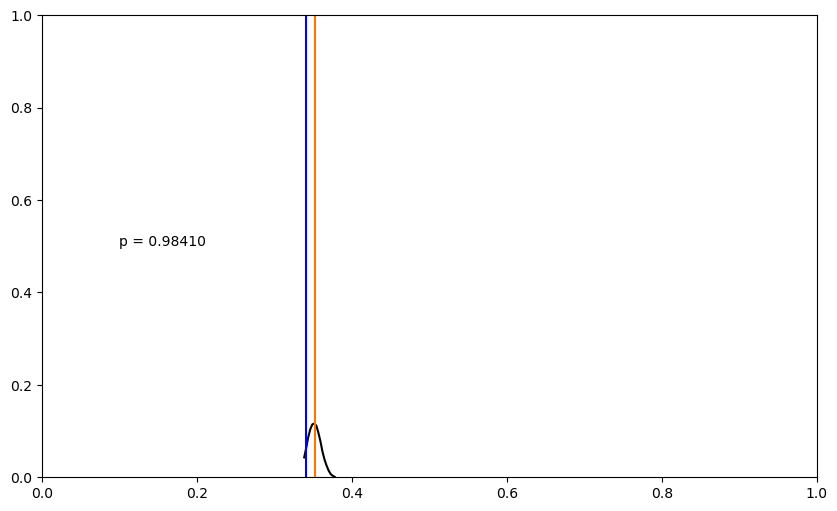

tension_syn


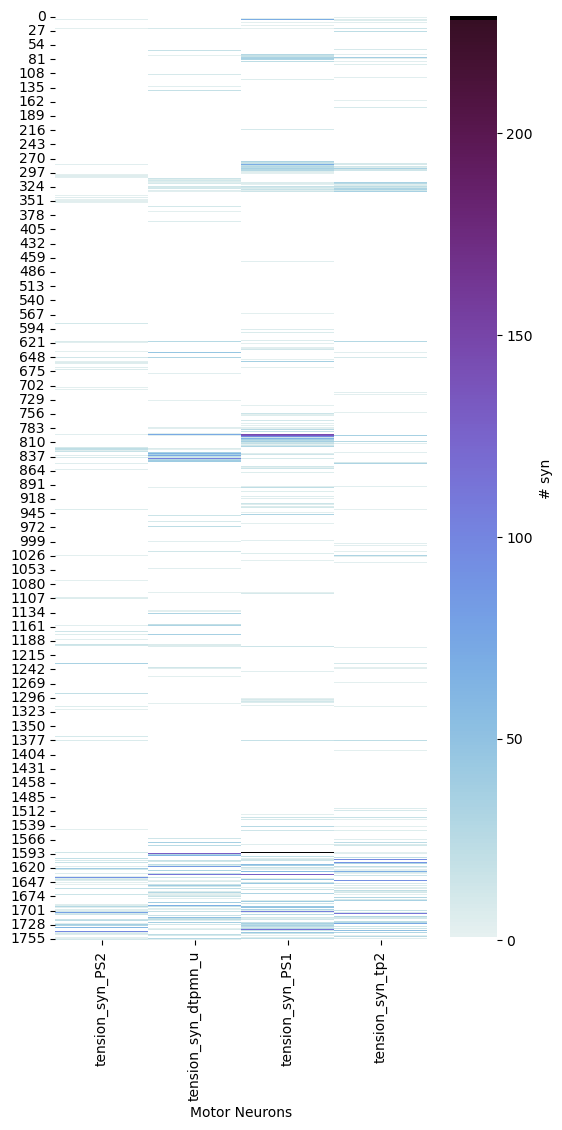

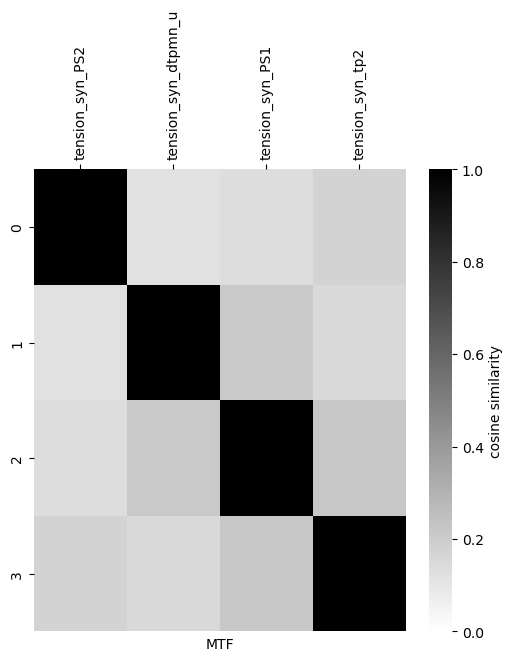

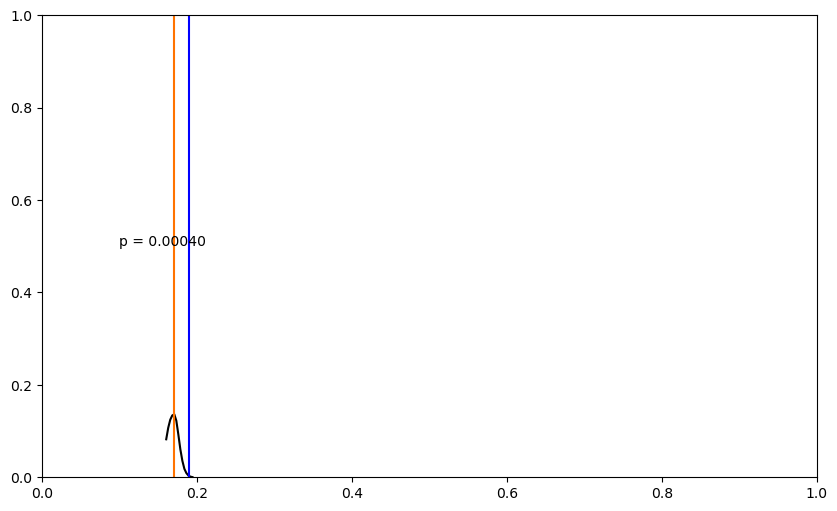

In [141]:
rng = np.random.default_rng()

syn_all = ['DLM_syn', 'DVM_syn', 'tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerhg2_syn', 'steerD_syn']
syn_filter = ['tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn',  'steerD_syn'] # 'steerhg2_syn',
syn_filter = ['DLM_syn', 'DVM_syn', 'tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerD_syn'] #'steerhg2_syn',
directs_only = reordered_wing.loc[:,reordered_wing.columns.get_level_values('mod_name').isin(syn_filter)] # rowsorted
print(directs_only.shape)
directs_only = directs_only.loc[directs_only.sum(axis=1)>0,:]
print(directs_only.shape)

mn_mi_df = directs_only.columns.to_frame() # rowsorted_wing
module_names = list(mn_mi_df.mod_name.unique())
module_names

cos_sim_mean_dict = {}
mixups_dict = {}
mixups_means_dict = {}
pct_below_actual = {}
p_dict = {}

fcnt = 0
pat = 1
N=10000

for modl in module_names:
    print(modl)

    # try a few different ways to do this:

    if pat==1:
        # 1) just shuffle local neurons, use all
        mod_df = directs_only.loc[:,directs_only.columns.get_level_values('mod_name').isin([modl])]
        class_list = ['local']
    if pat==2:
        # 2) shuffle all neurons, use all
        mod_df = directs_only.loc[:,directs_only.columns.get_level_values('mod_name').isin([modl])]
        class_list = All
    if pat==3:
        # 3) shuffle local neurons, use local
        mod_df = directs_only.loc[(All,All,All,['local'],All),directs_only.columns.get_level_values('mod_name').isin([modl])]
        class_list = All
    

    sim_mat = cosine_similarity(mod_df.to_numpy().transpose())
    
    mask_df = pd.DataFrame(data=np.full(mod_df.shape, False),index=mod_df.index,columns=mod_df.columns)
    mask_df.loc[(All,[modl],All,class_list,All)] = True
    mask_modl = mask_df.to_numpy().copy()

    pair_wise_comparisons = np.tril(np.full(sim_mat.shape,True),k=-1)
    cos_sim_mean_dict[modl] = sim_mat[pair_wise_comparisons].mean()

    # plot_conn_map(mod_df.to_numpy(),mod_df,'{}_start_conn'.format(modl))
    # plot_sim_map(sim_mat,mod_df,fn='{}_start_sim'.format(modl))
    
    # allocate an empty array


    mixups = np.zeros((N,sim_mat[pair_wise_comparisons].size))
    mixupmat = mod_df.to_numpy().copy()

    pltflp=True
    for r in range(N): # range(N):
        # Do this for all of the masks
        mixup = mix_up_columns_under_mask(mixupmat,mask=mask_modl,rng=rng)
        sim_mat = cosine_similarity(mixup.transpose())
        mixups[r,:] = sim_mat[pair_wise_comparisons]

        if r>998 and pltflp: # Check the mixups
            plot_conn_map(mixup,mod_df,fn=None) # plot_conn_map(mixup,mod_df,fn='{}_dense_not_proportional'.format(modl))
            plot_sim_map(sim_mat,mod_df,fn=None) # plot_sim_map(sim_mat,mod_df,fn='{}_dense_not_pro_sim'.format(modl))
            pltflp=False

    mixups_dict[modl] = mixups
    mixups_means_dict[modl] = mixups.mean(axis=1)
    pct_below_actual[modl] = (mixups_means_dict[modl]<cos_sim_mean_dict[modl]).sum() / len(mixups_means_dict[modl])
    p_dict[modl]=1-pct_below_actual[modl]

    fcnt = fcnt+1
    # plot_shuf_cum(mixups_means_dict[modl],color = '#000000',ref_x=cos_sim_mean_dict[modl], fn='pairwise_cum_to_{}_ref'.format(modl),fignum=fcnt,title=modl)
    plot_normalized_pdf(mixups_means_dict[modl],color = '#000000',ref_x=cos_sim_mean_dict[modl], fn='pairwise_pdf_wing_{}_to_{}_ref'.format(fcnt,modl),fignum=fcnt,title=modl)

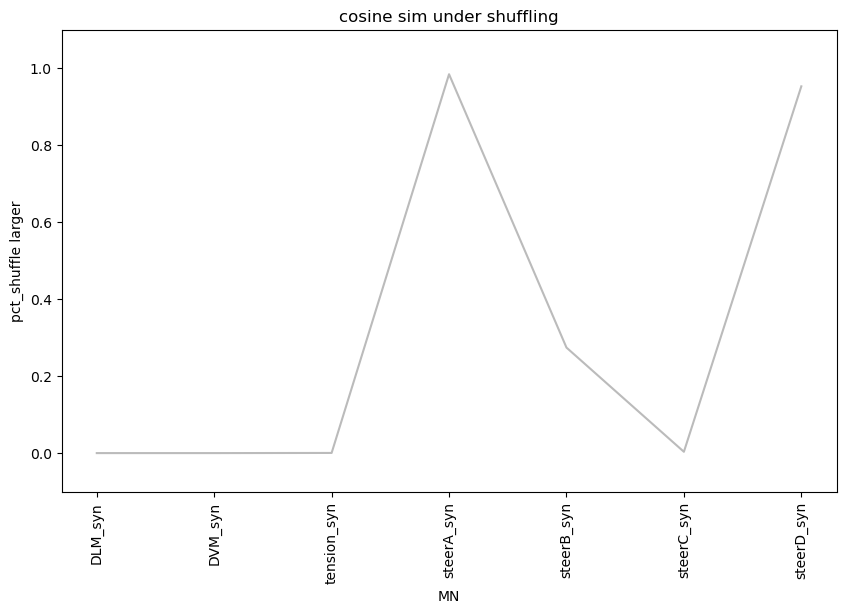

In [142]:

p_realign = {}
for modl in ['DLM_syn', 'DVM_syn','tension_syn','steerA_syn', 'steerB_syn', 'steerC_syn','steerD_syn']:
    p_realign[modl] = p_dict[modl]

# plot the MWU AUC curves
fig = plt.figure(1, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
ax.set_ylabel('pct_shuffle larger')
ax.set_xlabel('MN')
ax.set_title('cosine sim under shuffling')
# ax.xaxis.set_ticks_position('top')
ax.set_xticks(range(len(p_dict.values())))
ax.set_xticklabels(p_realign.keys(),rotation = 90)


# ax.plot([0,len(mwu_val)],[mwu_val_max,mwu_val_max],color='#000000',linestyle='dashed')
ax.plot(range(len(p_realign.values())),p_realign.values(),color='#BBBBBB')
fig.savefig('./figpanels/pct_larger_wing.svg',format='svg')

In [143]:
p_dict.keys()

dict_keys(['DLM_syn', 'DVM_syn', 'steerC_syn', 'steerD_syn', 'steerB_syn', 'steerA_syn', 'tension_syn'])

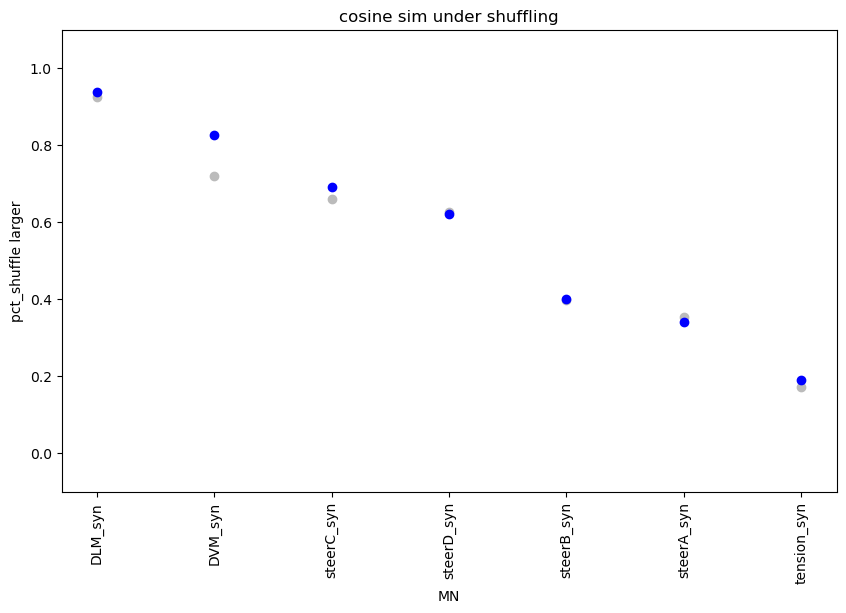

In [144]:

# plot the MWU AUC curves
fig = plt.figure(1, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
ax.set_ylabel('pct_shuffle larger')
ax.set_xlabel('MN')
ax.set_title('cosine sim under shuffling')
# ax.xaxis.set_ticks_position('top')
ax.set_xticks(range(len(p_dict.values())))
ax.set_xticklabels(p_dict.keys(),rotation = 90)

mixups_means_means = {}
for modl in mixups_means_dict.keys():
    mixups_means_means[modl] = mixups_means_dict[modl].mean()
# ax.plot([0,len(mwu_val)],[mwu_val_max,mwu_val_max],color='#000000',linestyle='dashed')
ax.scatter(range(len(mixups_means_means.values())),mixups_means_means.values(),color='#BBBBBB')
ax.scatter(range(len(cos_sim_mean_dict.values())),cos_sim_mean_dict.values(),color='#0000FF')

# PCA plots

In [145]:
reordered_wing

MN                                                                                  DLM_1  \
mod_num                                                                                 0   
mod_name                                                                          DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT preferred_mn           
648518346475807714 DLM_syn          uk        ascending  unk         DLM_2              8   
648518346489573207 DLM_syn          uk        ascending  unk         DLM_2              3   
648518346478901712 DLM_syn          uk        ascending  unk         DLM_2              4   
648518346504777587 DLM_syn          uk        ascending  unk         DLM_3             37   
648518346478664788 DLM_syn          uk        ascending  unk         DLM_3              4   
...                                                                                   ...   
648518346500883868 tension_syn      11B       local      GABA        tp2                0   
648518346501086486 tension_syn      17A       local      ACh         tp2                0   
648518346502422086 tension_syn      7B        local      ACh         tp2                0   
648518346504358124 tension_syn      17A       local      ACh         tp2                0   
648518346515177031 tension_syn      11B       local      GABA        tp2                0   

MN                                                                                  DLM_5  \
mod_num                                                                                 0   
mod_name                                                                          DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT preferred_mn           
648518346475807714 DLM_syn          uk        ascending  unk         DLM_2              9   
648518346489573207 DLM_syn          uk        ascending  unk         DLM_2              5   
648518346478901712 DLM_syn          uk        ascending  unk         DLM_2              0   
648518346504777587 DLM_syn          uk        ascending  unk         DLM_3             57   
648518346478664788 DLM_syn          uk        ascending  unk         DLM_3              3   
...                                                                                   ...   
648518346500883868 tension_syn      11B       local      GABA        tp2                0   
648518346501086486 tension_syn      17A       local      ACh         tp2                0   
648518346502422086 tension_syn      7B        local      ACh         tp2                0   
648518346504358124 tension_syn      17A       local      ACh         tp2                0   
648518346515177031 tension_syn      11B       local      GABA        tp2                0   

MN                                                                                  DLM_3  \
mod_num                                                                                 0   
mod_name                                                                          DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT preferred_mn           
648518346475807714 DLM_syn          uk        ascending  unk         DLM_2             14   
648518346489573207 DLM_syn          uk        ascending  unk         DLM_2              5   
648518346478901712 DLM_syn          uk        ascending  unk         DLM_2              4   
648518346504777587 DLM_syn          uk        ascending  unk         DLM_3             70   
648518346478664788 DLM_syn          uk        ascending  unk         DLM_3             13   
...                                                                                   ...   
648518346500883868 tension_syn      11B       local      GABA        tp2                0   
648518346501086486 tension_syn      17A       local      ACh         tp2                0   
648518346502422086 tension_syn      7B        local      ACh         tp2                0   

In [146]:
import utils
mpool_dict = utils.get_motor_pool_tuple_dict()
mod_keys = reordered_wing.columns.get_level_values('mod_name').unique()

fname = './figpanels/PCA_wing_modules_pct.svg'
# pre_to_mn_df.head()
# mpool_dict

local_df = reordered_wing.loc[(All,All,All,'local',All,All),:]
local_df.index.get_level_values('preferred_module').unique()

CategoricalIndex(['DLM_syn', 'DVM_syn', 'steerC_syn', 'steerD_syn',
                  'steerB_syn', 'steerA_syn', 'steerhg2_syn', 'tension_syn'],
                 categories=['DLM_syn', 'DVM_syn', 'steerC_syn', 'steerD_syn', 'steerB_syn', 'steerA_syn', 'steerhg2_syn', 'tension_syn'], ordered=True, dtype='category', name='preferred_module')

In [147]:
local_df

MN                                                                                  DLM_1  \
mod_num                                                                                 0   
mod_name                                                                          DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT preferred_mn           
648518346494555703 DLM_syn          18B       local      ACh         DLM_1             96   
648518346493750264 DLM_syn          19B       local      ACh         DLM_1             72   
648518346499962623 DLM_syn          19B       local      ACh         DLM_1             45   
648518346480837344 DLM_syn          6B        local      GABA        DLM_1             41   
648518346491785583 DLM_syn          19B       local      ACh         DLM_1             28   
...                                                                                   ...   
648518346500883868 tension_syn      11B       local      GABA        tp2                0   
648518346501086486 tension_syn      17A       local      ACh         tp2                0   
648518346502422086 tension_syn      7B        local      ACh         tp2                0   
648518346504358124 tension_syn      17A       local      ACh         tp2                0   
648518346515177031 tension_syn      11B       local      GABA        tp2                0   

MN                                                                                  DLM_5  \
mod_num                                                                                 0   
mod_name                                                                          DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT preferred_mn           
648518346494555703 DLM_syn          18B       local      ACh         DLM_1             78   
648518346493750264 DLM_syn          19B       local      ACh         DLM_1             70   
648518346499962623 DLM_syn          19B       local      ACh         DLM_1             38   
648518346480837344 DLM_syn          6B        local      GABA        DLM_1             37   
648518346491785583 DLM_syn          19B       local      ACh         DLM_1             28   
...                                                                                   ...   
648518346500883868 tension_syn      11B       local      GABA        tp2                0   
648518346501086486 tension_syn      17A       local      ACh         tp2                0   
648518346502422086 tension_syn      7B        local      ACh         tp2                0   
648518346504358124 tension_syn      17A       local      ACh         tp2                0   
648518346515177031 tension_syn      11B       local      GABA        tp2                0   

MN                                                                                  DLM_3  \
mod_num                                                                                 0   
mod_name                                                                          DLM_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT preferred_mn           
648518346494555703 DLM_syn          18B       local      ACh         DLM_1             34   
648518346493750264 DLM_syn          19B       local      ACh         DLM_1             66   
648518346499962623 DLM_syn          19B       local      ACh         DLM_1             27   
648518346480837344 DLM_syn          6B        local      GABA        DLM_1              5   
648518346491785583 DLM_syn          19B       local      ACh         DLM_1             17   
...                                                                                   ...   
648518346500883868 tension_syn      11B       local      GABA        tp2                0   
648518346501086486 tension_syn      17A       local      ACh         tp2                0   
648518346502422086 tension_syn      7B        local      ACh         tp2                0   

(149, 5)
(43, 7)
(121, 2)
(148, 4)
(183, 3)
(83, 3)
(16, 1)
(168, 4)


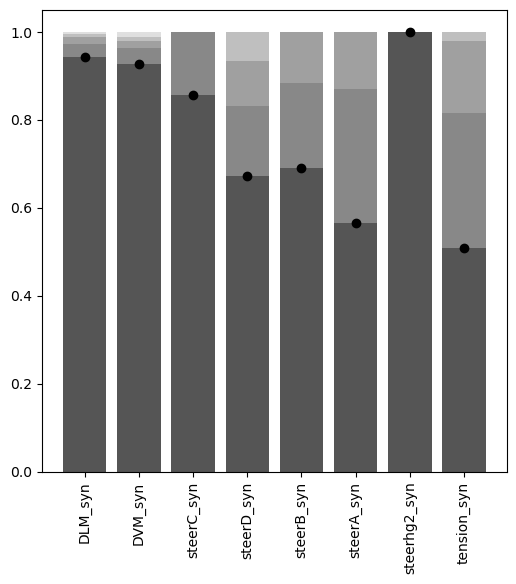

In [148]:
var_frac_dict = {}
pca_decomp = PCA(n_components=None,
        copy=True, 
        whiten=False, 
        svd_solver='full', 
        tol=0.0, 
        iterated_power='auto')

for mod in mod_keys:
    # if mod == 'steerhg2_syn':
    #     continue
    # else:
    syn = local_df.loc[(All,mod,All,'local',All,All),(All,All,mod)]
    print(syn.shape)
    mu = np.mean(syn, axis=0)

    syn_pca = pca_decomp.fit(syn)
    A0 = syn_pca.transform(syn)
    var_frac_dict[mod] = syn_pca.explained_variance_/syn_pca.explained_variance_.sum()

fig, ax = plt.subplots( 1, 1, figsize=(6,6))
clrs = [
    '#555555',
    '#888888',
    '#A0A0A0',
    '#BFBFBF',
    '#DFDFDF',
    '#E0E0E0',
    '#E7E7E7',
    '#EBEBEB',
    '#EFEFEF',
    '#F2F2F2',
    '#F4F4F4',
    '#F8F8F8',
]


m = 0
pc1 = []
pc2 = []
for mod in mod_keys:
    pc_frac = var_frac_dict[mod]
    bottom = 0.
    pc1+=[pc_frac[0]]
    # pc2+=[pc_frac[1]]
    for pc_fr,clr in zip(pc_frac,clrs):
        p = ax.bar(m, pc_fr, 0.8, bottom=bottom,color=clr)
        bottom += pc_fr
    m+=1

x = range(len(mod_keys))
ax.scatter(x,pc1,color='#000000')
# ax.plot(x,pc2,color=clrs[1])
# ax.plot(x,np.array(pc2)/np.array(pc1))
ax.set_xticks(x)
ax.set_xticklabels(mod_keys)
plt.xticks(rotation=90)

fig.savefig(fname,format='svg')
# fig.savefig('./figpanels/PCA_leg_modules_pct.svg',format='svg')

# Plot the lines for each module

In [149]:
mod = 'steerC_syn'
mod_local_df = reordered_wing.loc[(All,mod,All,'local',All,All),(All,All,mod)] 

mod_local_df.head()

MN                                                                                        b1  \
mod_num                                                                                    5   
mod_name                                                                          steerC_syn   
pre_pt_root_id     preferred_module cell_type cell_class putative_NT preferred_mn              
648518346501334115 steerC_syn       6B        local      GABA        b1                    8   
648518346459413252 steerC_syn       3B        local      GABA        b1                   30   
648518346470412798 steerC_syn       6B        local      GABA        b1                   24   
648518346472239051 steerC_syn       6A        local      GABA        b1                   16   
648518346472248370 steerC_syn       3B        local      GABA        b1                   16   

MN                                                                                        b2  
mod_num                                                                                    5  
mod_name                                                                          steerC_syn  
pre_pt_root_id     preferred_module cell_type cell_class putative_NT preferred_mn             
648518346501334115 steerC_syn       6B        local      GABA        b1                    3  
648518346459413252 steerC_syn       3B        local      GABA        b1                    8  
648518346470412798 steerC_syn       6B        local      GABA        b1                    0  
648518346472239051 steerC_syn       6A        local      GABA        b1                   11  
648518346472248370 steerC_syn       3B        local      GABA        b1                   10

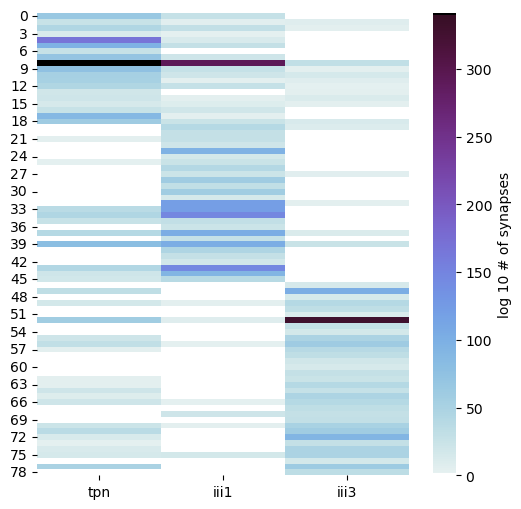

c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


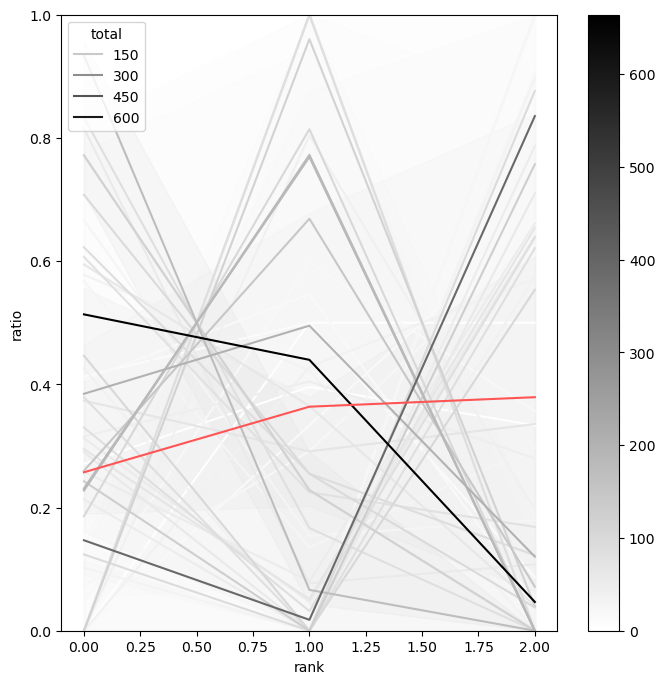

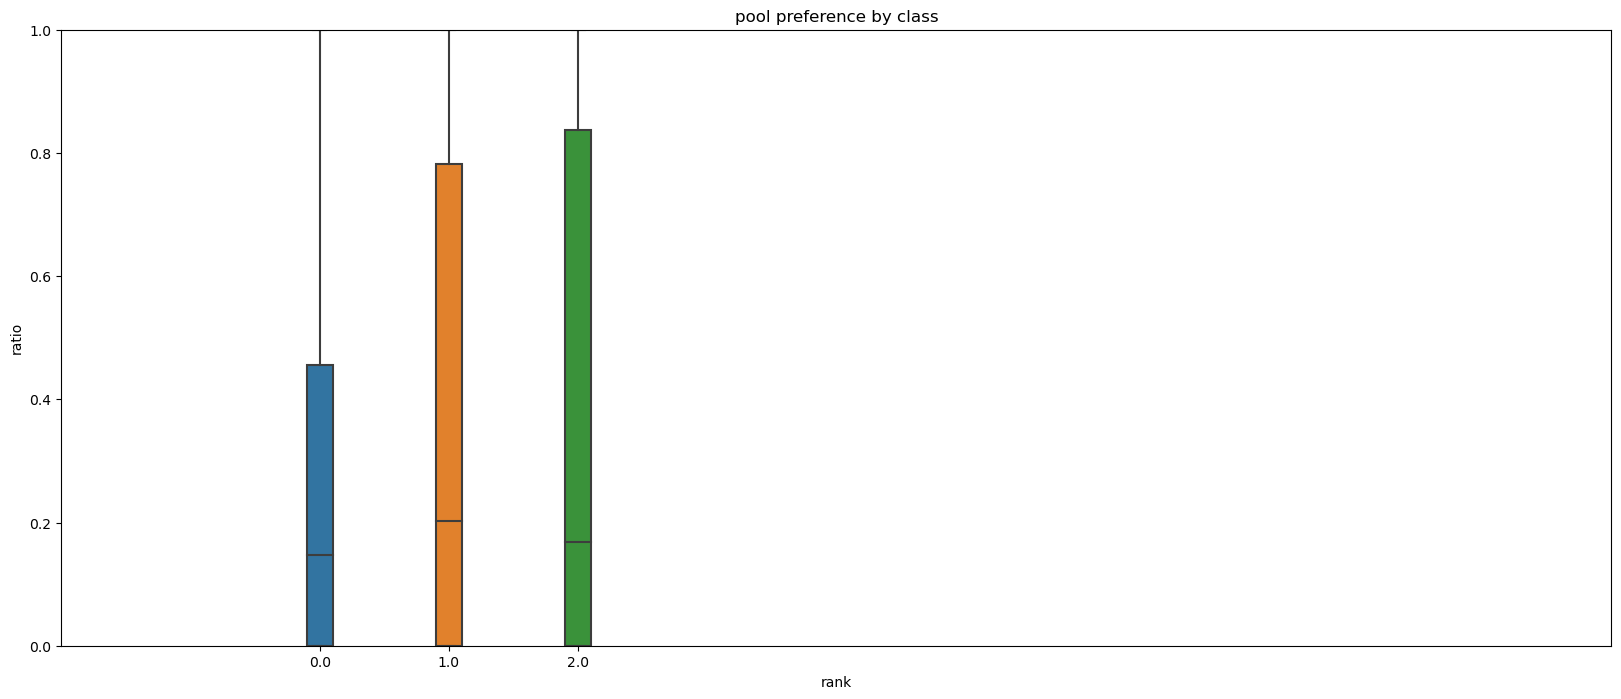

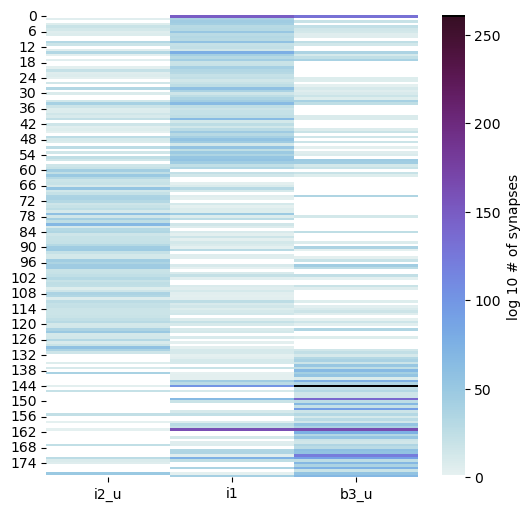

c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


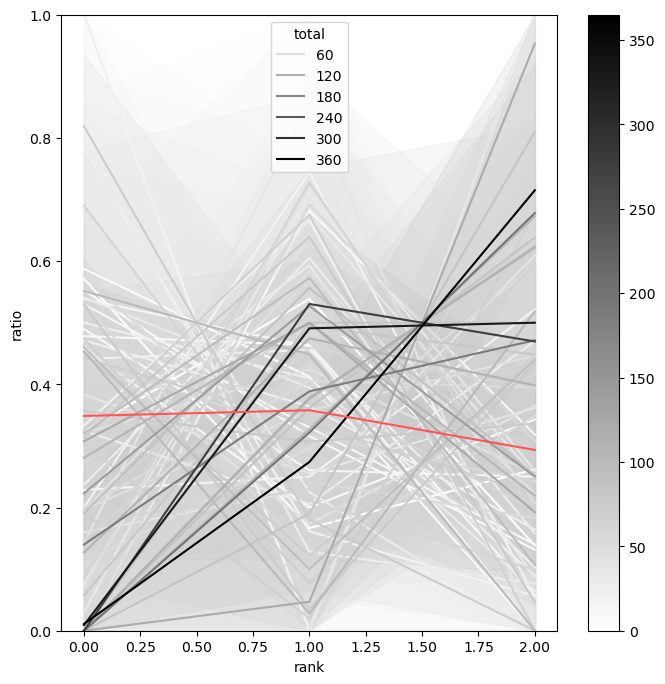

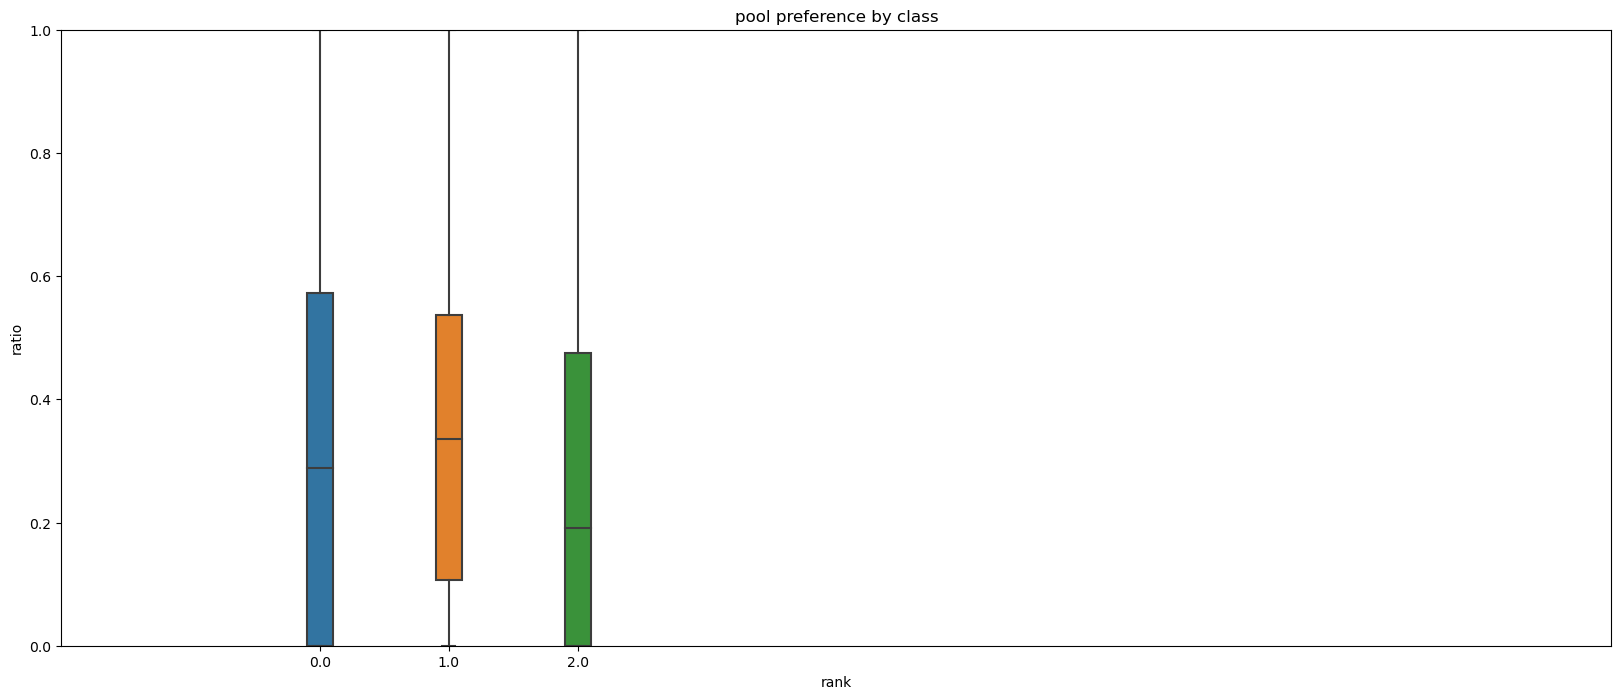

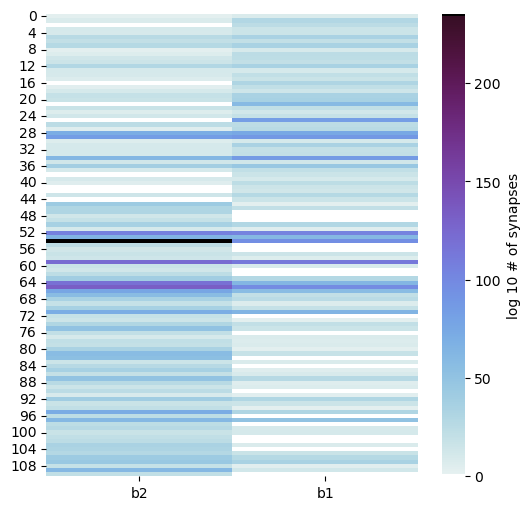

c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tony\miniconda3\envs\fanc_py39_1023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


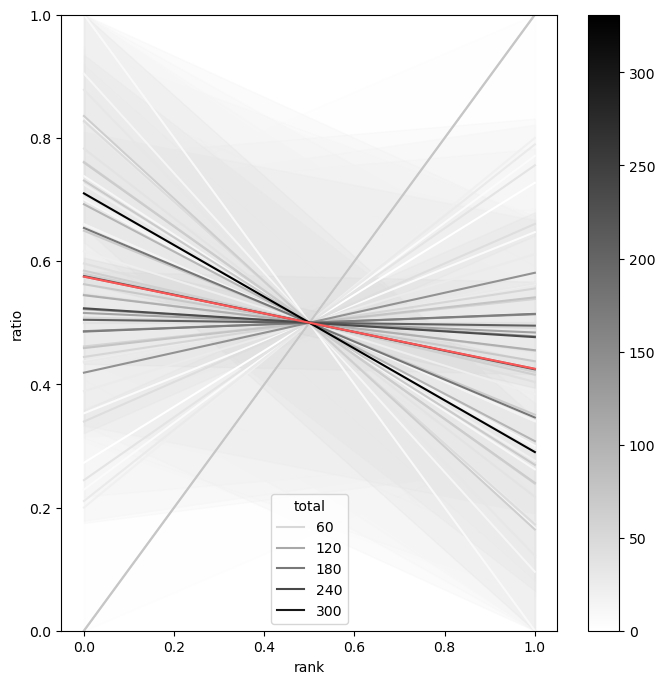

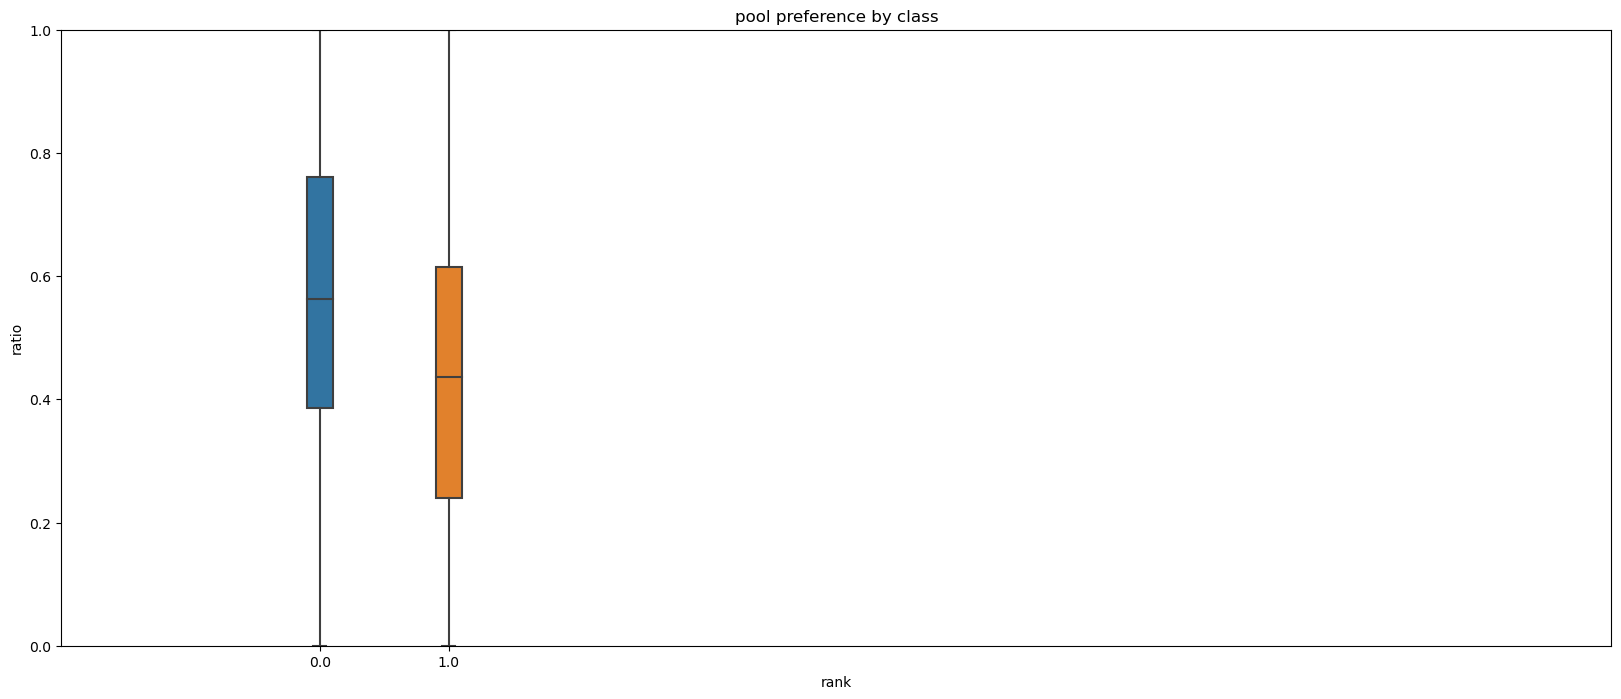

In [150]:
mod_order_dict = {'steerA_syn': [	'tpn',	'iii1','iii3',],'steerB_syn': [	'i2_u',	'i1','b3_u',],'steerC_syn': [	'b2',	'b1'],}
for mod in mod_order_dict.keys():
    mod_local_df = reordered_wing.loc[(All,mod,All,'local',All,All),(mod_order_dict[mod],All,mod)] 
    mod_local_df = mod_local_df.loc[mod_local_df.sum(axis=1)>10,:]

    fig = plt.figure(figsize = [6,6])
    lbls = mod_local_df.columns.get_level_values('MN').to_list()
    ax = sns.heatmap(mod_local_df.to_numpy(), xticklabels=lbls,cmap=utils.white_dense())
    cbar = ax.collections[0].colorbar
    cbar.set_label(label = 'log 10 # of synapses',)
    plt.show()
    # plt.savefig('./figpanels/steering_{}_heat_map.svg'.format(mod),format='svg')


    # now plot the lines
    ratiodf = mod_local_df.divide(mod_local_df.sum(axis=1),axis='index')
    ratiodf.replace([np.inf, -np.inf], np.nan, inplace=True)
    ratiodf = ratiodf.dropna()

    x = [i for i in range(mod_local_df.shape[1])]

    # ratiodf.columns = ratiodf.columns.droplevel(['side','nerve','segment','function','muscle','segID'])
    ranks = ratiodf.copy()
    for c in range(ranks.shape[1]):
        ranks.iloc[:,c] = c


    df = pd.concat([pd.concat([ranks.iloc[:,x] for x in range(ranks.shape[1])]),pd.concat([ratiodf.iloc[:,x] for x in range(ratiodf.shape[1])])],axis=1)
    df.columns=['rank','ratio']
    df['total'] = mod_local_df.sum(axis=1)


    fig, ax = plt.subplots( 1, 1, figsize=(8,8))
    sns.lineplot(data=df.iloc[::-1], x="rank", y="ratio", hue="total",ax=ax,palette=cos_cmap)
    ax.set_ylim([0,1])
    ax.plot(x,np.mean(ratiodf.to_numpy(),axis=0),color='#FF5555')

    norm = plt.Normalize(0,df['total'].max())
    sm = plt.cm.ScalarMappable(cmap=cos_cmap, norm=norm)  # sns.color_palette('gray_r', as_cmap=True)
    ax.figure.colorbar(sm,ax=ax)
    fig.savefig('./figpanels/steering_{}_lines.svg'.format(mod),format='svg')


    f, ax = plt.subplots(figsize=(20,8))
    sns.boxplot(data=df.iloc[::-1], x='rank', y='ratio', saturation=0.75, width=0.2,  fliersize=5, linewidth=None, whis=1.5, ax=ax) # hue=None, order=None, hue_order=None, orient=None, color=None, palette=None,dodge=True,
    # ax=pt.RainCloud(x = dx, y = 'pool_pref', data = sim_compare_df, palette = pal, bw = sigma,
    #                   width_viol = .6, ax = ax, orient = 'v', move = .2,pointplot=True)
    ax.set_ylim([0,1])
    ax.set_xlim([-2,10])
    ax.set_title('pool preference by class')
    f.savefig('./figpanels/steering_{}_boxes.svg'.format(mod),format='svg')


# Plot preference strength vs. total MN synapses

In [184]:
from scipy.stats import pearsonr

pref_total_df = reordered_wing.T.groupby(level='mod_name',observed=True).sum().T
denom = pref_total_df.sum(axis=1)
pref_strength_df = pref_total_df.div(denom,axis=0)
# pref_strength_df = pref_strength_df.droplevel(['cell_class','NT','classification_system','cell_type','segID'])
pref_strength_df['total'] = pref_total_df.sum(axis=1)
pref_strength_df['mod_pref'] = 0.
pref_strength_df

pref_str_segid_df = pref_strength_df.copy()
pref_str_segid_df = pref_str_segid_df.droplevel(['cell_class','preferred_module','putative_NT','preferred_mn','cell_type'])
pref_strength_df = pref_strength_df.droplevel(['cell_class','putative_NT','preferred_mn','cell_type'])
pref_strength_df.index = pref_strength_df.index.reorder_levels(['preferred_module','pre_pt_root_id'])

module_names = ['DLM_syn', 'DVM_syn', 'tension_syn', 'steerA_syn', 'steerB_syn', 'steerC_syn', 'steerhg2_syn', 'steerD_syn']
for mod in module_names: 
    each = pref_strength_df.loc[mod,((pref_strength_df.columns.get_level_values('mod_name') == mod))]
    pref_str_segid_df.loc[each.index,'mod_pref'] = each.loc[each.index,mod]

pref_str_segid_df.index = reordered_wing.index

r = -0.4792573134226071, p = 4.567856916855854e-06


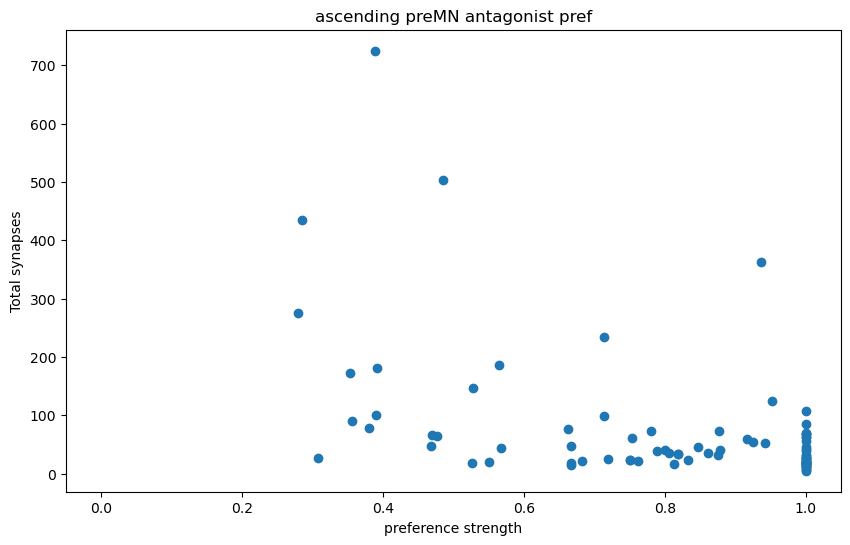

(263,)
r = -0.43555692792064526, p = 1.3334088671366943e-13


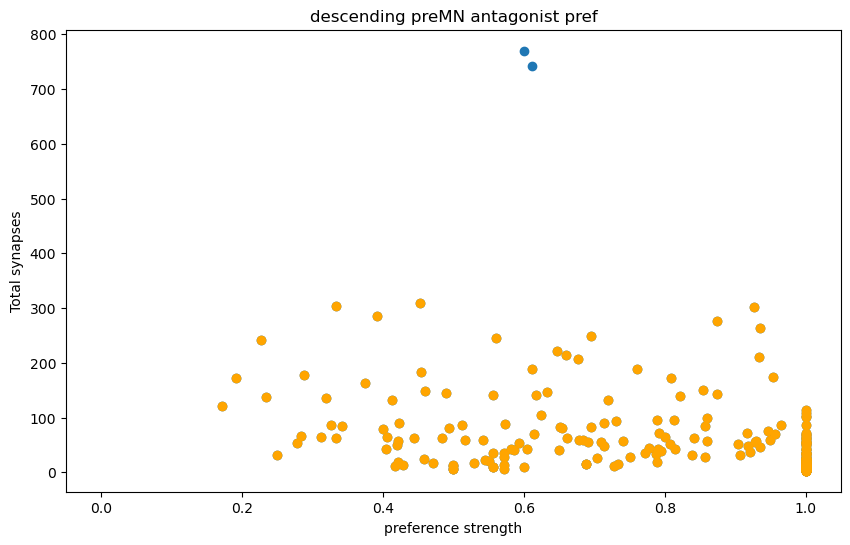

r = -0.30472236971172506, p = 8.17927796605234e-07


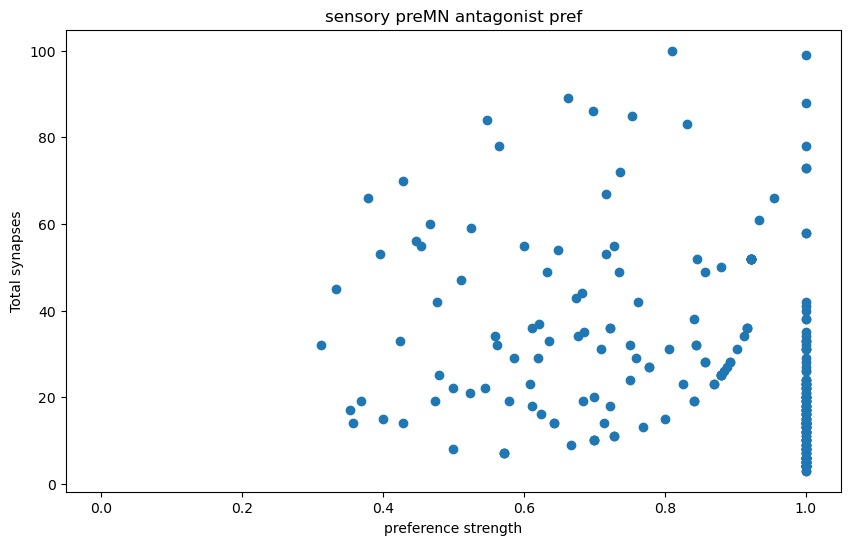

r = -0.1640822684209981, p = 0.007105579824820461


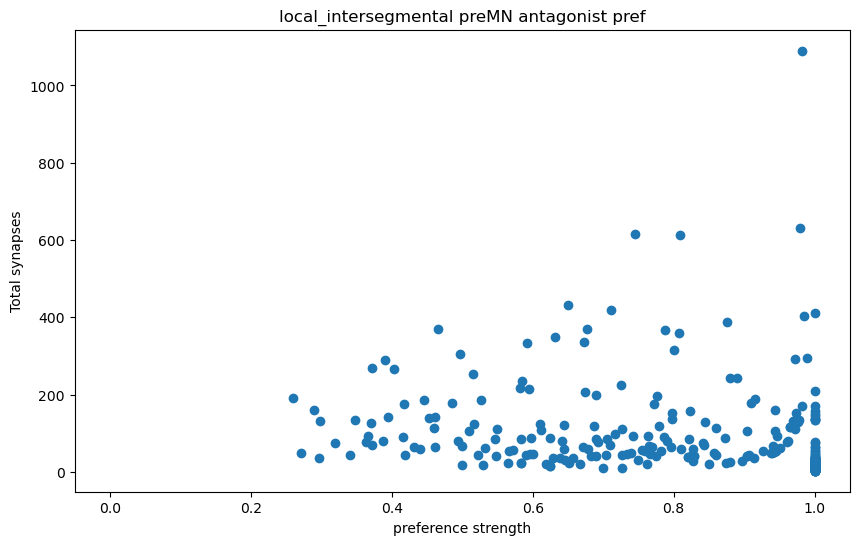

r = -0.1164798579364131, p = 0.0004269225916095287


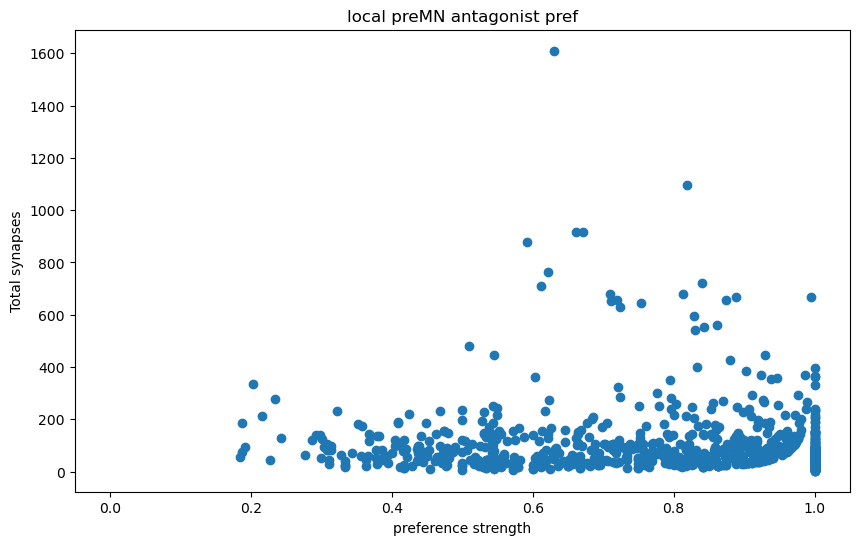

In [185]:
pref_str_segid_df.index = pref_total_df.index
for cell_class in reordered_wing.index.get_level_values("cell_class").unique():

    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot2grid((1,1),(0,0))
    ax.set_xlim([-.05, 1.05])

    ax.set_ylabel('Total synapses')
    ax.set_xlabel('preference strength')
    ax.set_title('{} preMN antagonist pref'.format(cell_class))

    x = pref_str_segid_df.loc[(All,All,All,cell_class,All,All),'mod_pref']
    y = pref_str_segid_df.loc[(All,All,All,cell_class,All,All),'total']

    ax.scatter(x,y,label='all')
    if cell_class=='descending':
        x = x[y<600]
        y = y[y<600]
        ax.scatter(x,y,label='select',color='orange')
        print(x.shape)
    correlation_coefficient, p_value = pearsonr(x, y)
    print('r = {}, p = {}'.format(correlation_coefficient,p_value))
    plt.show()
    fig.savefig('./figpanels/pref_total_syn_num_wing_{}.svg'.format(cell_class),format='svg')


In [181]:
x.loc[x==0]

pre_pt_root_id      preferred_module  cell_type  cell_class  putative_NT  preferred_mn
648518346513913369  steerhg2_syn      6B         local       GABA         hg2             0.0
648518346501042198  steerhg2_syn      6B         local       GABA         hg2             0.0
648518346494701739  steerhg2_syn      23B        local       ACh          hg2             0.0
648518346471804059  steerhg2_syn      6A         local       GABA         hg2             0.0
648518346482700518  steerhg2_syn      18B        local       ACh          hg2             0.0
648518346486241440  steerhg2_syn      6A         local       GABA         hg2             0.0
648518346489939383  steerhg2_syn      5B         local       GABA         hg2             0.0
648518346492480697  steerhg2_syn      12B        local       GABA         hg2             0.0
648518346493092380  steerhg2_syn      uk         local       unk          hg2             0.0
648518346494803883  steerhg2_syn      6B         local       GABA  

# Preference strength histograms by cell class